In [151]:
%load_ext autoreload
%autoreload 2

import numpy as np
from scipy.sparse import csc_array

import matplotlib.pyplot as plt
import matplotlib as mpl

# default parameters of the plot layout
plt.rcParams["text.usetex"] = True  # use latex
plt.rcParams["font.size"] = 13
plt.rcParams["figure.dpi"] = 300
plt.rcParams["figure.constrained_layout.use"] = True

from qs_mps.applications.Z2.exact_hamiltonian import *
from qs_mps.sparse_hamiltonians_and_operators import diagonalization, sparse_magnetization, sparse_pauli_x, sparse_pauli_z
from qs_mps.mps_class import MPS
from qs_mps.utils import anim, get_cx, get_cy, create_sequential_colors

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Periodic Boundary Condition Time Evolution

We are going to check the validity of the MPO for time evolution with the pbc hamiltonian. Hence, we are going to perform exact diagonalization with sparse matrices and compare the results.

## 1. Exact Time Evolution

We are going to perform two types of evolution:
- a. Start with the vacuum in the roughening, apply a string operator, evolve with the same hamiltonian
- b. Start with the string in the confined, evolve with the hamiltonian in the roughening region

### 1.a.1 Dual Hamiltonian in the vacuum roughening region

In [124]:
def charge_func(i: int, j: int, l: int, cx: list=None, cy: list=None):
    if cx is not None and cy is not None:
        if i >= cx[0] and i < cx[1] and (j+1)%l == cy[0]:
            return -1
        else:
            return 1
    else:
        return 1

def electric_dual_ham(l: int, L: int, cx: list=None, cy: list=None):
    dof = l*L + 1
    O = csc_array((2**dof, 2**dof), dtype=complex)
    # O = csc_array(arg1=(2**dof, 2**dof), dtype=complex)
    H_sigmas = O
    H_taus = O

    # charges
    charges = np.ones((l,L+1))
    if cx is not None:
        charges[cy[0],cx[0]] = -1
        charges[cy[1],cx[1]] = -1

    prod_charges = np.prod(charges, axis=1).tolist()

    # first column of sigmas are local
    for j in range(l):
        H_sigmas += sparse_pauli_z(n=j, L=dof)
    
    # horizontal zz interactions, we exclude the last column of sigmas
    for i in range(L-1):
        for j in range(l):
            H_sigmas += sparse_pauli_z(n=j+i*l, L=dof) @ sparse_pauli_z(n=j+(i+1)*l, L=dof)

    # horizontal zz interactions, last column of sigmas
    for j in range(l):
        # H_sigmas += sparse_pauli_z(n=j*L+L-1, L=dof) @ sparse_pauli_z(n=l*L, L=dof)
        H_sigmas += np.prod(prod_charges[:(j+1)]) * sparse_pauli_z(n=j+(L-1)*l, L=dof) @ sparse_pauli_z(n=l*L, L=dof)

    # vertical zz interactions 
    for i in range(L):
        for j in range(l):
            # coeff = charge_func(i,j,l,cx,cy)
            # H_taus += coeff * sparse_pauli_z(n=j*L+i, L=dof) @ sparse_pauli_z(n=((j+1)%l)*L+i, L=dof)
            H_taus += np.prod(charges[(j+1)%l,:(i+1)]) * sparse_pauli_z(n=j+i*l, L=dof) @ sparse_pauli_z(n=((j+1)%l)+i*l, L=dof)

    return H_sigmas + H_taus

def magnetic_dual_ham(l: int, L: int):
    dof = l*L + 1
    O = csc_array((2**dof, 2**dof), dtype=complex)
    H_plaquettes = O

    # plaquette terms
    for i in range(l*L):
        H_plaquettes += sparse_pauli_x(n=i, L=dof)
    return H_plaquettes

def dual_ham(l,L,g, cx: list=None, cy: list=None):
    # electric vertical and horizontal terms
    H_el = electric_dual_ham(l,L,cx,cy)

    # magnetic plaquette terms
    H_mag = magnetic_dual_ham(l,L)

    return - g * H_el - 1/g * H_mag

def electric_field(l: int, L: int, statevector: np.ndarray, cx: list=[], cy: list=[]):
    dof = l*L + 1
    exp_sigmas = []
    exp_taus = []

    # charges
    charges = np.ones((l,L+1))
    if len(cx) != 0:
        charges[cy[0],cx[0]] = -1
        charges[cy[1],cx[1]] = -1
    prod_charges = [1] + np.prod(charges[1:], axis=1).tolist()

    # first column of sigma are local
    for j in range(l):
        # H_sigmas += sparse_pauli_z(n=j*L, L=dof)
        exp_sigmas.append(statevector.T.conjugate() @ sparse_pauli_z(n=j, L=dof) @ statevector)
    
    # horizontal zz interactions, we exclude the last column of sigmas
    for j in range(l):
        for i in range(L-1):
            # H_sigmas += sparse_pauli_z(n=i+j*L, L=dof) @ sparse_pauli_z(n=(i+1)+j*L, L=dof)
            exp_sigmas.append(statevector.T.conjugate() @ sparse_pauli_z(n=j+i*l, L=dof) @ sparse_pauli_z(n=j+(i+1)*l, L=dof) @ statevector)

    # horizontal zz interactions, last column of sigmas
    for j in range(l):
        # H_sigmas += np.prod(prod_charges[:(j+1)]) * sparse_pauli_z(n=j*L+L-1, L=dof) @ sparse_pauli_z(n=l*L, L=dof)
        exp_sigmas.append(np.prod(prod_charges[:(j+1)]) * (statevector.T.conjugate() @ sparse_pauli_z(n=j+(L-1)*l, L=dof) @ sparse_pauli_z(n=l*L, L=dof) @ statevector))

    # vertical zz interactions 
    for i in range(L):
        for j in range(l):
            # H_taus += np.prod(charges[(j+1)%l,:(i+1)]) * sparse_pauli_z(n=j*L+i, L=dof) @ sparse_pauli_z(n=((j+1)%l)*L+i, L=dof)
            exp_taus.append(np.prod(charges[(j+1)%l,:(i+1)]) * (statevector.T.conjugate() @ sparse_pauli_z(n=j+i*l, L=dof) @ sparse_pauli_z(n=((j+1)%l)+i*l, L=dof) @ statevector))
    
    exp_sigmas_l = np.asarray(exp_sigmas[:l]).reshape((l,1))
    exp_sigmas_b = np.asarray(exp_sigmas[l:-l]).reshape((l,(L+1)-2))
    exp_sigmas_r = np.asarray(exp_sigmas[-l:]).reshape((l,1))
    exp_ver = [[exp_sigmas_l[i]]+[exp_sigmas_b[i]]+[exp_sigmas_r[i]] for i in range(l)]
    exp_ver_swaped = []
    for row in exp_ver:
        for elem in row:
            if len(elem) == 1:
                exp_ver_swaped += (elem.real).tolist()
            else:
                exp_ver_swaped += (elem.real).tolist()
    exp_hor = np.array(exp_taus).reshape((L,l))
    exp_hor_swaped = exp_hor.swapaxes(0,1)
    exp_hor_swaped[[0,-1]] = exp_hor_swaped[[-1,0]]
    exp_val = np.zeros((2*l,2*L+1))
    exp_val[:] = np.nan
    exp_val[1::2,::2] = np.asarray(exp_ver_swaped).reshape((l,L+1))
    exp_val[::2,1::2] = np.asarray(exp_hor_swaped).reshape((l,L))
    
    return exp_val

In [125]:
l = 2
L = 3
g = 10
H_vr = dual_ham(l,L,g)
e, psi0 = diagonalization(H_vr, sparse=True)
print(len(e),psi0.shape, e)

1 (128, 1) [-140.00075]


In [126]:
# charges
cx = [1,2]
cy = [0,0]
charges = np.ones((l,L+1))
if len(cx) != 0:
    charges[cy[0],cx[0]] = -1
    charges[cy[1],cx[1]] = -1
prod_charges = np.prod(charges, axis=1).tolist()
print(charges)
print(prod_charges)
i = 1
j = 3
print(charges[(i+1)%l,:(j+1)])

[[ 1. -1. -1.  1.]
 [ 1.  1.  1.  1.]]
[1.0, 1.0]
[ 1. -1. -1.  1.]


In [127]:
i = 1
j = 1
l = 2
i >= cx[0] and i < cx[1] and (j+1)%l == cy[0]

True

### 1.a.2 Application of the string operator

In [128]:
def string_operator(cx: list=None, cy: list=None):
    pass

### 1.a.3 Evolution with the Dual Hamiltonian in the vacuum roughening region

### 1.b.1 Dual Hamiltonian in the string confined region

In [129]:
l = 3
L = 3
R = 1
bc = "pbc"
g = 0.1
cx = get_cx(L=L,R=R)
cy = get_cy(l=l,bc=bc)
cx, cy = None, None
H_sc = dual_ham(l,L,g,cx,cy)
e, psi0 = diagonalization(H_sc, sparse=False)
print(len(e),psi0.shape, type(psi0), e)
psi0 = psi0[:,0]
print(psi0.shape)

1024 (1024, 1024) <class 'numpy.ndarray'> [-90.00682272 -90.00682209 -70.34887608 ...  70.24731574  90.00667959
  90.00668016]
(1024,)


### 1.b.2 Evolution with Dual Hamiltonian in the string roughening region

In [130]:
from scipy.sparse.linalg import expm
from scipy.linalg import norm


def evolution_operator(delta, hamiltonian):
    return expm(-1j*delta*hamiltonian)

def trott_Z2_dual_1(delta, coupling, H_loc, H_int):
    U_loc = evolution_operator(delta=delta*(-1/coupling), hamiltonian=H_loc)    
    U_int = evolution_operator(delta=delta*(-coupling), hamiltonian=H_int)
    return U_loc @ U_int
    
def trott_Z2_dual_2(delta, coupling, H_loc, H_int):
    U_loc = evolution_operator(delta=(delta/2)*(-1/coupling), hamiltonian=H_loc)    
    U_int = evolution_operator(delta=delta*(-coupling), hamiltonian=H_int)
    return U_loc @ U_int @ U_loc

def trott_Z2_dual(l, L, cx, cy, delta, coupling, ord: int=1):
    H_ev_el = electric_dual_ham(l, L, cx, cy) # zz dual interaction term
    H_ev_mag = magnetic_dual_ham(l, L) # x dual local term
    if ord == 1:
        U_ev = trott_Z2_dual_1(delta, coupling, H_loc=H_ev_mag, H_int=H_ev_el)
    if ord == 2:
        U_ev = trott_Z2_dual_2(delta, coupling, H_loc=H_ev_mag, H_int=H_ev_el)
    return U_ev

from qs_mps.mps_class import MPS
from qs_mps.utils import von_neumann_entropy

In [132]:
l = 3
L = 3
R = 1
bc = "pbc"
g_ev = 0.1
cx = get_cx(L=L,R=R)
cy = get_cy(l=l,bc=bc)
cx, cy = None, None
steps = 10
delta = 0.01

U_trott = trott_Z2_dual(l, L, cx, cy, delta, coupling=g_ev, ord=1)
U_trott2 = trott_Z2_dual(l, L, cx, cy, delta, coupling=g_ev, ord=2)
# U_trott4 = trott_Z2_dual(delta, ord=4)

psi_ev_trott = psi0.copy()
psi_ev_trott2 = psi0.copy()
# psi_ev_trott4 = psi0.copy()
mps_ev = MPS(L=L, d=l**2, model="Z2_dual", chi=16)


diff1 = [0]
diff2 = [0]
overlap = [np.complex128(1)]
# diff4 = []
entropy = [0]
# e_field = [electric_field(l,L,psi0,cx,cy)]
for N in range(steps):
    t = (N+1)*delta
    print(f"Evolution at time: {t}")
    U_exact = expm(-1j*t*dual_ham(l, L, g_ev, cx, cy))
    
    psi_ev_ex = U_exact @ psi0
    psi_ev_trott = U_trott @ psi_ev_trott
    psi_ev_trott2 = U_trott2 @ psi_ev_trott2
    # psi_ev_trott4 = U_trott4 @ psi_ev_trott4

    print("norm psi_ev:", norm(psi_ev_ex))
    mps_ev.vector_to_mps(psi_ev_trott2, chi=64)

    diff1.append(norm(psi_ev_ex - psi_ev_trott))
    diff2.append(norm(psi_ev_ex - psi_ev_trott2))
    # diff4.append(norm(psi_ev_ex - psi_ev_trott4))
    overlap.append(psi_ev_trott2.T.conjugate() @ psi0)
    entropy.append(von_neumann_entropy(mps_ev.bonds[L//2]))
    # e_field.append(electric_field(l,L,psi_ev_trott2,cx,cy))

Evolution at time: 0.01
norm psi_ev: 1.0
Evolution at time: 0.02
norm psi_ev: 0.9999999999999989
Evolution at time: 0.03
norm psi_ev: 1.0000000000000007
Evolution at time: 0.04
norm psi_ev: 1.0000000000000004
Evolution at time: 0.05
norm psi_ev: 0.9999999999999984
Evolution at time: 0.06
norm psi_ev: 1.0000000000000004
Evolution at time: 0.07
norm psi_ev: 0.999999999999999
Evolution at time: 0.08
norm psi_ev: 1.0000000000000009
Evolution at time: 0.09
norm psi_ev: 0.9999999999999993
Evolution at time: 0.1
norm psi_ev: 1.0


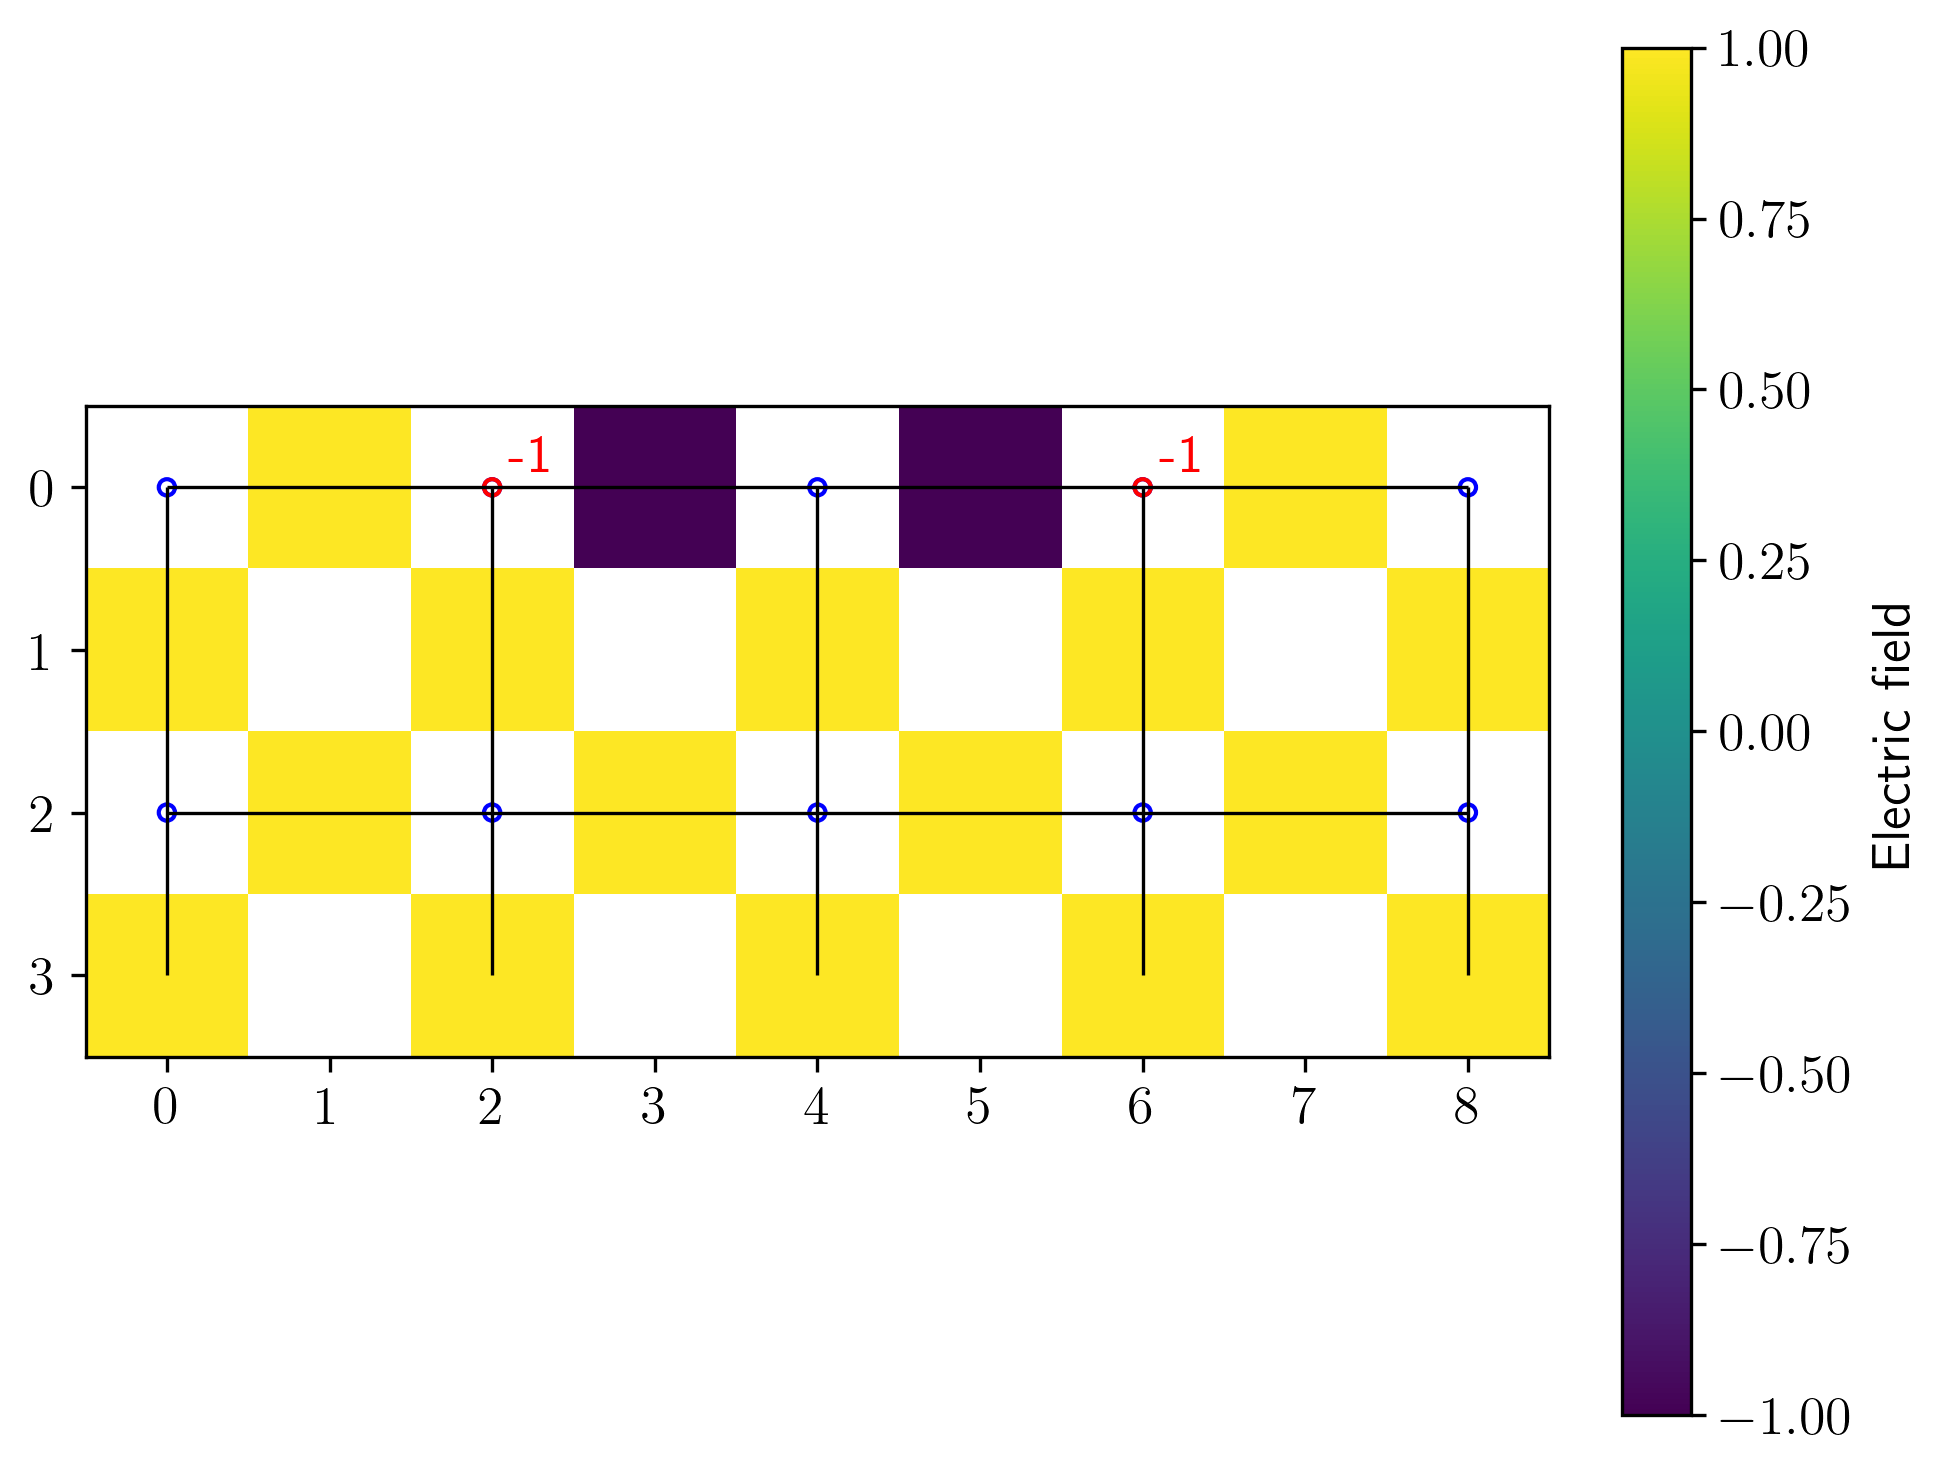

In [58]:
movie = anim(frames=steps+1, interval=200, data=e_field, params=np.linspace(0,steps*delta,steps+1), show=True, charges_x=cx, charges_y=cy, precision=2, time=True)
# movie.save(filename="quench_exact_test_1.gif")

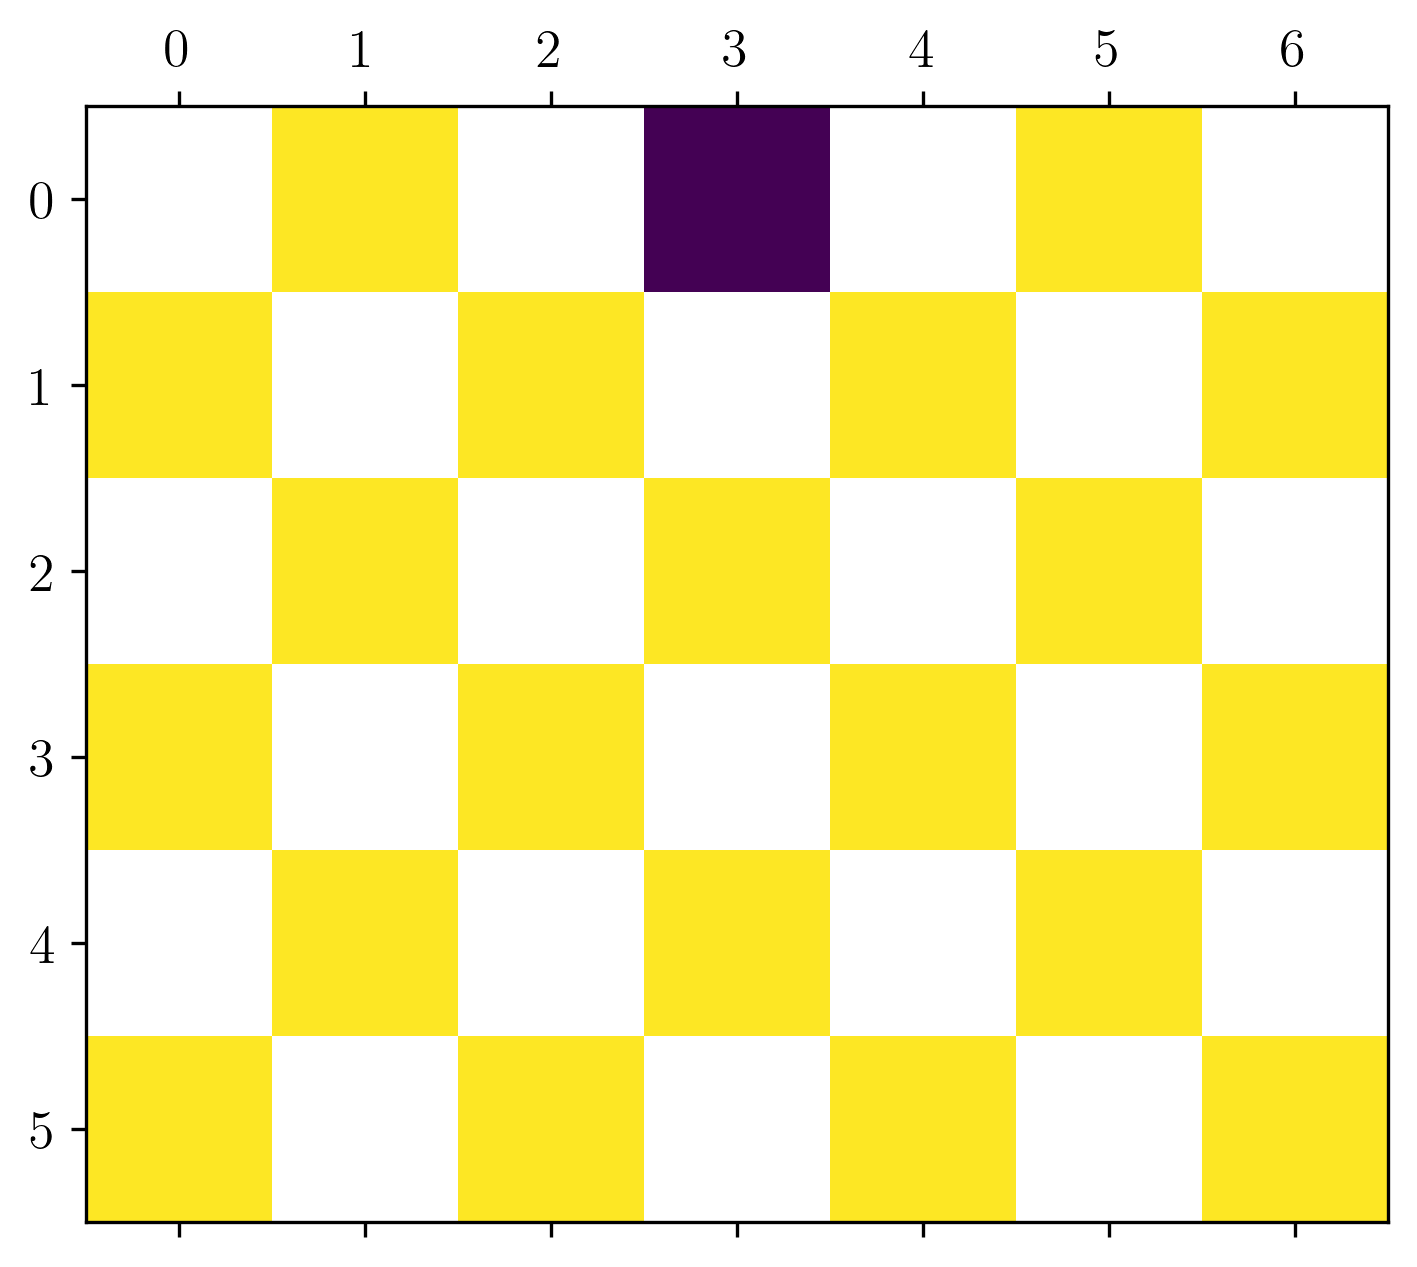

In [54]:
plt.matshow(e_field[-1], vmin=-1, vmax=1)

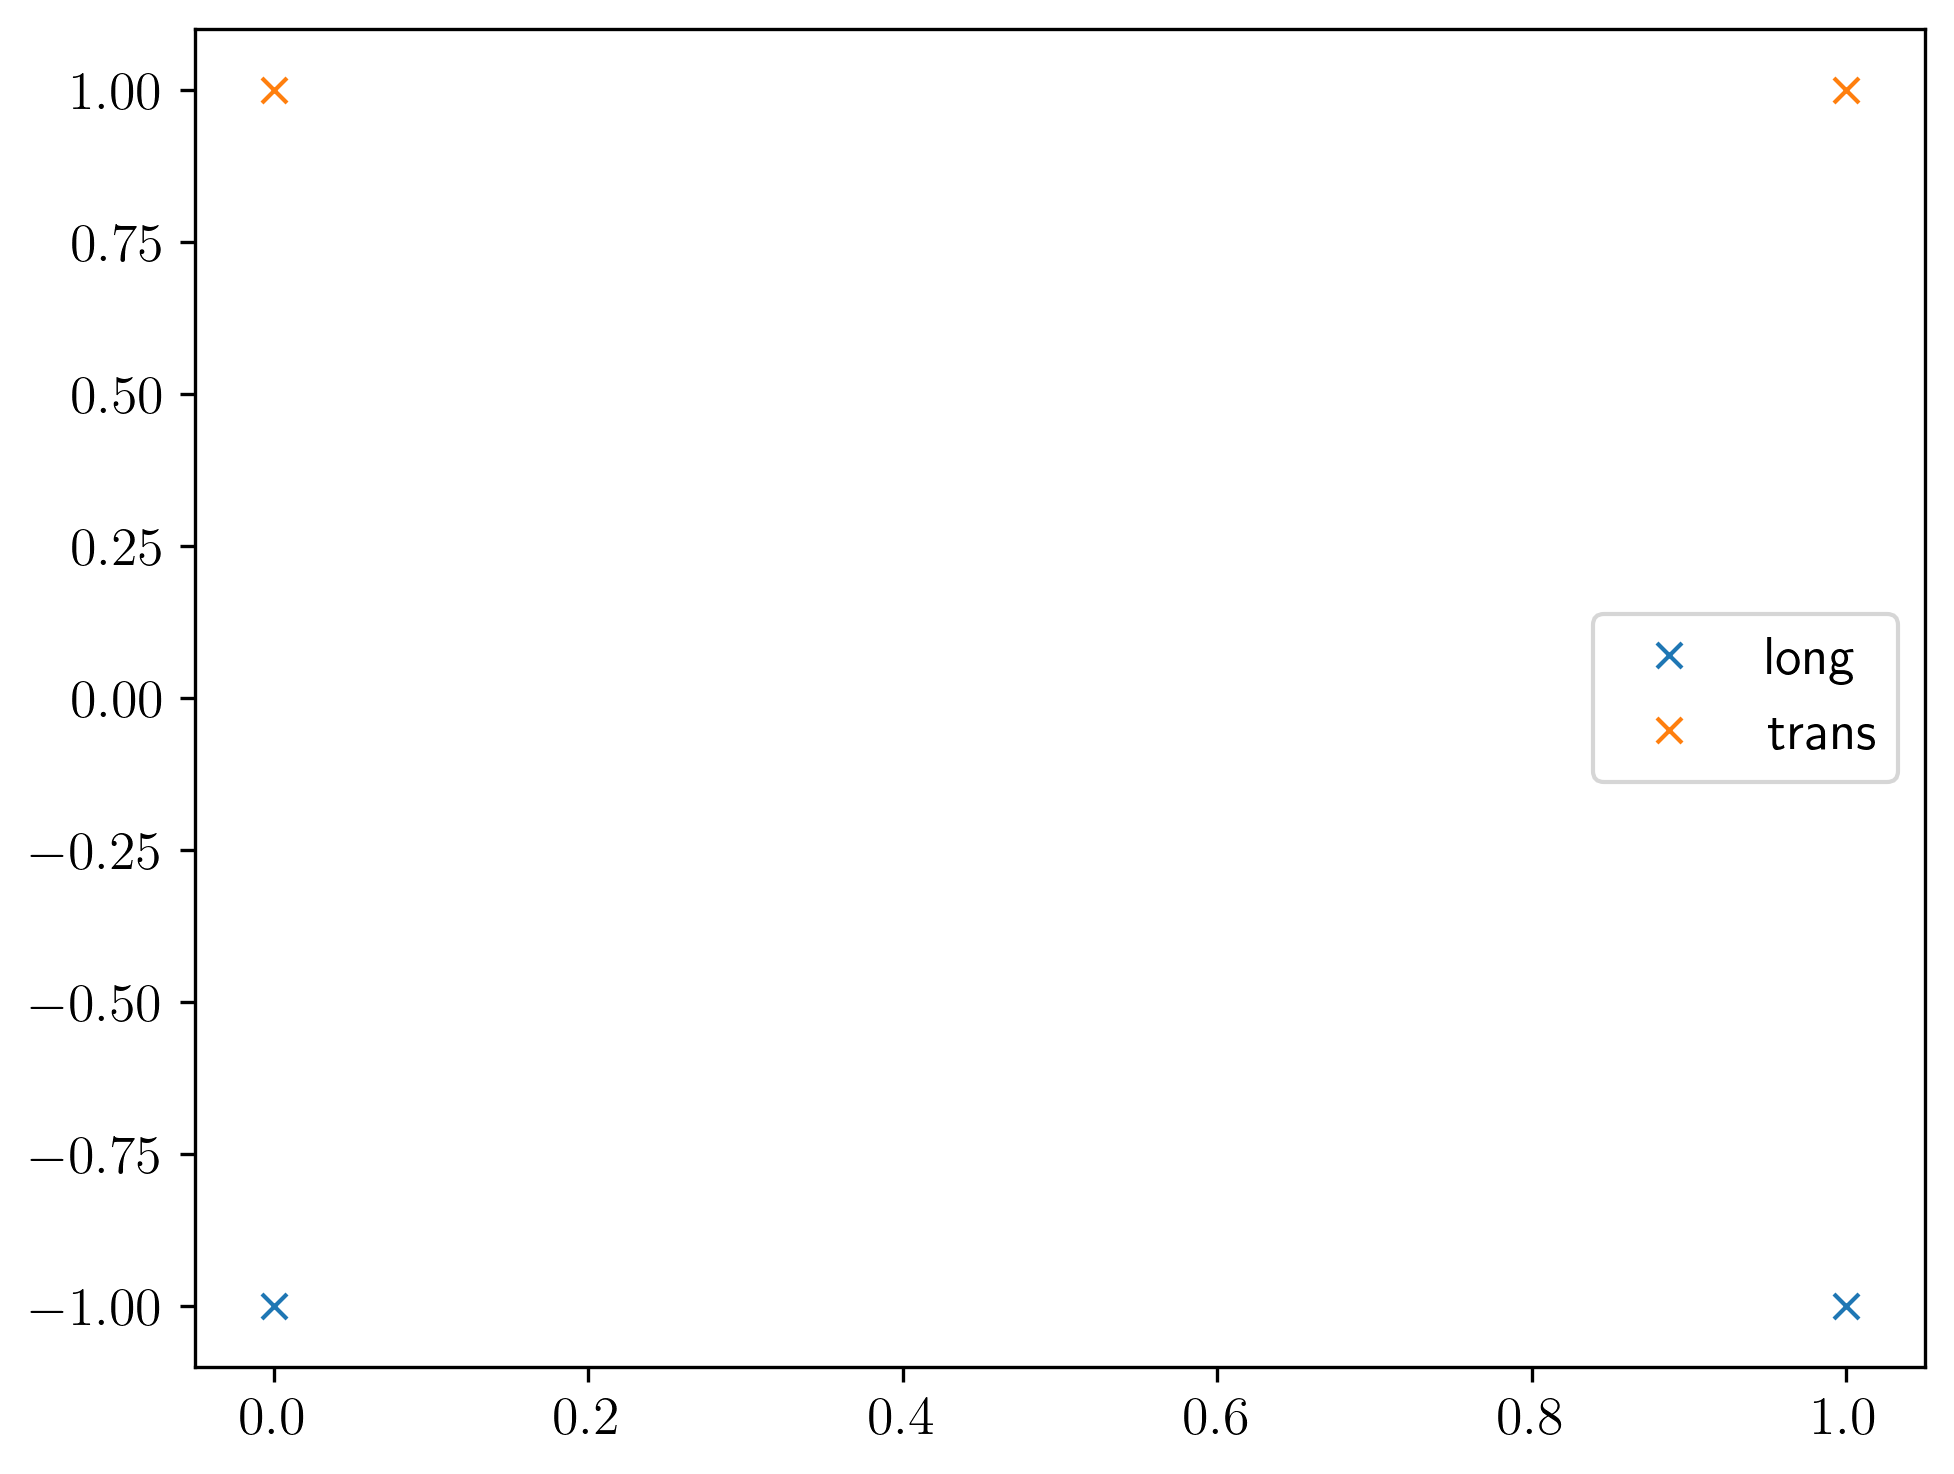

In [55]:
plt.plot([np.mean(e_field[i][0][1::2][cx[0]:cx[1]]) for i in range(steps)], 'x', label="long")
plt.plot([np.mean(e_field[i][1::2,0::2], axis=0)[(L+1)//2] for i in range(steps)], 'x', label="trans")
plt.legend()

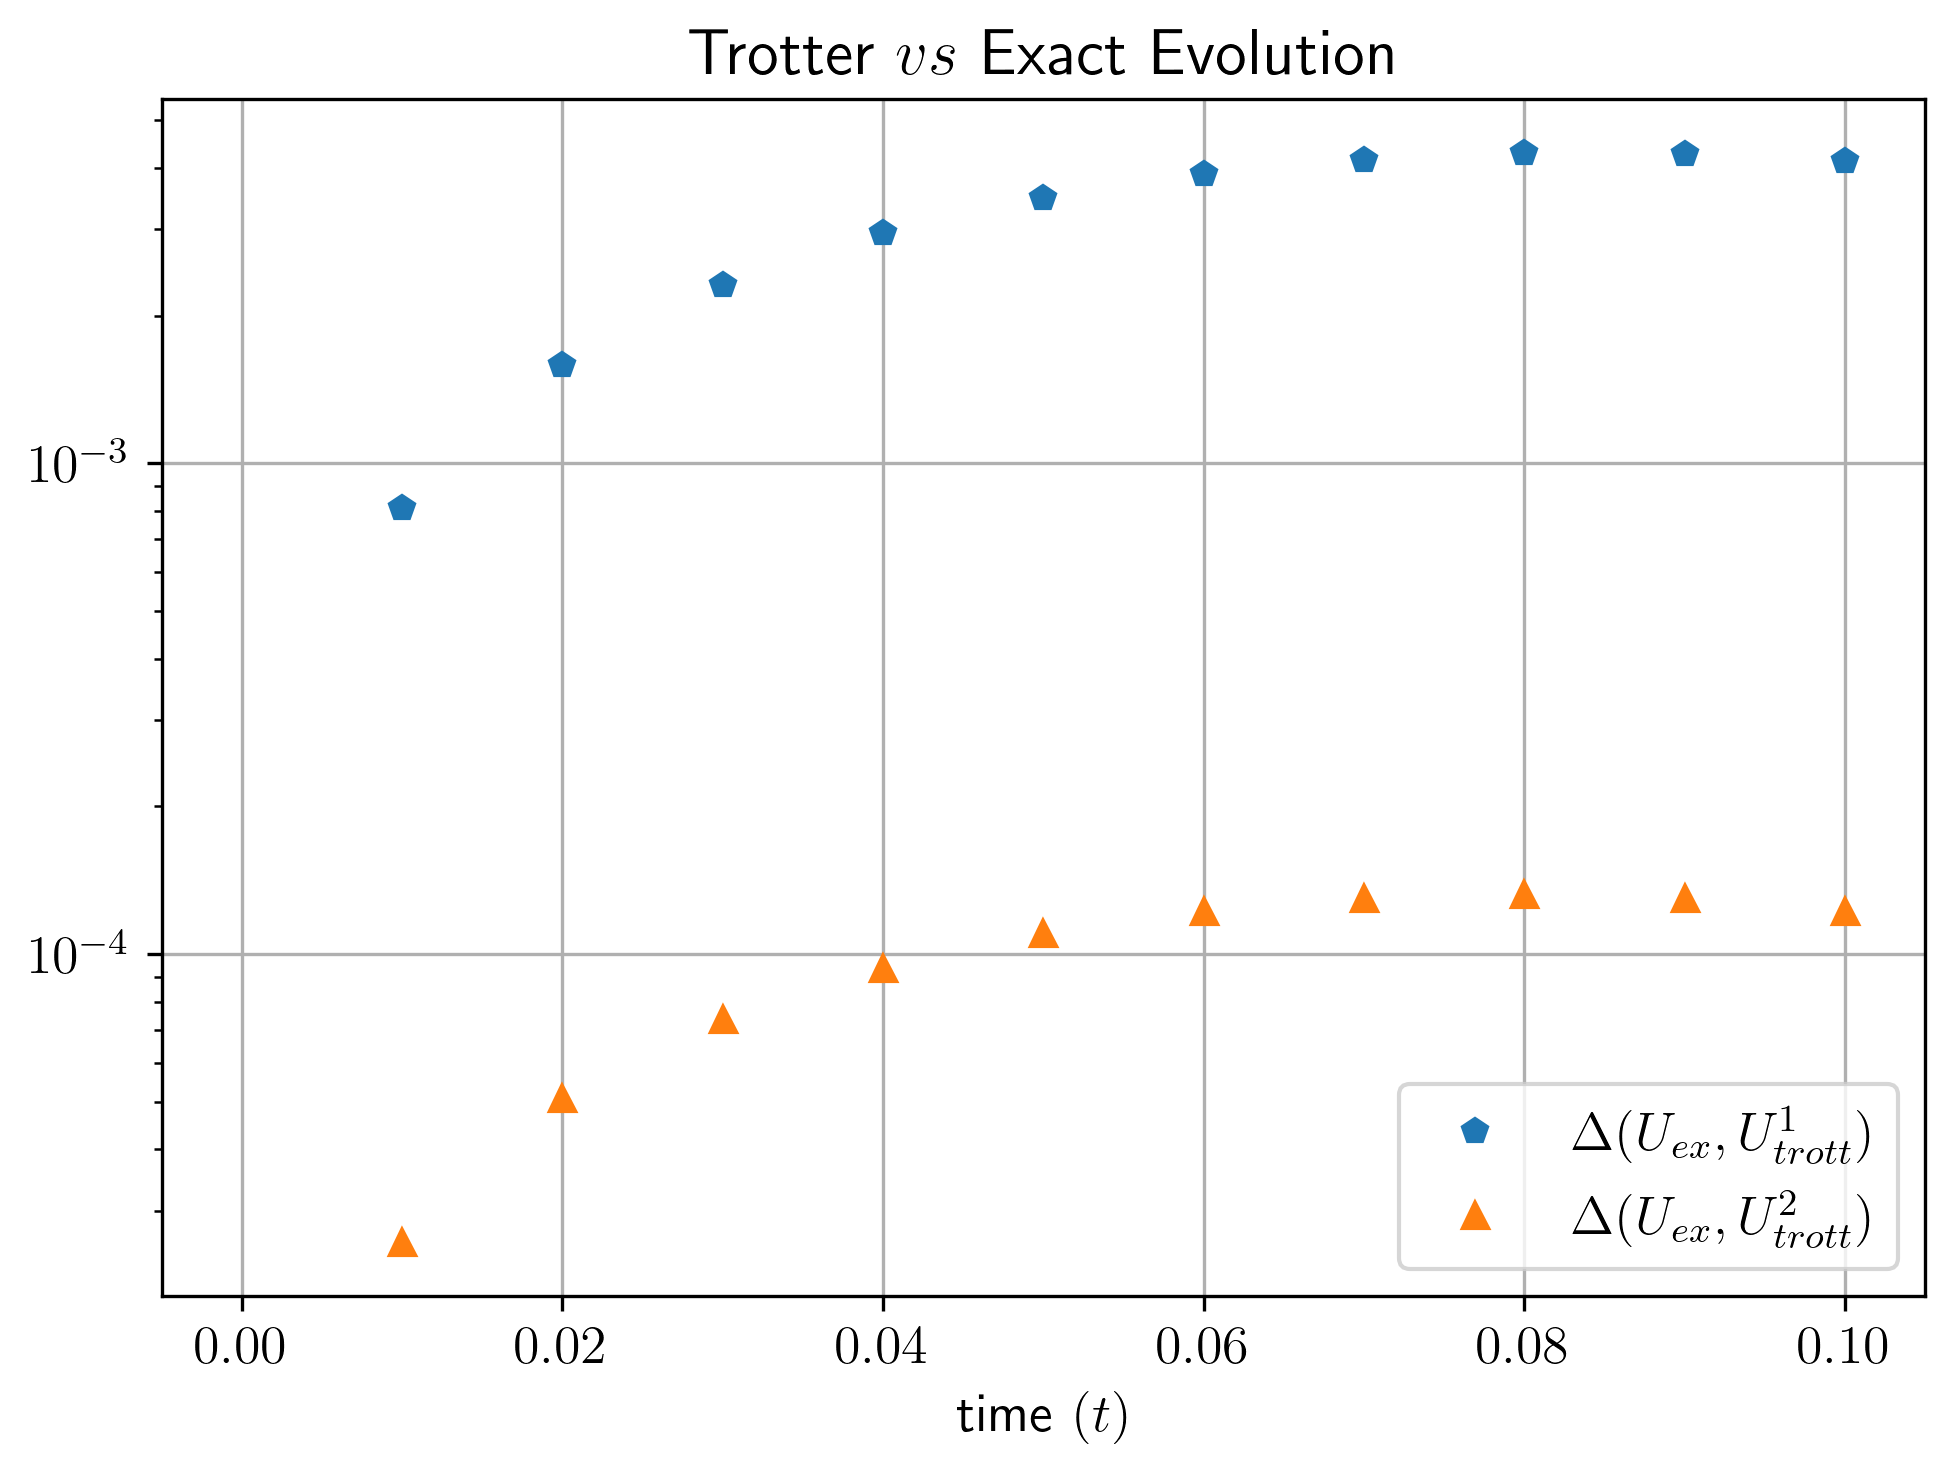

In [133]:
plt.plot(delta*np.asarray(range(steps+1)),diff1, marker="p", linestyle='', label="$\\Delta(U_{ex},U_{trott}^1)$")
plt.plot(delta*np.asarray(range(steps+1)),diff2, marker="^", linestyle='', label="$\\Delta (U_{ex},U_{trott}^2)$")
# plt.plot(range(1,steps),diff4, marker="+", label="$\\Delta (U_{ex},U_{trott}^4)$")
plt.title("Trotter $vs$ Exact Evolution")
plt.xlabel("time $(t)$")
# plt.xticks(ticks=delta*range(1,steps)[::(steps-1)//5], ticks=delta*range(1,steps)[::(steps-1)//5])
plt.legend()
plt.yscale('log')
plt.grid(True)
plt.show()

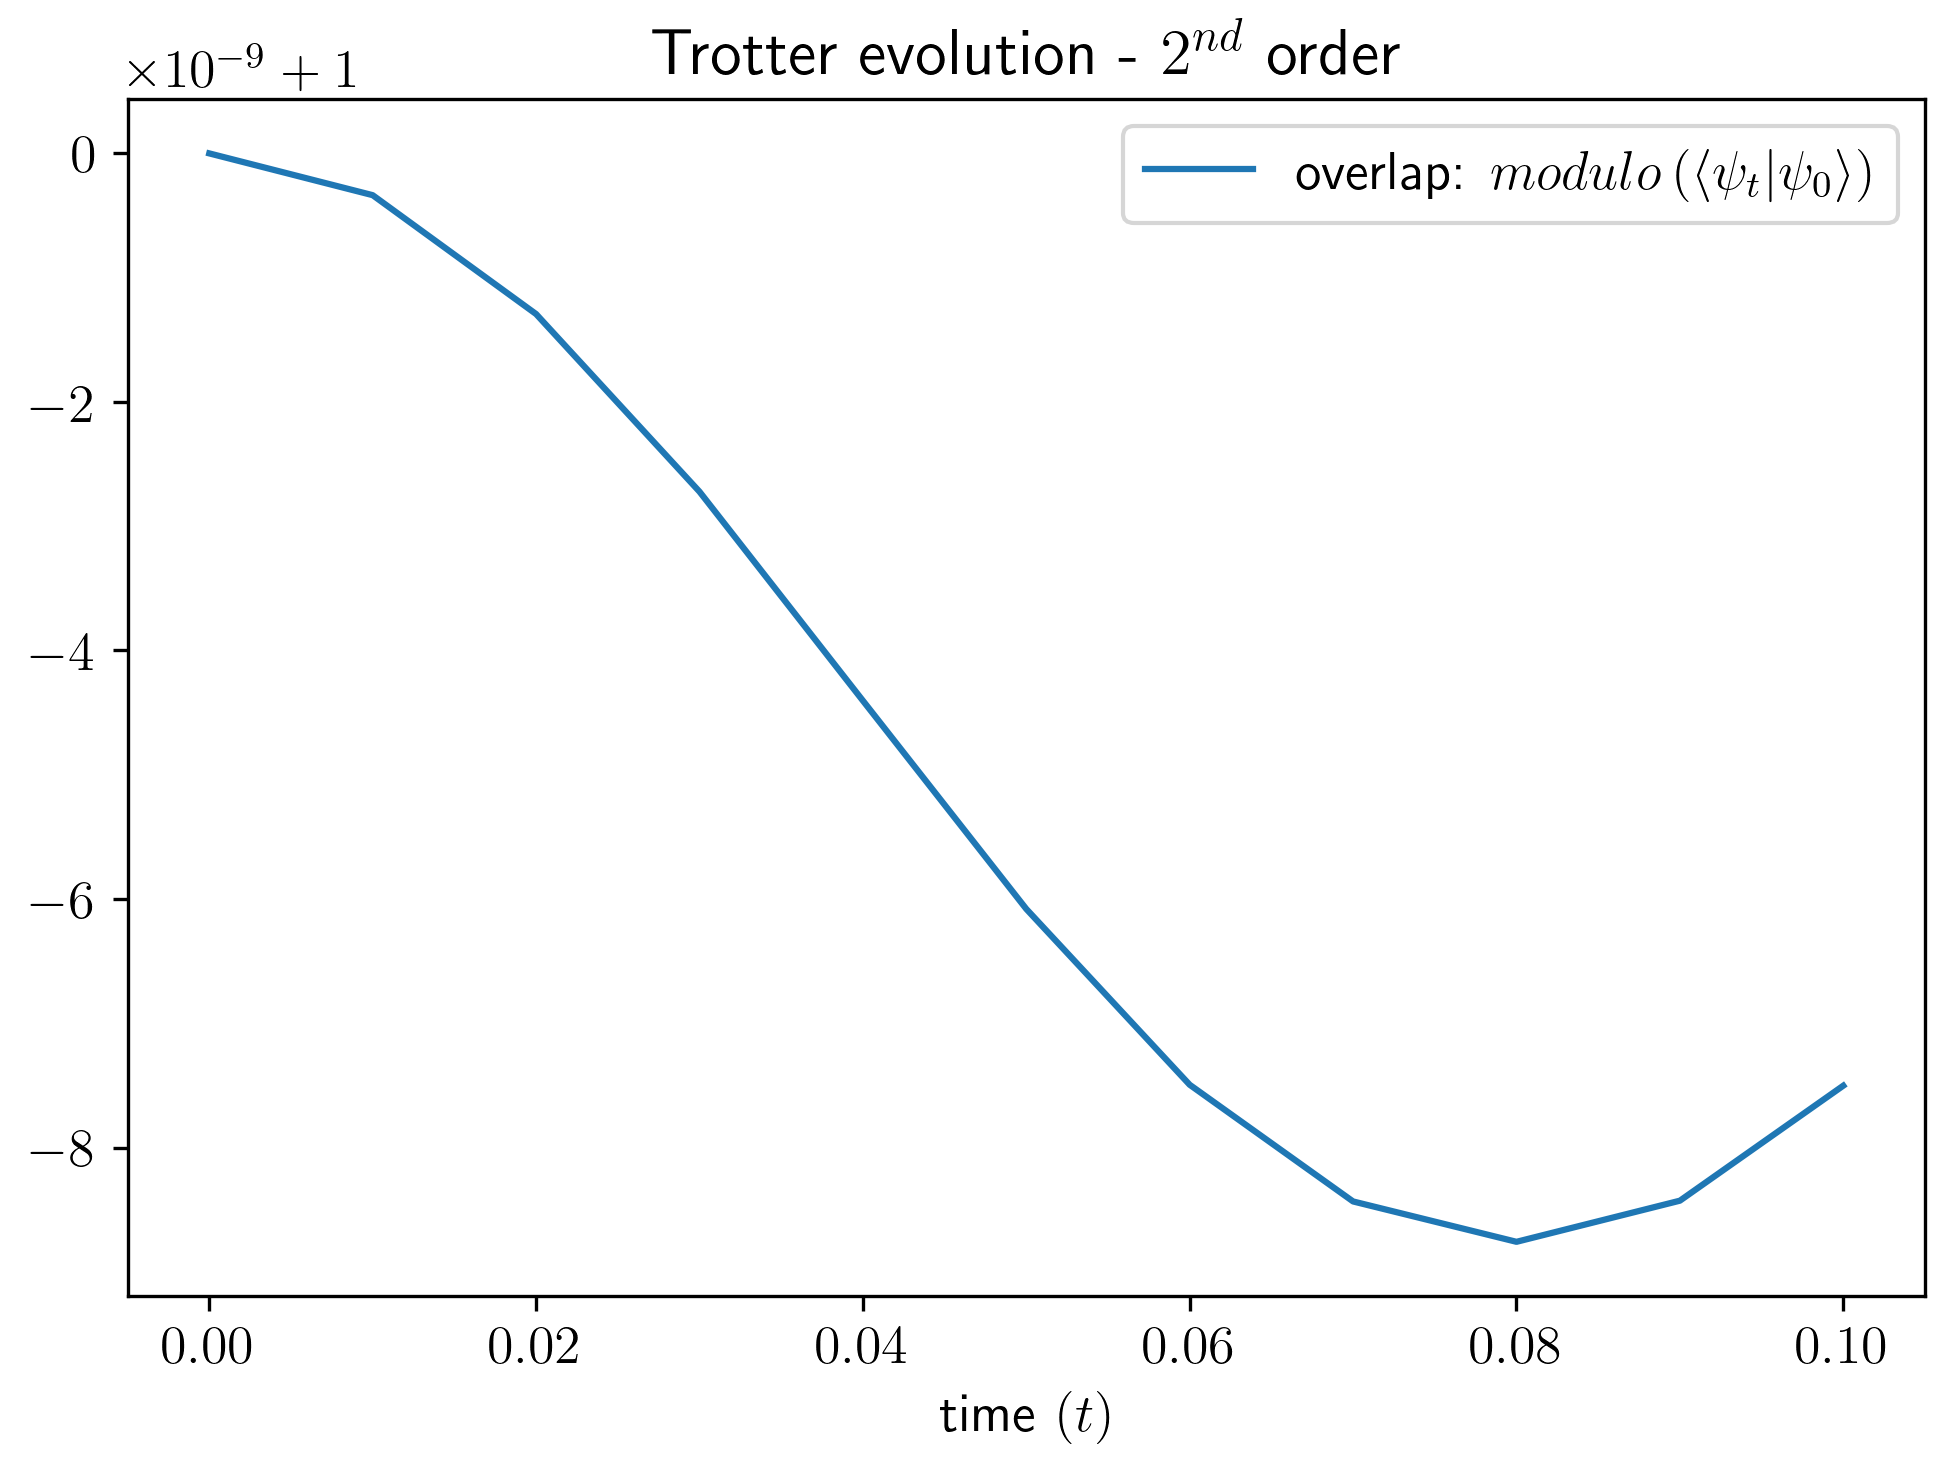

In [134]:
plt.plot(delta*np.asarray(range(steps+1)),[np.sqrt(ov.real**2 + ov.imag**2) for ov in overlap], label="overlap: $modulo \\left(\\langle \\psi_t | \\psi_0 \\rangle \\right)$")
plt.title("Trotter evolution - $2^{nd}$ order")
plt.xlabel("time $(t)$")
plt.legend()
plt.show()

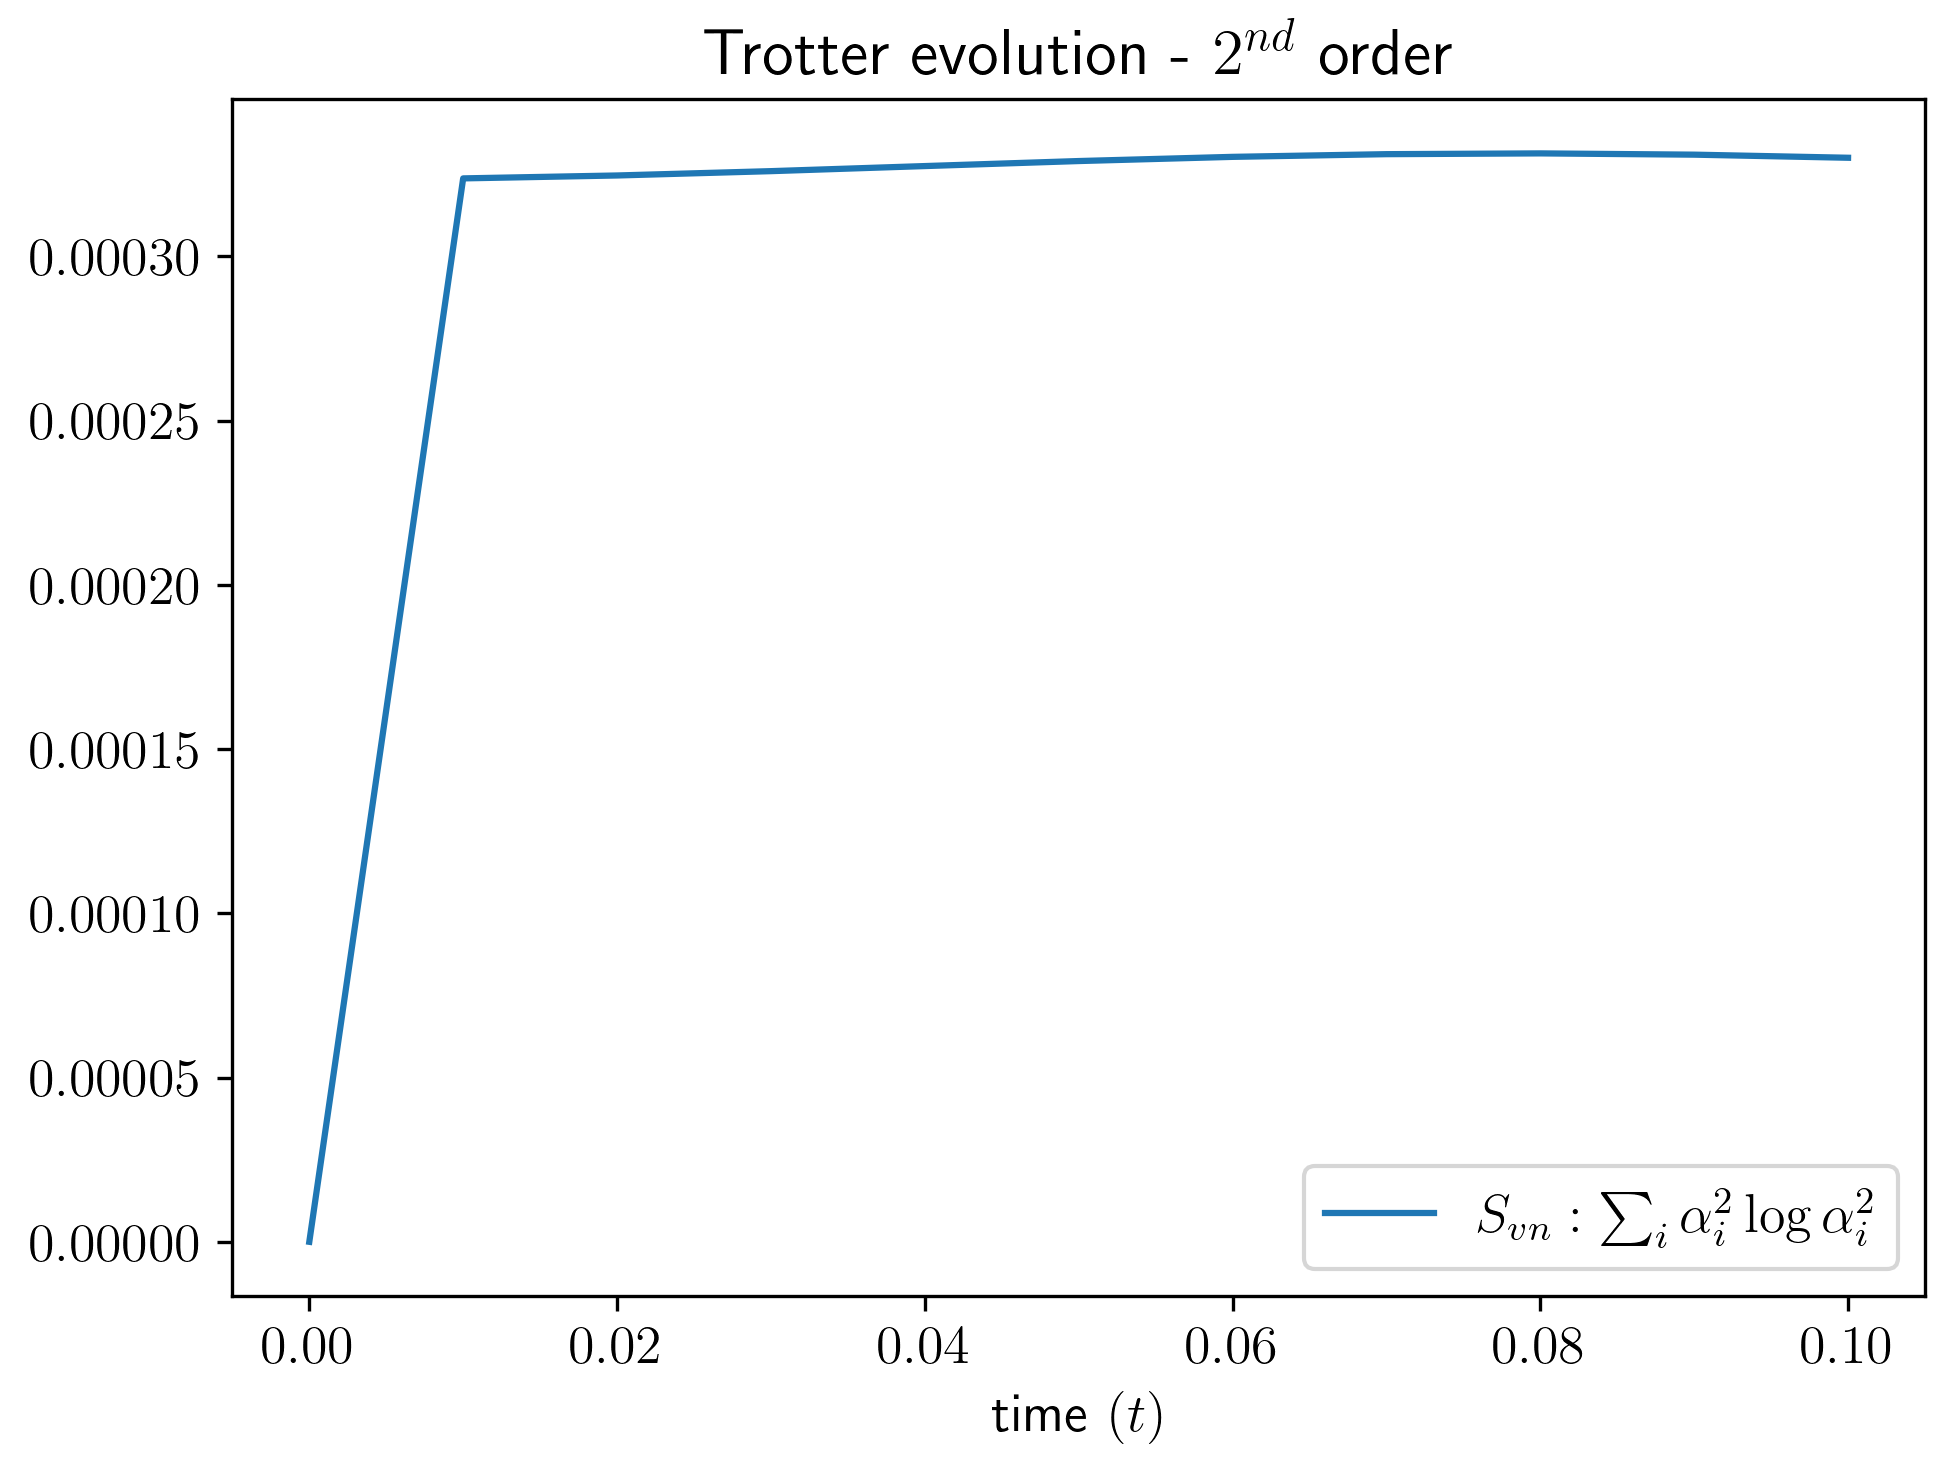

In [135]:
plt.plot(delta*np.asarray(range(steps+1)), entropy, label="$S_{vn}: \\sum_i \\alpha_i^2 \\log{\\alpha_i^2}$")
plt.title("Trotter evolution - $2^{nd}$ order")
plt.xlabel("time $(t)$")
plt.legend()
plt.show()

In [187]:
def get_psi_init(l, L, g, R, bc):
    if R == 0:
        cx, cy = None, None
    else:
        cx = get_cx(L=L,R=R)
        cy = get_cy(l=l,bc=bc)

    H_sc = dual_ham(l,L,g,cx,cy)
    e, psi0 = diagonalization(H_sc, sparse=False)
    psi0 = psi0[:,0]
    return psi0

def prepare_exact_ev(l, L, R, g_ev, final_time, steps, bc):
    if R == 0:
        cx, cy = None, None
    else:
        cx = get_cx(L=L,R=R)
        cy = get_cy(l=l,bc=bc)
    
    delta = final_time / steps

    U_base = expm(-1j*delta*dual_ham(l, L, g_ev, cx, cy))
    U_exact = U_base.copy()

    return U_base, U_exact

def prepare_trotter_ev(l, L, R, g_ev, final_time, steps, bc):
    if R == 0:
        cx, cy = None, None
    else:
        cx = get_cx(L=L,R=R)
        cy = get_cy(l=l,bc=bc)
    
    delta = final_time / steps

    U_trott2 = trott_Z2_dual(l, L, cx, cy, delta, coupling=g_ev, ord=2)
    return U_trott2

def evolve_psi(l, L, g, g_ev, R, R_ev, final_time, steps, bc):

    U_base, U_exact = prepare_exact_ev(l, L, R_ev, g_ev, final_time, steps, bc) 
    U_trott2 = prepare_trotter_ev(l, L, R_ev, g_ev, final_time, steps, bc) 
    psi0 = get_psi_init(l, L, g, R, bc)
    psi_ev_trott2 = psi0.copy()

    mps_ev = MPS(L=L, d=2**l, model="Z2_dual", chi=16)

    entropy_exact = []
    entropy_trotter = []
    trotter_error = []
    for T in range(steps):
        t = delta*(T+1)
        print(f"Evolution at time: {t}")
        
        psi_ev_ex = U_exact @ psi0
        U_exact = U_base @ U_exact

        psi_ev_trott2 = U_trott2 @ psi_ev_trott2

        eex = measure_entropy(mps_ev, psi_ev_ex)
        print(f"Exact entropy: {eex}")
        entropy_exact.append(eex)
        etr = measure_entropy(mps_ev, psi_ev_trott2)
        print(f"Trotter entropy: {etr}")
        entropy_trotter.append(etr)

        trotter_error.append(measure_overlap(psi_ev_ex, psi_ev_trott2))

    return entropy_exact, entropy_trotter, trotter_error

def measure_entropy(mps, vec, chi=64):
    mps.vector_to_mps(vec, chi)
    return von_neumann_entropy(mps.bonds[L//2])

def measure_overlap(vec1, vec2):
    return vec1.conjugate() @ vec2

In [ ]:
l, L = 3, 3
bc = "pbc"
steps = [10,20]
final_time = 0.5
g, g_ev = 0.1, 0.1
R, R_ev = 0, 0

ee_vac, etr_vac, trott_err_vac = [], [], []
for i,step in enumerate(steps):
    entropy_ex, entropy_trott, trott_err = evolve_psi(l, L, g, g_ev, R, R_ev, final_time, step, bc)
    ee_vac.append(entropy_ex)
    etr_vac.append(entropy_trott)
    trott_err_vac.append(trott_err)

R, R_ev = 0, 1

ee_R, etr_R, trott_err_R = [], [], []
for i,step in enumerate(steps):
    entropy_ex, entropy_trott, trott_err = evolve_psi(l, L, g, g_ev, R, R_ev, final_time, step, bc)
    ee_R.append(entropy_ex)
    etr_R.append(entropy_trott)
    trott_err_R.append(trott_err)

Evolution at time: 0.025
(1, 2, 2)
(2, 2, 4)
(4, 2, 8)
(8, 2, 16)
(16, 2, 32)
(32, 2, 16)
(16, 2, 8)
(8, 2, 4)
(4, 2, 2)
(2, 2, 1)
Exact entropy: -0.0
Trotter entropy: -0.0
Evolution at time: 0.05
Exact entropy: -0.0
Trotter entropy: -0.0
Evolution at time: 0.07500000000000001
Exact entropy: -0.0
Trotter entropy: -0.0
Evolution at time: 0.1
Exact entropy: -0.0
Trotter entropy: -0.0
Evolution at time: 0.125
Exact entropy: -0.0
Trotter entropy: -0.0
Evolution at time: 0.15000000000000002
Exact entropy: -0.0
Trotter entropy: -0.0
Evolution at time: 0.17500000000000002
Exact entropy: -0.0
Trotter entropy: -0.0
Evolution at time: 0.2
Exact entropy: -0.0
Trotter entropy: -0.0
Evolution at time: 0.225
Exact entropy: -0.0
Trotter entropy: -0.0
Evolution at time: 0.25
Exact entropy: -0.0
Trotter entropy: -0.0


<>:5: SyntaxWarning: invalid escape sequence '\d'
<>:5: SyntaxWarning: invalid escape sequence '\d'
/var/folders/d1/c6hqhfn161x458f4d0m3_rm80000gp/T/ipykernel_57996/3200304171.py:5: SyntaxWarning: invalid escape sequence '\d'
  plt.plot(delta*np.asarray(range(step)), entropy_trott_vac, color=colors[i], label=f"trott vac $\delta: {delta}$", zorder=1+i)


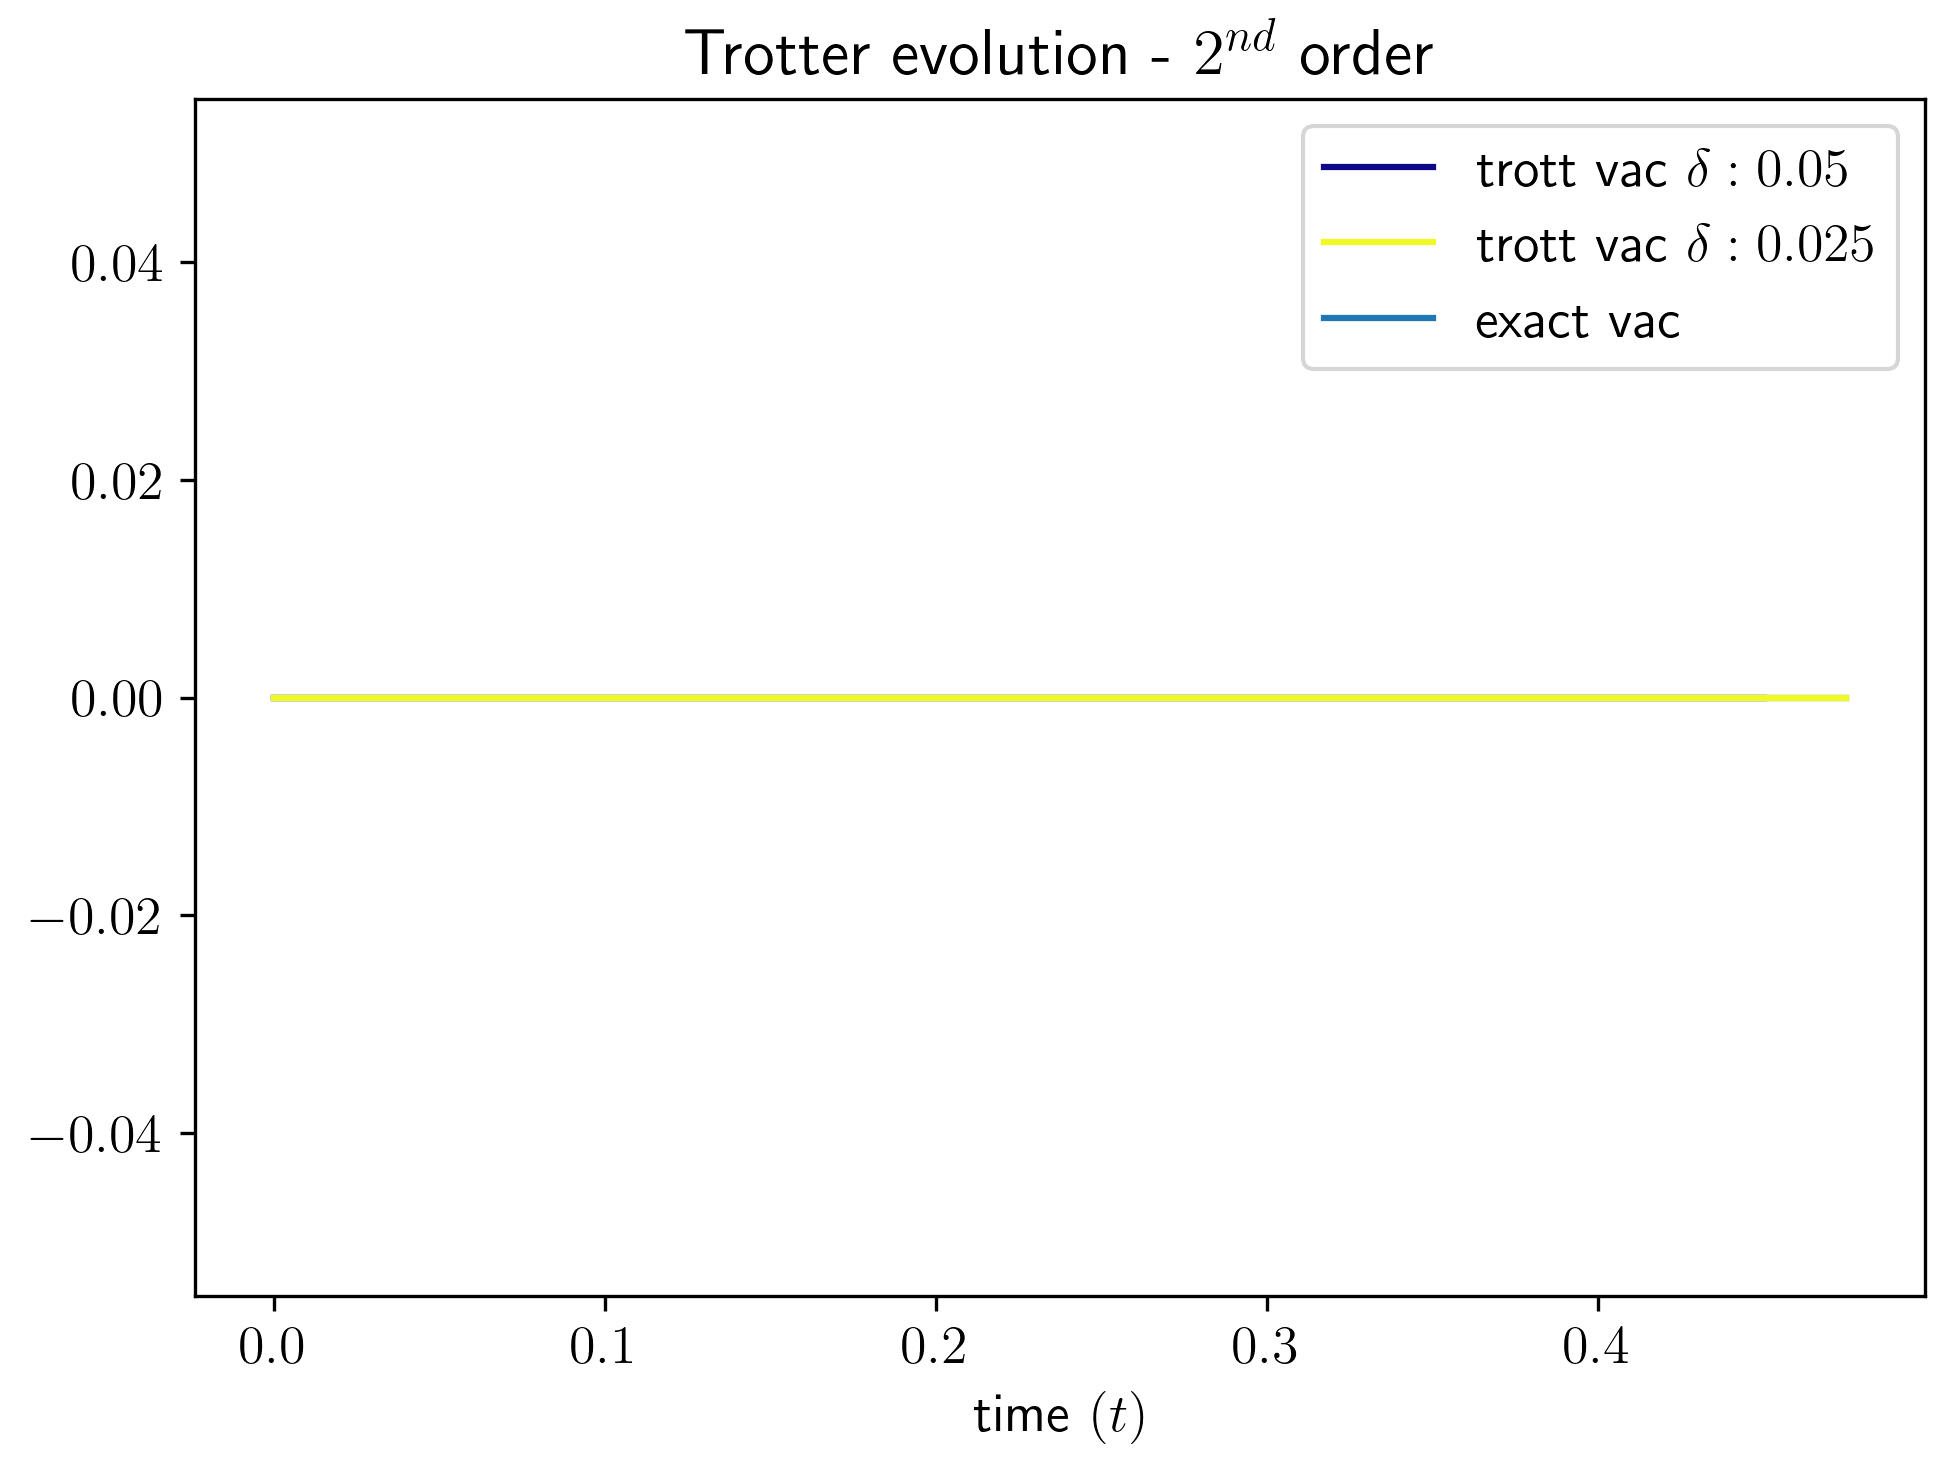

In [ ]:
colors = create_sequential_colors(num_colors=len(steps), colormap_name='plasma')
i = 0
for entropy_ex_vac, entropy_trott_vac, entropy_ex_R, entropy_trott_R, step in zip(ee_vac, etr_vac, ee_R, etr_R, steps):
    delta = final_time / step
    plt.plot(delta*np.asarray(range(step)), entropy_trott_vac, color=colors[i], label=f"trott vac $\delta: {delta}$", zorder=1+i)
    # plt.plot(delta*np.asarray(range(step)), entropy_trott_R, color=colors[i], linestyle="--", label=f"trott R $\delta: {delta}$", zorder=1+i)
    i += 1
plt.plot(delta*np.asarray(range(step)), entropy_ex_vac, label=f"exact vac", zorder=1)
# plt.plot(delta*np.asarray(range(step)), entropy_ex_R, linestyle="--", label=f"exact R", zorder=1)
plt.title("Trotter evolution - $2^{nd}$ order")
plt.xlabel("time $(t)$")
plt.legend()
# plt.yscale("log")
plt.show()


<>:5: SyntaxWarning: invalid escape sequence '\d'
<>:6: SyntaxWarning: invalid escape sequence '\d'
<>:5: SyntaxWarning: invalid escape sequence '\d'
<>:6: SyntaxWarning: invalid escape sequence '\d'
/var/folders/d1/c6hqhfn161x458f4d0m3_rm80000gp/T/ipykernel_57996/1636937214.py:5: SyntaxWarning: invalid escape sequence '\d'
  plt.plot(delta*np.asarray(range(step)), trott_vac, color=colors[i], alpha=0.8, label=f"trott vac $\delta: {delta}$", zorder=1+i)
/var/folders/d1/c6hqhfn161x458f4d0m3_rm80000gp/T/ipykernel_57996/1636937214.py:6: SyntaxWarning: invalid escape sequence '\d'
  plt.plot(delta*np.asarray(range(step)), trott_R, color=colors[i], linestyle="--", label=f"trott R $\delta: {delta}$", zorder=1+i)
/Users/fradm/.conda/envs/qsmps/lib/python3.12/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/fradm/.conda/envs/qsmps/lib/python3.12/site-packages/matplotlib/cbook.py:1398: ComplexWar

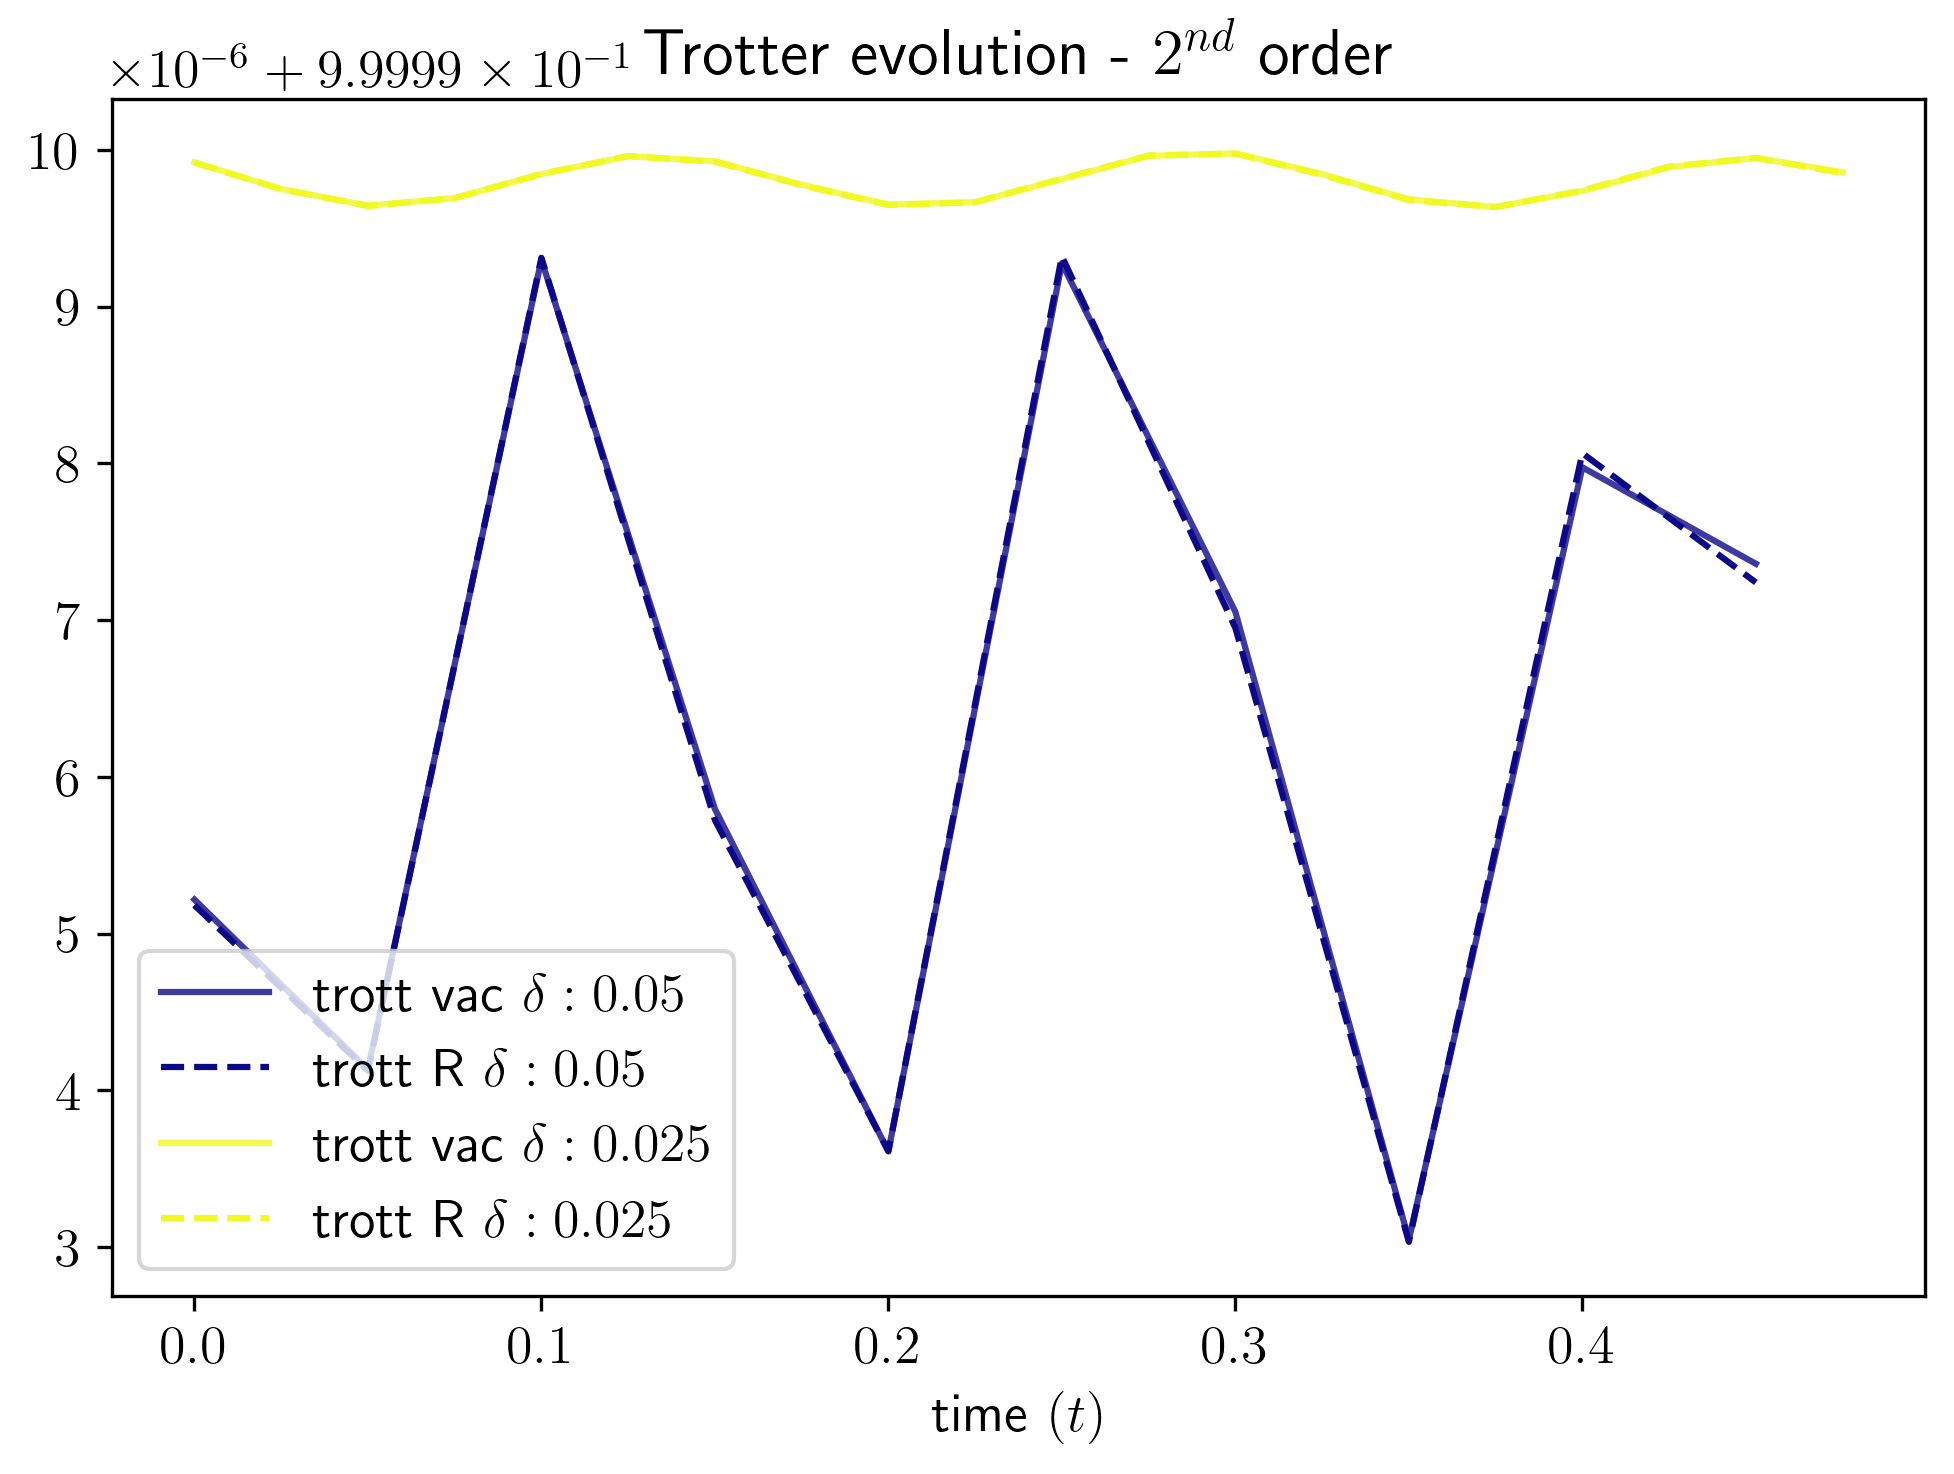

In [ ]:
colors = create_sequential_colors(num_colors=len(steps), colormap_name='plasma')
i = 0
for trott_vac, trott_R, step in zip(trott_err_vac, trott_err_R, steps):
    delta = final_time / step
    plt.plot(delta*np.asarray(range(step)), trott_vac, color=colors[i], alpha=0.8, label=f"trott vac $\delta: {delta}$", zorder=1+i)
    plt.plot(delta*np.asarray(range(step)), trott_R, color=colors[i], linestyle="--", label=f"trott R $\delta: {delta}$", zorder=1+i)
    i += 1
# plt.plot(delta*np.asarray(range(step)), entropy_ex_R, linestyle="--", label=f"exact R", zorder=1)
plt.title("Trotter evolution - $2^{nd}$ order")
plt.xlabel("time $(t)$")
plt.legend()
# plt.yscale("log")
plt.show()

## Debug interaction terms

In [112]:
from qs_mps.mpo_class import MPO_ladder as MPO

delta = 0.01
g_ev = 0.7
l = 2
L = 3
bc = "pbc"
R = 1
cx = get_cx(L,R)
cy = get_cy(l,bc)
dof = l*L + 1
O = csc_array((2**dof, 2**dof), dtype=complex)
Ol = csc_array((2**l, 2**l), dtype=complex)
I = identity(2**l, dtype=complex).toarray()

# charges
charges = np.ones((l,L+1))
if cx is not None:
    charges[cy[0],cx[0]] = -1
    charges[cy[1],cx[1]] = -1

prod_charges = np.prod(charges, axis=1).tolist()


### Debug vertical left links

In [113]:
H_sigmas = O
# first column of sigmas are local
for j in range(l):
    H_sigmas += sparse_pauli_z(n=j, L=dof)

U_vel = evolution_operator(delta=delta*(-g_ev), hamiltonian=H_sigmas)

In [114]:
matrix_mpo_vel = identity(2**dof, dtype=complex).toarray()
Z2 = np.array([[1.+0.j, 0.+0.j],[0.+0.j, -1.+0.j]])
X_basis = np.array([[0,1],[1,0]])
print(matrix_mpo_vel.shape)
mpo_lad = MPO(l=l, L=L, model="Z2_dual", bc="pbc")

for lad in range(l):
    w_tot = []
    for mpo_site in range(L):
        print(f"site: {mpo_site}, ladder: {lad}")
        Z = sparse_pauli_z(n=lad, L=l).toarray()
        
        mpo_lad.mpo_skeleton(aux_dim=2)
        if mpo_site == 0:
            # vertical links left edge - local and even terms
            w_loc_le = expm(1j * g_ev * delta * Z)
            mpo_lad.mpo[0,-1] = w_loc_le

        w_tot.append(mpo_lad.mpo.copy())
    
    I2 = np.eye(2)
    O2 = np.zeros((2,2))
    # w_l = np.array([[O2],[X_basis]])
    w_l = np.array([[O2],[I2]])
    w_tot.append(w_l)
    tensor_shapes(w_tot)
    matrix_lad = mpo_to_matrix(w_tot)
    matrix_mpo_vel = matrix_mpo_vel @ matrix_lad

(128, 128)
site: 0, ladder: 0
site: 1, ladder: 0
site: 2, ladder: 0
(2, 2, 4, 4)
(2, 2, 4, 4)
(2, 2, 4, 4)
(2, 1, 2, 2)
site: 0, ladder: 1
site: 1, ladder: 1
site: 2, ladder: 1
(2, 2, 4, 4)
(2, 2, 4, 4)
(2, 2, 4, 4)
(2, 1, 2, 2)


In [115]:
(U_vel.conjugate().T @ matrix_mpo_vel).nonzero()

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127]),
 array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  

In [116]:
[(U_vel.conjugate().T @ matrix_mpo_vel)[i,i] for i in range(2**dof)]

[(1+3.469446951953614e-18j),
 (1+3.469446951953614e-18j),
 (1+3.469446951953614e-18j),
 (1+3.469446951953614e-18j),
 (1+3.469446951953614e-18j),
 (1+3.469446951953614e-18j),
 (1+3.469446951953614e-18j),
 (1+3.469446951953614e-18j),
 (1+3.469446951953614e-18j),
 (1+3.469446951953614e-18j),
 (1+3.469446951953614e-18j),
 (1+3.469446951953614e-18j),
 (1+3.469446951953614e-18j),
 (1+3.469446951953614e-18j),
 (1+3.469446951953614e-18j),
 (1+3.469446951953614e-18j),
 (1+3.469446951953614e-18j),
 (1+3.469446951953614e-18j),
 (1+3.469446951953614e-18j),
 (1+3.469446951953614e-18j),
 (1+3.469446951953614e-18j),
 (1+3.469446951953614e-18j),
 (1+3.469446951953614e-18j),
 (1+3.469446951953614e-18j),
 (1+3.469446951953614e-18j),
 (1+3.469446951953614e-18j),
 (1+3.469446951953614e-18j),
 (1+3.469446951953614e-18j),
 (1+3.469446951953614e-18j),
 (1+3.469446951953614e-18j),
 (1+3.469446951953614e-18j),
 (1+3.469446951953614e-18j),
 (0.9999999999999999+0j),
 (0.9999999999999999+0j),
 (0.9999999999999999

### Debug horizontal bulk links

In [117]:
H_taus = O
# vertical zz interactions 
for j in range(l):
    for i in range(L):
        # coeff = charge_func(i,j,l,cx,cy)
        # H_taus += coeff * sparse_pauli_z(n=j*L+i, L=dof) @ sparse_pauli_z(n=((j+1)%l)*L+i, L=dof)
        print(f"site: {i}, ladder: {j}")
        coeff = np.prod(charges[(j+1)%l,:(i+1)])
        print(coeff)
        H_taus += np.prod(charges[(j+1)%l,:(i+1)]) * sparse_pauli_z(n=j+i*l, L=dof) @ sparse_pauli_z(n=((j+1)%l)+i*l, L=dof)

U_hob = evolution_operator(delta=delta*(-g_ev), hamiltonian=H_taus)

site: 0, ladder: 0
1.0
site: 1, ladder: 0
1.0
site: 2, ladder: 0
1.0
site: 0, ladder: 1
1.0
site: 1, ladder: 1
-1.0
site: 2, ladder: 1
1.0


In [118]:
matrix_mpo_hob = identity(2**dof, dtype=complex).toarray()
print(matrix_mpo_hob.shape)
X_basis = np.array([[0,1],[1,0]])
mpo_lad = MPO(l=l, L=L, model="Z2_dual", bc="pbc")

for lad in range(l):
    w_tot = []
    for mpo_site in range(L):
        print(f"site: {mpo_site}, ladder: {lad}")
        
        mpo_lad.mpo_skeleton(aux_dim=1)
        # mpo_lad.mpo_skeleton(aux_dim=2)
        # horizontal links bulk - local terms
        coeff = np.prod(charges[(lad + 1) % l, : mpo_site + 1])
        print(coeff)
        Z_ll = coeff * (
            sparse_pauli_z(n=lad, L=mpo_lad.l) @ sparse_pauli_z(n=(lad + 1) % mpo_lad.l, L=mpo_lad.l)
        ).toarray()
        w_int_loc = expm(1j * g_ev * delta * Z_ll)
        # if mpo_site == 0:
        #     mpo_lad.mpo[0,-1] = w_int_loc
        # else:
        #     mpo_lad.mpo[-1,-1] = w_int_loc
        mpo_lad.mpo[0,0] = w_int_loc

        w_tot.append(mpo_lad.mpo.copy())
    
    I2 = np.eye(2)
    O2 = np.zeros((2,2))
    # w_l = np.array([[O2],[X_basis]])
    w_l = np.array([[I2]])
    w_tot.append(w_l)
    tensor_shapes(w_tot)
    matrix_lad = mpo_to_matrix(w_tot)
    matrix_mpo_hob = matrix_mpo_hob @ matrix_lad

(128, 128)
site: 0, ladder: 0
1.0
site: 1, ladder: 0
1.0
site: 2, ladder: 0
1.0
(1, 1, 4, 4)
(1, 1, 4, 4)
(1, 1, 4, 4)
(1, 1, 2, 2)
site: 0, ladder: 1
1.0
site: 1, ladder: 1
-1.0
site: 2, ladder: 1
1.0
(1, 1, 4, 4)
(1, 1, 4, 4)
(1, 1, 4, 4)
(1, 1, 2, 2)


In [119]:
(U_hob.conjugate().T @ matrix_mpo_hob).nonzero()

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127]),
 array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  

In [120]:
[(U_hob.conjugate().T @ matrix_mpo_hob)[i,i] for i in range(2**dof)] 


[(0.9999999999999996-3.469446951953614e-18j),
 (0.9999999999999996-3.469446951953614e-18j),
 (0.9999999999999996+8.673617379884035e-19j),
 (0.9999999999999996+8.673617379884035e-19j),
 (0.9999999999999996+8.673617379884035e-19j),
 (0.9999999999999996+8.673617379884035e-19j),
 (0.9999999999999996-3.469446951953614e-18j),
 (0.9999999999999996-3.469446951953614e-18j),
 (0.9999999999999996-3.469446951953614e-18j),
 (0.9999999999999996-3.469446951953614e-18j),
 (0.9999999999999996+8.673617379884035e-19j),
 (0.9999999999999996+8.673617379884035e-19j),
 (0.9999999999999996+8.673617379884035e-19j),
 (0.9999999999999996+8.673617379884035e-19j),
 (0.9999999999999996-3.469446951953614e-18j),
 (0.9999999999999996-3.469446951953614e-18j),
 (0.9999999999999996-3.469446951953614e-18j),
 (0.9999999999999996-3.469446951953614e-18j),
 (0.9999999999999996+8.673617379884035e-19j),
 (0.9999999999999996+8.673617379884035e-19j),
 (0.9999999999999996+8.673617379884035e-19j),
 (0.9999999999999996+8.67361737988

### Debug vertical right links

In [121]:
H_sigmas = O
# horizontal zz interactions, last column of sigmas
for j in range(l):
    # H_sigmas += sparse_pauli_z(n=j*L+L-1, L=dof) @ sparse_pauli_z(n=l*L, L=dof)
    H_sigmas += np.prod(prod_charges[:(j+1)]) * sparse_pauli_z(n=j+(L-1)*l, L=dof) @ sparse_pauli_z(n=l*L, L=dof)

U_ver = evolution_operator(delta=delta*(-g_ev), hamiltonian=H_sigmas)

In [122]:
matrix_mpo_ver = identity(2**dof, dtype=complex).toarray()
print(matrix_mpo_ver.shape)

mpo_lad = MPO(l=l, L=L, model="Z2_dual", bc="pbc")

# vertical links right edge - odd term (ancillary site)
Z2 = sparse_pauli_z(n=0, L=1).toarray()
I2 = identity(2, dtype=complex).toarray()

w_odd_re = np.array(
        [
            [ 
                np.sqrt(np.cos(g_ev * delta)) * I2,
            ],
            [
                np.sqrt(np.sin(g_ev * delta)) * Z2,
            ]
        ]
    )

for lad in range(l):
    w_tot = []
    for mpo_site in range(L):
        print(f"site: {mpo_site}, ladder: {lad}")
        Z = sparse_pauli_z(n=lad, L=l).toarray()
        
        # mpo_lad.mpo_skeleton(aux_dim=2)
        mpo_lad.mpo_skeleton(aux_dim=1)
        if mpo_site == L-1:
            w_even_re = np.array(
                            [
                                [
                                    np.sqrt(np.cos(g_ev * delta)) * I,
                                    1j
                                    * np.sqrt(np.sin(g_ev * delta))
                                    * Z,
                                ],
                            ]
                        )
            w_tot.append(w_even_re)
        else:
            w_tot.append(mpo_lad.mpo.copy())
    
    w_tot.append(w_odd_re)
    matrix_lad = mpo_to_matrix(w_tot)
    matrix_mpo_ver = matrix_mpo_ver @ matrix_lad
tensor_shapes(w_tot)

(128, 128)
site: 0, ladder: 0
site: 1, ladder: 0
site: 2, ladder: 0
site: 0, ladder: 1
site: 1, ladder: 1
site: 2, ladder: 1
(1, 1, 4, 4)
(1, 1, 4, 4)
(1, 2, 4, 4)
(2, 1, 2, 2)


[(1, 1, 4, 4), (1, 1, 4, 4), (1, 2, 4, 4), (2, 1, 2, 2)]

In [123]:
(U_ver.conjugate().T @ matrix_mpo_ver).nonzero()

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127]),
 array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  

In [124]:
[(U_ver.conjugate().T @ matrix_mpo_ver)[i,i] for i in range(2**dof)]

[(1+5.204170427930421e-18j),
 (1-5.204170427930421e-18j),
 (0.9999999999999999+0j),
 (0.9999999999999999+0j),
 (0.9999999999999999+0j),
 (0.9999999999999999+0j),
 (1-5.204170427930421e-18j),
 (1+5.204170427930421e-18j),
 (1+5.204170427930421e-18j),
 (1-5.204170427930421e-18j),
 (0.9999999999999999+0j),
 (0.9999999999999999+0j),
 (0.9999999999999999+0j),
 (0.9999999999999999+0j),
 (1-5.204170427930421e-18j),
 (1+5.204170427930421e-18j),
 (1+5.204170427930421e-18j),
 (1-5.204170427930421e-18j),
 (0.9999999999999999+0j),
 (0.9999999999999999+0j),
 (0.9999999999999999+0j),
 (0.9999999999999999+0j),
 (1-5.204170427930421e-18j),
 (1+5.204170427930421e-18j),
 (1+5.204170427930421e-18j),
 (1-5.204170427930421e-18j),
 (0.9999999999999999+0j),
 (0.9999999999999999+0j),
 (0.9999999999999999+0j),
 (0.9999999999999999+0j),
 (1-5.204170427930421e-18j),
 (1+5.204170427930421e-18j),
 (1+5.204170427930421e-18j),
 (1-5.204170427930421e-18j),
 (0.9999999999999999+0j),
 (0.9999999999999999+0j),
 (0.999999

### Debug vertical bulk links

In [125]:
H_sigmas = O
# horizontal zz interactions, we exclude the last column of sigmas
for i in range(L-1):
    for j in range(l):
        H_sigmas += sparse_pauli_z(n=j+i*l, L=dof) @ sparse_pauli_z(n=j+(i+1)*l, L=dof)

U_veb = evolution_operator(delta=delta*(-g_ev), hamiltonian=H_sigmas)

In [126]:
# l = 7
# L = 30
# I = identity(2**l, dtype=complex).toarray()

matrix_mpo_veb = identity(2**dof, dtype=complex).toarray()
print(matrix_mpo_veb.shape)

for lad in range(l):
    w_tot = []
    for mpo_site in range(L):
        print(f"site: {mpo_site}, ladder: {lad}")
        Z = sparse_pauli_z(n=lad, L=l).toarray()
        w_even = np.array(
                [
                    [
                        np.sqrt(np.cos(g_ev * delta)) * I,
                        1j
                        * np.sqrt(np.sin(g_ev * delta))
                        * Z,
                    ]
                ]
            )
        w_odd = np.array(
                [
                    [
                        np.sqrt(np.cos(g_ev * delta)) * I,
                        np.sqrt(np.sin(g_ev * delta)) * Z,
                    ]
                ]
            )
        w_odd = np.swapaxes(w_odd, axis1=0, axis2=1)

        if mpo_site == 0:
            w_tot.append(w_even)
        elif mpo_site == L-1:
            w_tot.append(w_odd)
        else:
            w_l = ncon(
                    [w_even, w_odd],
                    [[-1, -3, -5, 1], [-2, -4, 1, -6]],
                ).reshape(
                        (
                            w_even.shape[0] * w_odd.shape[0],
                            w_even.shape[1] * w_odd.shape[1],
                            w_even.shape[2],
                            w_odd.shape[-1],
                        )
                    )
            w_tot.append(w_l)
    
    I2 = np.eye(2)
    O2 = np.zeros((2,2))
    w_l = np.array([[I2]])

    w_tot.append(w_l)
    tensor_shapes(w_tot)
    matrix_lad = mpo_to_matrix(w_tot)
    matrix_mpo_veb = matrix_mpo_veb @ matrix_lad

(128, 128)
site: 0, ladder: 0
site: 1, ladder: 0
site: 2, ladder: 0
(1, 2, 4, 4)
(2, 2, 4, 4)
(2, 1, 4, 4)
(1, 1, 2, 2)
site: 0, ladder: 1
site: 1, ladder: 1
site: 2, ladder: 1
(1, 2, 4, 4)
(2, 2, 4, 4)
(2, 1, 4, 4)
(1, 1, 2, 2)


In [127]:
(U_veb.conjugate().T @ matrix_mpo_veb).nonzero()

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127]),
 array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  

In [128]:
[(U_veb.conjugate().T @ matrix_mpo_veb)[i,i] for i in range(2**dof)] 

[(0.9999999999999996+3.469446951953614e-18j),
 (0.9999999999999996+3.469446951953614e-18j),
 (0.9999999999999998+1.734723475976807e-18j),
 (0.9999999999999998+1.734723475976807e-18j),
 (0.9999999999999998+1.734723475976807e-18j),
 (0.9999999999999998+1.734723475976807e-18j),
 (0.9999999999999998-4.117025954958236e-19j),
 (0.9999999999999998-4.117025954958236e-19j),
 (0.9999999999999997+0j),
 (0.9999999999999997+0j),
 (0.9999999999999998+1.734723475976807e-18j),
 (0.9999999999999998+1.734723475976807e-18j),
 (0.9999999999999998-1.734723475976807e-18j),
 (0.9999999999999998-1.734723475976807e-18j),
 (0.9999999999999998+0j),
 (0.9999999999999998+0j),
 (0.9999999999999997+0j),
 (0.9999999999999997+0j),
 (0.9999999999999998-1.734723475976807e-18j),
 (0.9999999999999998-1.734723475976807e-18j),
 (0.9999999999999998+1.734723475976807e-18j),
 (0.9999999999999998+1.734723475976807e-18j),
 (0.9999999999999998+0j),
 (0.9999999999999998+0j),
 (0.9999999999999996-3.469446951953614e-18j),
 (0.999999

### Debug total matrix

In [129]:
mps = MPS(L=L,d=2**l, model="Z2_dual", bc=bc)
mps.Z2._initialize_finalize_quench_local(delta, g_ev)
mps.w = mps.Z2.mpo.copy()
mps.w.append(np.array([[np.eye(2)]]))
tensor_shapes(mps.w)
matrix_mpo_loc = mpo_to_matrix(mps.w.copy())
print(matrix_mpo_loc.shape)

(1, 1, 4, 4)
(1, 1, 4, 4)
(1, 1, 4, 4)
(1, 1, 2, 2)
(128, 128)


In [130]:
matrix_mpo_int = (matrix_mpo_vel @ matrix_mpo_hob @ matrix_mpo_ver @ matrix_mpo_veb)
matrix_mpo = matrix_mpo_loc @ matrix_mpo_int @ matrix_mpo_loc

In [131]:
H_ev_el = electric_dual_ham(l, L, cx, cy) # zz dual interaction term
H_ev_mag = magnetic_dual_ham(l, L)
U_loc = evolution_operator(delta=(delta/2)*(-1/g_ev), hamiltonian=H_ev_mag)
U_int = evolution_operator(delta=delta*(-g_ev), hamiltonian=H_ev_el)
U_ev = U_loc @ U_int @ U_loc

In [132]:
(U_loc.conjugate().T @ matrix_mpo_loc).nonzero()
[(U_loc.conjugate().T @ matrix_mpo_loc)[i,i] for i in range(2**dof)] 

difference = np.linalg.norm(matrix_mpo_loc - U_loc.toarray())
if difference < 1e-10:  # Threshold for numerical precision
    print("MPO matches the sparse matrix representation!")
else:
    print(f"Mismatch found! Difference: {difference}")


MPO matches the sparse matrix representation!


In [133]:
# print((U_int.conjugate().T @ matrix_mpo_int).nonzero())
[(U_int.conjugate().T @ matrix_mpo_int)[i,i] for i in range(2**dof)]

[(0.9999999999999986+0j),
 (0.9999999999999987+0j),
 (0.999999999999999-3.469446951953614e-18j),
 (0.999999999999999-3.469446951953614e-18j),
 (0.999999999999999-3.469446951953614e-18j),
 (0.999999999999999-3.469446951953614e-18j),
 (0.999999999999999-3.469446951953614e-18j),
 (0.9999999999999989+0j),
 (0.9999999999999988+0j),
 (0.9999999999999989-3.469446951953614e-18j),
 (0.999999999999999-3.469446951953614e-18j),
 (0.999999999999999-3.469446951953614e-18j),
 (0.999999999999999-1.734723475976807e-18j),
 (0.999999999999999-1.734723475976807e-18j),
 (0.999999999999999-3.469446951953614e-18j),
 (0.9999999999999989+0j),
 (0.9999999999999988+0j),
 (0.9999999999999989-3.469446951953614e-18j),
 (0.999999999999999-1.734723475976807e-18j),
 (0.999999999999999-1.734723475976807e-18j),
 (0.999999999999999-3.469446951953614e-18j),
 (0.999999999999999-3.469446951953614e-18j),
 (0.999999999999999-3.469446951953614e-18j),
 (0.9999999999999989+0j),
 (0.9999999999999988-3.469446951953614e-18j),
 (0.9

In [134]:
(U_ev.conjugate().T @ matrix_mpo).nonzero()
[(U_ev.conjugate().T @ matrix_mpo)[i,i] for i in range(2**dof)] 

[(1-4.171128673177297e-17j),
 (1.0000000000000004-2.7790303656036064e-17j),
 (1.0000000000000002-2.085197589554323e-17j),
 (1.0000000000000007-1.39004716345688e-17j),
 (1.0000000000000004-2.085841040667559e-17j),
 (1.0000000000000009-1.0444277211879777e-17j),
 (1.0000000000000004-1.0445949050497757e-17j),
 (1.000000000000001-1.3907435304657108e-17j),
 (0.9999999999999994-5.555181055117001e-17j),
 (0.9999999999999998-6.968791475636431e-18j),
 (1.0000000000000002-1.3897841346013372e-17j),
 (1.0000000000000004-1.3915184314886014e-17j),
 (0.9999999999999996-1.748840578889966e-18j),
 (0.9999999999999992-1.7499012837099073e-18j),
 (0.9999999999999994-1.0431401713154258e-17j),
 (1.0000000000000002-4.168164813490693e-17j),
 (0.9999999999999992-4.16621605919296e-17j),
 (0.9999999999999993-3.4803574765116e-18j),
 (1.0000000000000007-1.745876169864845e-18j),
 (1.0000000000000004-1.747571373752657e-18j),
 (0.9999999999999997-1.0441449750784156e-17j),
 (0.9999999999999998-1.73701609483611e-17j),
 (

In [135]:
difference = np.linalg.norm(matrix_mpo - U_ev.toarray())
if difference < 1e-10:  # Threshold for numerical precision
    print("MPO matches the sparse matrix representation!")
else:
    print(f"Mismatch found! Difference: {difference}")

MPO matches the sparse matrix representation!


In [136]:
mps = MPS(L=L,d=2**l, model="Z2_dual", bc=bc)
matrix_mpo_int = identity(2**dof, dtype=complex).toarray()
mps.Z2.add_charges(cx,cy)
for lad in range(l):
    print("\n\n###################")
    print(f"interaction - ladder: {lad}")
    w_lad = mps.Z2.mpo_Z2_ladder_quench_int(delta,g_ev,lad)
    # mps.w = mps.Z2.mpo
    tensor_shapes(w_lad)
    matrix_mpo_lad = mpo_to_matrix(w_lad)
    # print(f"interaction local - ladder: {lad}")
    # mps.Z2.mpo_Z2_ladder_quench_int_loc(delta, g_ev,lad)
    # mps.w = mps.Z2.mpo.copy()
    # tensor_shapes(mps.w)
    # matrix_mpo_lad_loc = mpo_to_matrix(mps.w.copy())
    matrix_mpo_int = matrix_mpo_int @ matrix_mpo_lad

matrix_mpo = matrix_mpo_loc @ matrix_mpo_int @ matrix_mpo_loc



###################
interaction - ladder: 0
(1, 2, 4, 4)
(2, 2, 4, 4)
(2, 2, 4, 4)
(2, 1, 2, 2)


###################
interaction - ladder: 1
(1, 2, 4, 4)
(2, 2, 4, 4)
(2, 2, 4, 4)
(2, 1, 2, 2)


In [137]:
difference = np.linalg.norm(matrix_mpo - U_ev.toarray())
if difference < 1e-10:  # Threshold for numerical precision
    print("MPO matches the sparse matrix representation!")
else:
    print(f"Mismatch found! Difference: {difference}")

MPO matches the sparse matrix representation!


In [138]:
difference = np.linalg.norm(matrix_mpo_int - U_int.toarray())
if difference < 1e-10:  # Threshold for numerical precision
    print("MPO matches the sparse matrix representation!")
else:
    print(f"Mismatch found! Difference: {difference}")

MPO matches the sparse matrix representation!


In [139]:
difference = np.linalg.norm(matrix_mpo_loc - U_loc.toarray())
if difference < 1e-10:  # Threshold for numerical precision
    print("MPO matches the sparse matrix representation!")
else:
    print(f"Mismatch found! Difference: {difference}")

MPO matches the sparse matrix representation!


## Apply MPO on vector

In [171]:
l = 2
L = 4
R = 2
bc = "pbc"
g_ev = 0.7
cx = get_cx(L=L,R=R)
cy = get_cy(l=l,bc=bc)
steps = 100
delta = 0.01

U_trott_sp = trott_Z2_dual(l, L, cx, cy, delta, coupling=g_ev, ord=2)
# U_trott4 = trott_Z2_dual(delta, ord=4)

psi_ev_trott_mpo = psi0.copy()
psi_ev_trott_sp = psi0.copy()
# psi_ev_trott4 = psi0.copy()
mps_ev = MPS(L=L, d=l**2, model="Z2_dual", chi=16)

mps = MPS(L=L,d=2**l, model="Z2_dual", bc=bc)
mps.Z2.add_charges(cx,cy)

mps.Z2._initialize_finalize_quench_local(delta, g_ev)
mps.w = mps.Z2.mpo.copy()
mps.w.append(np.array([[np.eye(2)]]))
tensor_shapes(mps.w)
matrix_mpo_loc = mpo_to_matrix(mps.w.copy())

matrix_mpo_int = identity(2**dof, dtype=complex).toarray()

matrix_mpo_lads = []
for lad in range(l):
    print("\n\n###################")
    print(f"interaction - ladder: {lad}")
    w_lad = mps.Z2.mpo_Z2_ladder_quench_int(delta,g_ev,lad)
    # mps.w = mps.Z2.mpo
    tensor_shapes(w_lad)
    matrix_mpo_lad = mpo_to_matrix(w_lad)
    matrix_mpo_lads.append(matrix_mpo_lad)

diff_mpo = [0]
diff_sp = [0]
diff_trott = [0]
overlap_sp = [np.complex128(1)]
overlap_mpo = [np.complex128(1)]
# diff4 = []
entropy_sp = [0]
entropy_mpo = [0]
e_field_sp = [electric_field(l,L,psi0,cx,cy)]
e_field_mpo = [electric_field(l,L,psi0,cx,cy)]
for N in range(1,steps+1):
    t = N*delta
    print(f"Evolution at time: {t}")
    U_exact = expm(-1j*t*dual_ham(l, L, g_ev, cx, cy))
    
    psi_ev_ex = U_exact @ psi0
    psi_ev_trott_sp = U_trott_sp @ psi_ev_trott_sp

    psi_ev_trott_mpo = matrix_mpo_loc @ psi_ev_trott_mpo
    for lad in range(l):
        psi_ev_trott_mpo = matrix_mpo_lads[lad] @ psi_ev_trott_mpo
    psi_ev_trott_mpo = matrix_mpo_loc @ psi_ev_trott_mpo

    mps_ev.vector_to_mps(psi_ev_trott_sp, chi=64)
    entropy_sp.append(von_neumann_entropy(mps_ev.bonds[L//2]))
    mps_ev.vector_to_mps(psi_ev_trott_mpo, chi=64)
    entropy_mpo.append(von_neumann_entropy(mps_ev.bonds[L//2]))

    diff_mpo.append(norm(psi_ev_ex - psi_ev_trott_mpo))
    diff_sp.append(norm(psi_ev_ex - psi_ev_trott_sp))
    diff_trott.append(norm(psi_ev_trott_mpo - psi_ev_trott_sp))
    # diff4.append(norm(psi_ev_ex - psi_ev_trott4))
    overlap_sp.append(psi_ev_trott_sp.T.conjugate() @ psi0)
    overlap_mpo.append(psi_ev_trott_mpo.T.conjugate() @ psi0)
    e_field_sp.append(electric_field(l,L,psi_ev_trott_sp,cx,cy))
    e_field_mpo.append(electric_field(l,L,psi_ev_trott_mpo,cx,cy))

(1, 1, 4, 4)
(1, 1, 4, 4)
(1, 1, 4, 4)
(1, 1, 4, 4)
(1, 1, 2, 2)


###################
interaction - ladder: 0
(1, 2, 4, 4)
(2, 2, 4, 4)
(2, 2, 4, 4)
(2, 2, 4, 4)
(2, 1, 2, 2)


###################
interaction - ladder: 1
(1, 2, 4, 4)
(2, 2, 4, 4)
(2, 2, 4, 4)
(2, 2, 4, 4)
(2, 1, 2, 2)
Evolution at time: 0.01


/var/folders/32/fk_0xqj113d4fp2cxfpqtfd40000gr/T/ipykernel_33926/247540387.py:118: ComplexWarning: Casting complex values to real discards the imaginary part
  exp_val[::2,1::2] = np.asarray(exp_hor_swaped).reshape((l,L))


Evolution at time: 0.02
Evolution at time: 0.03
Evolution at time: 0.04
Evolution at time: 0.05
Evolution at time: 0.06
Evolution at time: 0.07
Evolution at time: 0.08
Evolution at time: 0.09
Evolution at time: 0.1
Evolution at time: 0.11
Evolution at time: 0.12
Evolution at time: 0.13
Evolution at time: 0.14
Evolution at time: 0.15
Evolution at time: 0.16
Evolution at time: 0.17
Evolution at time: 0.18
Evolution at time: 0.19
Evolution at time: 0.2
Evolution at time: 0.21
Evolution at time: 0.22
Evolution at time: 0.23
Evolution at time: 0.24
Evolution at time: 0.25
Evolution at time: 0.26
Evolution at time: 0.27
Evolution at time: 0.28
Evolution at time: 0.29
Evolution at time: 0.3
Evolution at time: 0.31
Evolution at time: 0.32
Evolution at time: 0.33
Evolution at time: 0.34
Evolution at time: 0.35000000000000003
Evolution at time: 0.36
Evolution at time: 0.37
Evolution at time: 0.38
Evolution at time: 0.39
Evolution at time: 0.4
Evolution at time: 0.41000000000000003
Evolution at t

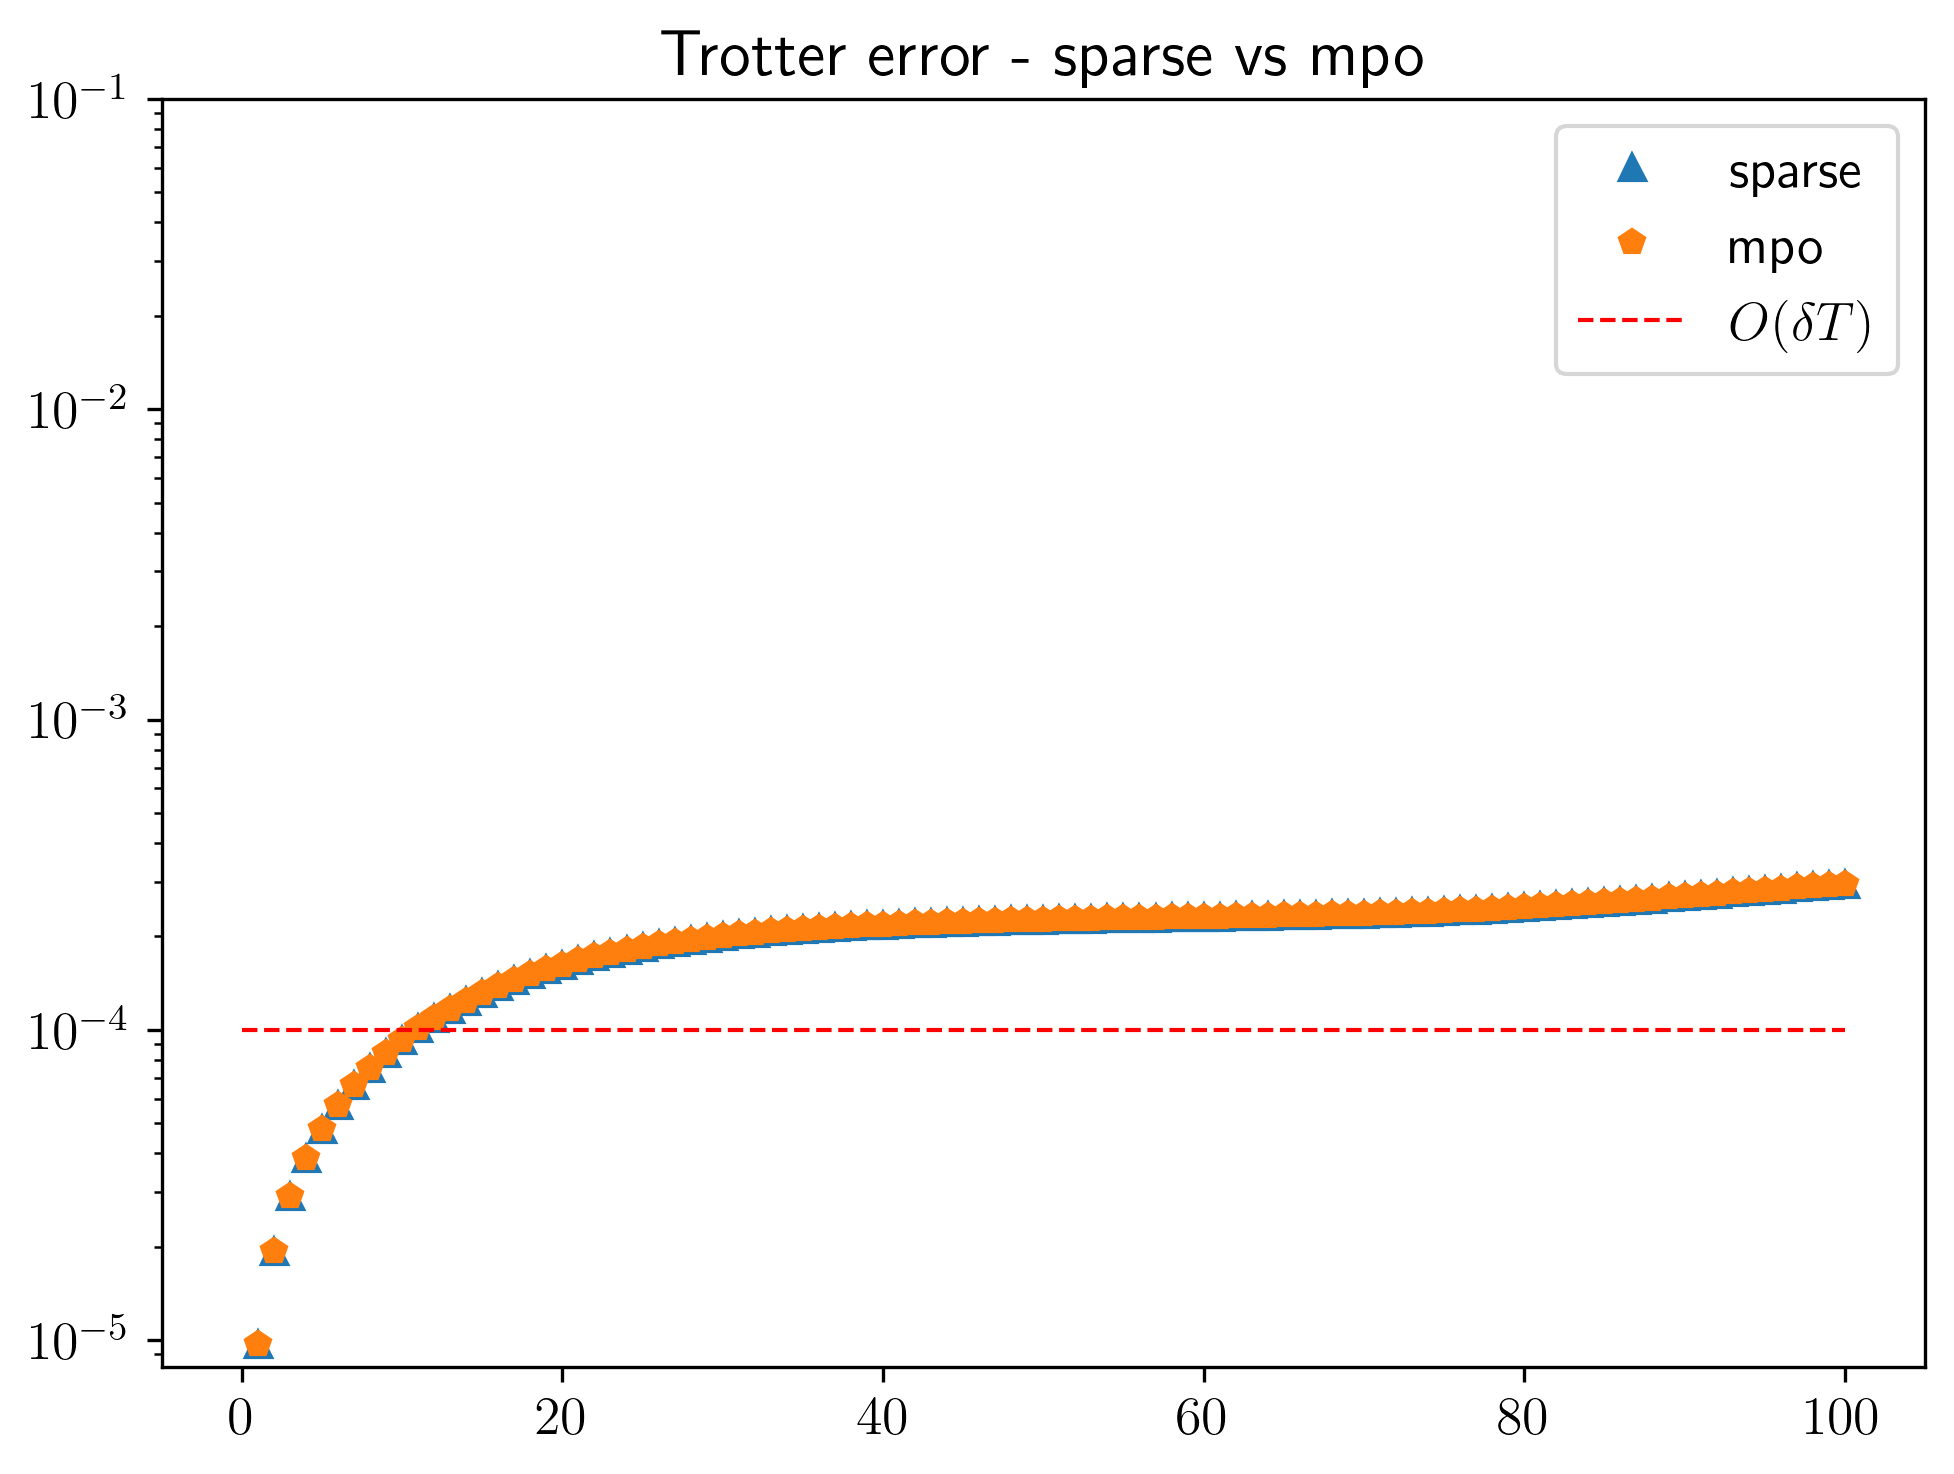

In [191]:
plt.title("Trotter error - sparse vs mpo")
plt.plot(diff_sp, '^', label="sparse")
plt.plot(diff_mpo, 'p', label="mpo")
plt.hlines(y=(delta**3)*steps, xmin=0, xmax=steps, linestyles="--", linewidth=1, color="red", label="$O(\\delta T)$")
plt.yscale("log")
plt.ylim(top=1e-1)
plt.legend()


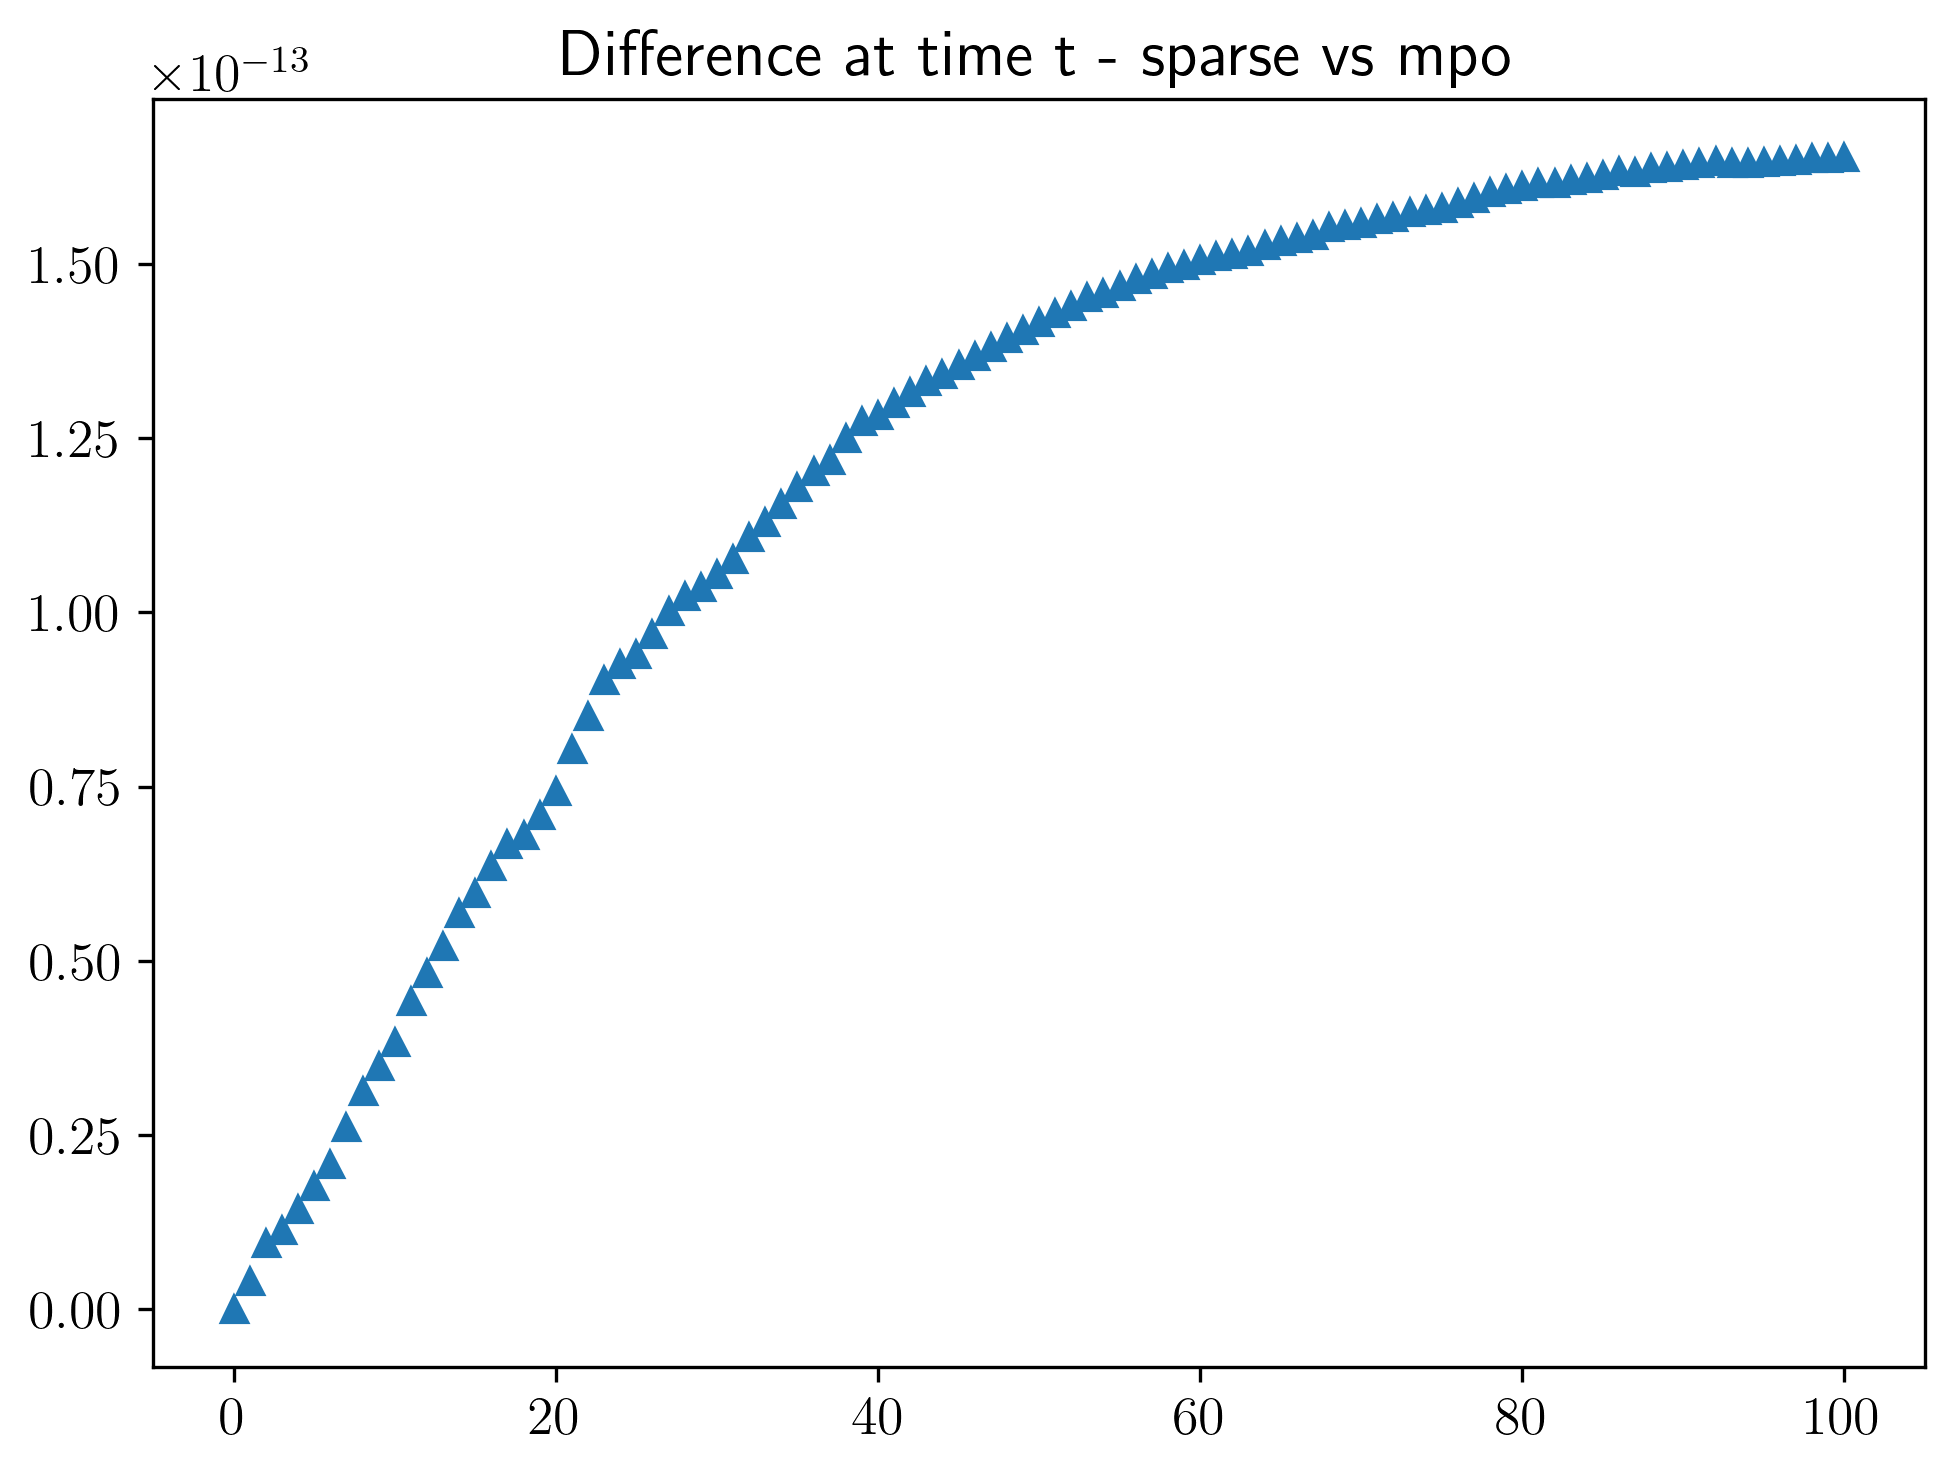

In [173]:
plt.title("Difference at time t - sparse vs mpo")
plt.plot(diff_trott, '^')

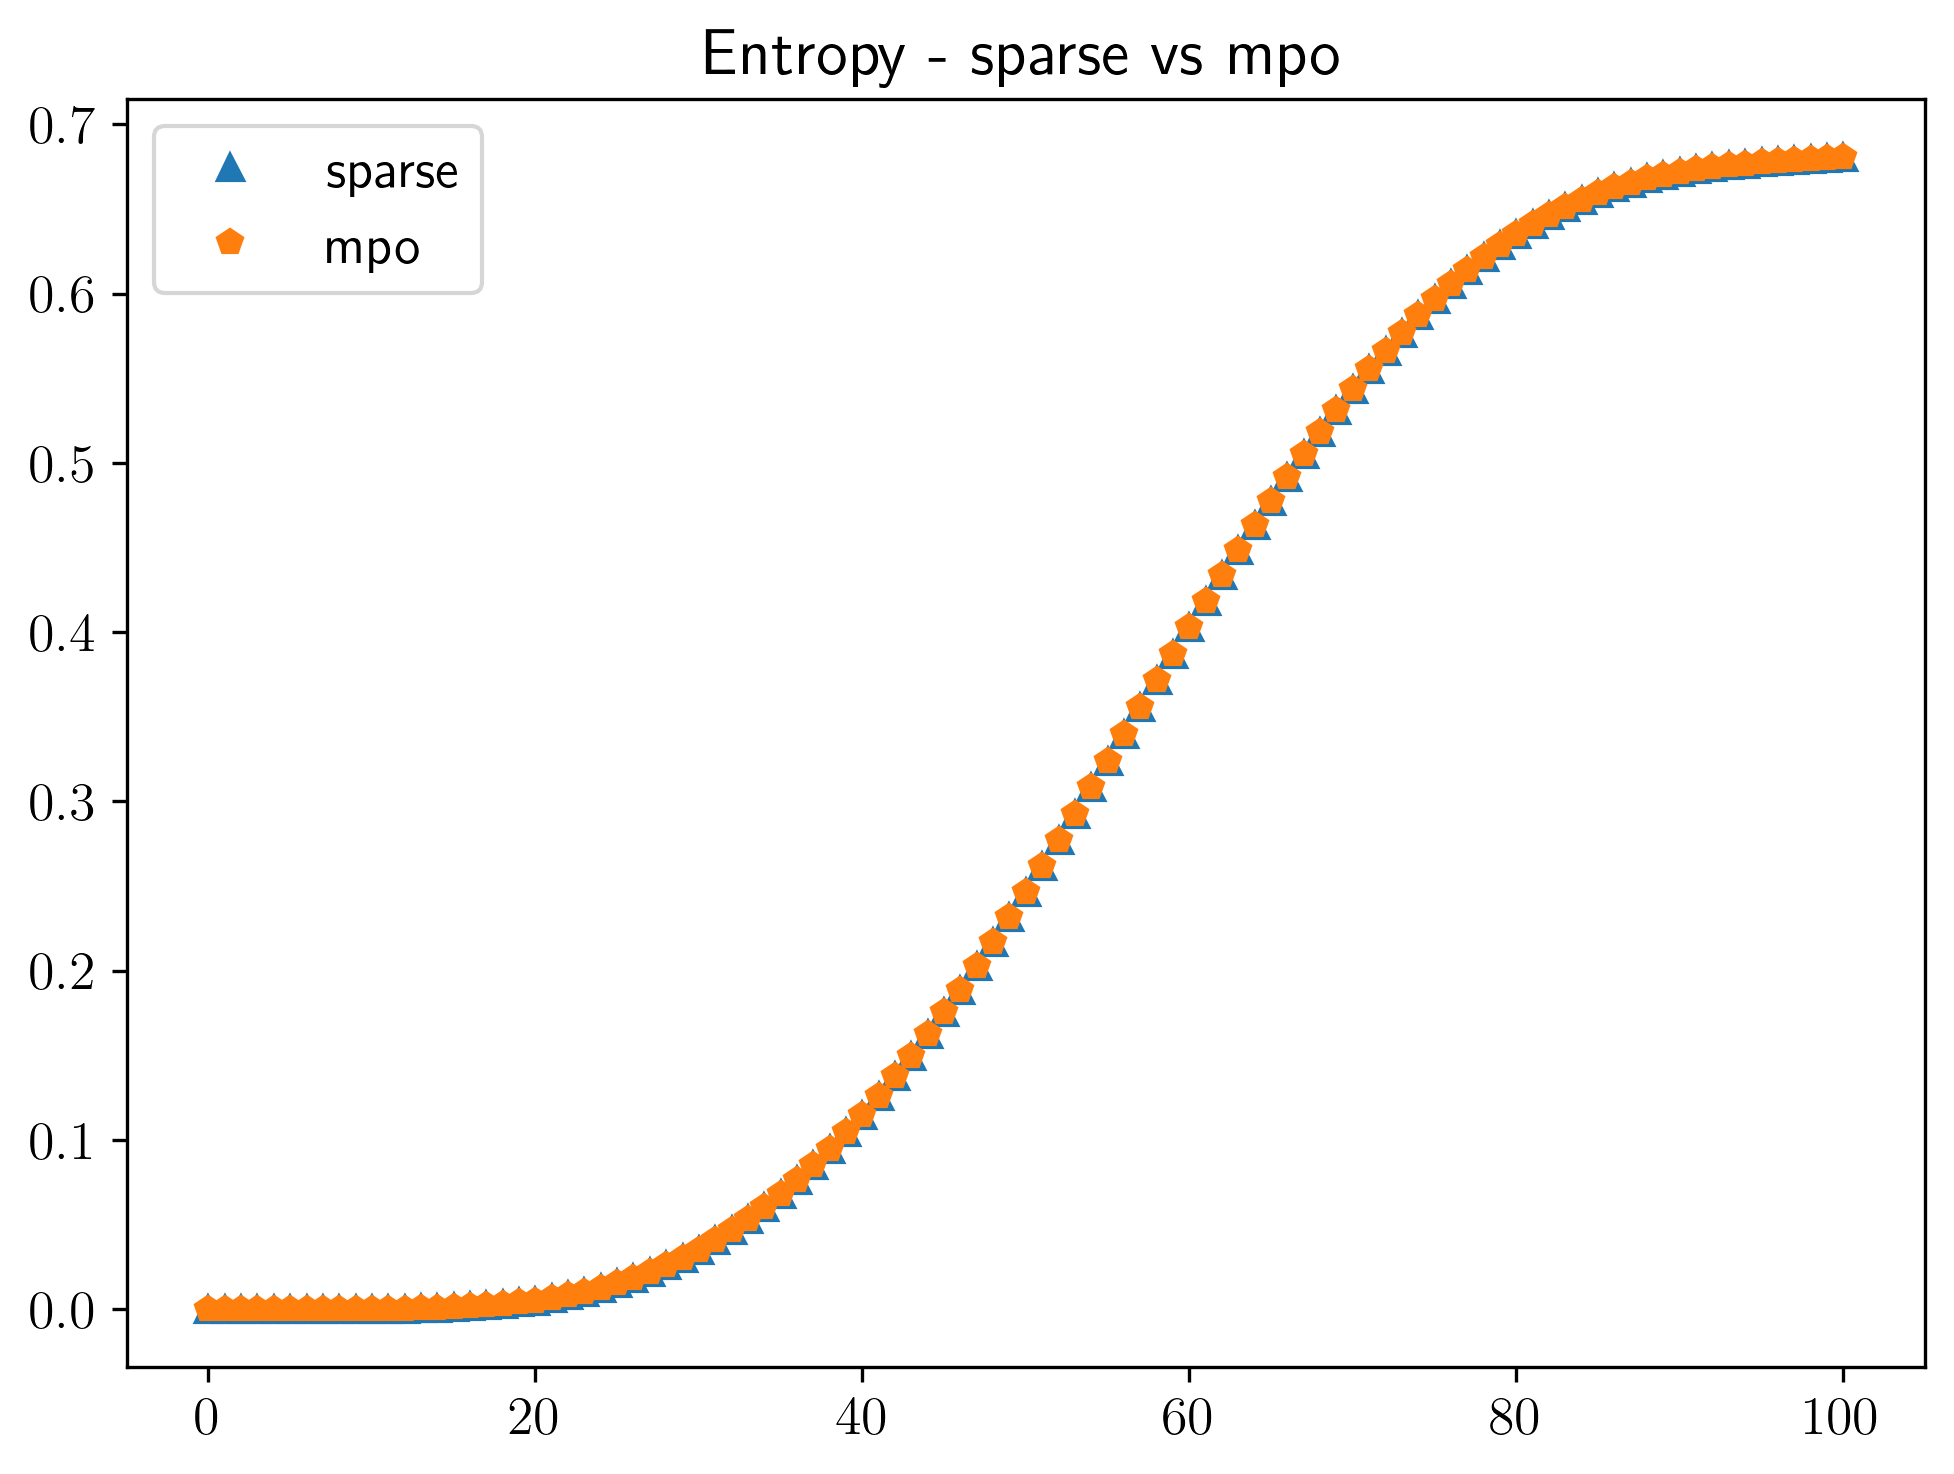

In [174]:
plt.title("Entropy - sparse vs mpo")
plt.plot(entropy_sp, '^', label="sparse")
plt.plot(entropy_mpo, 'p', label="mpo")
plt.legend()

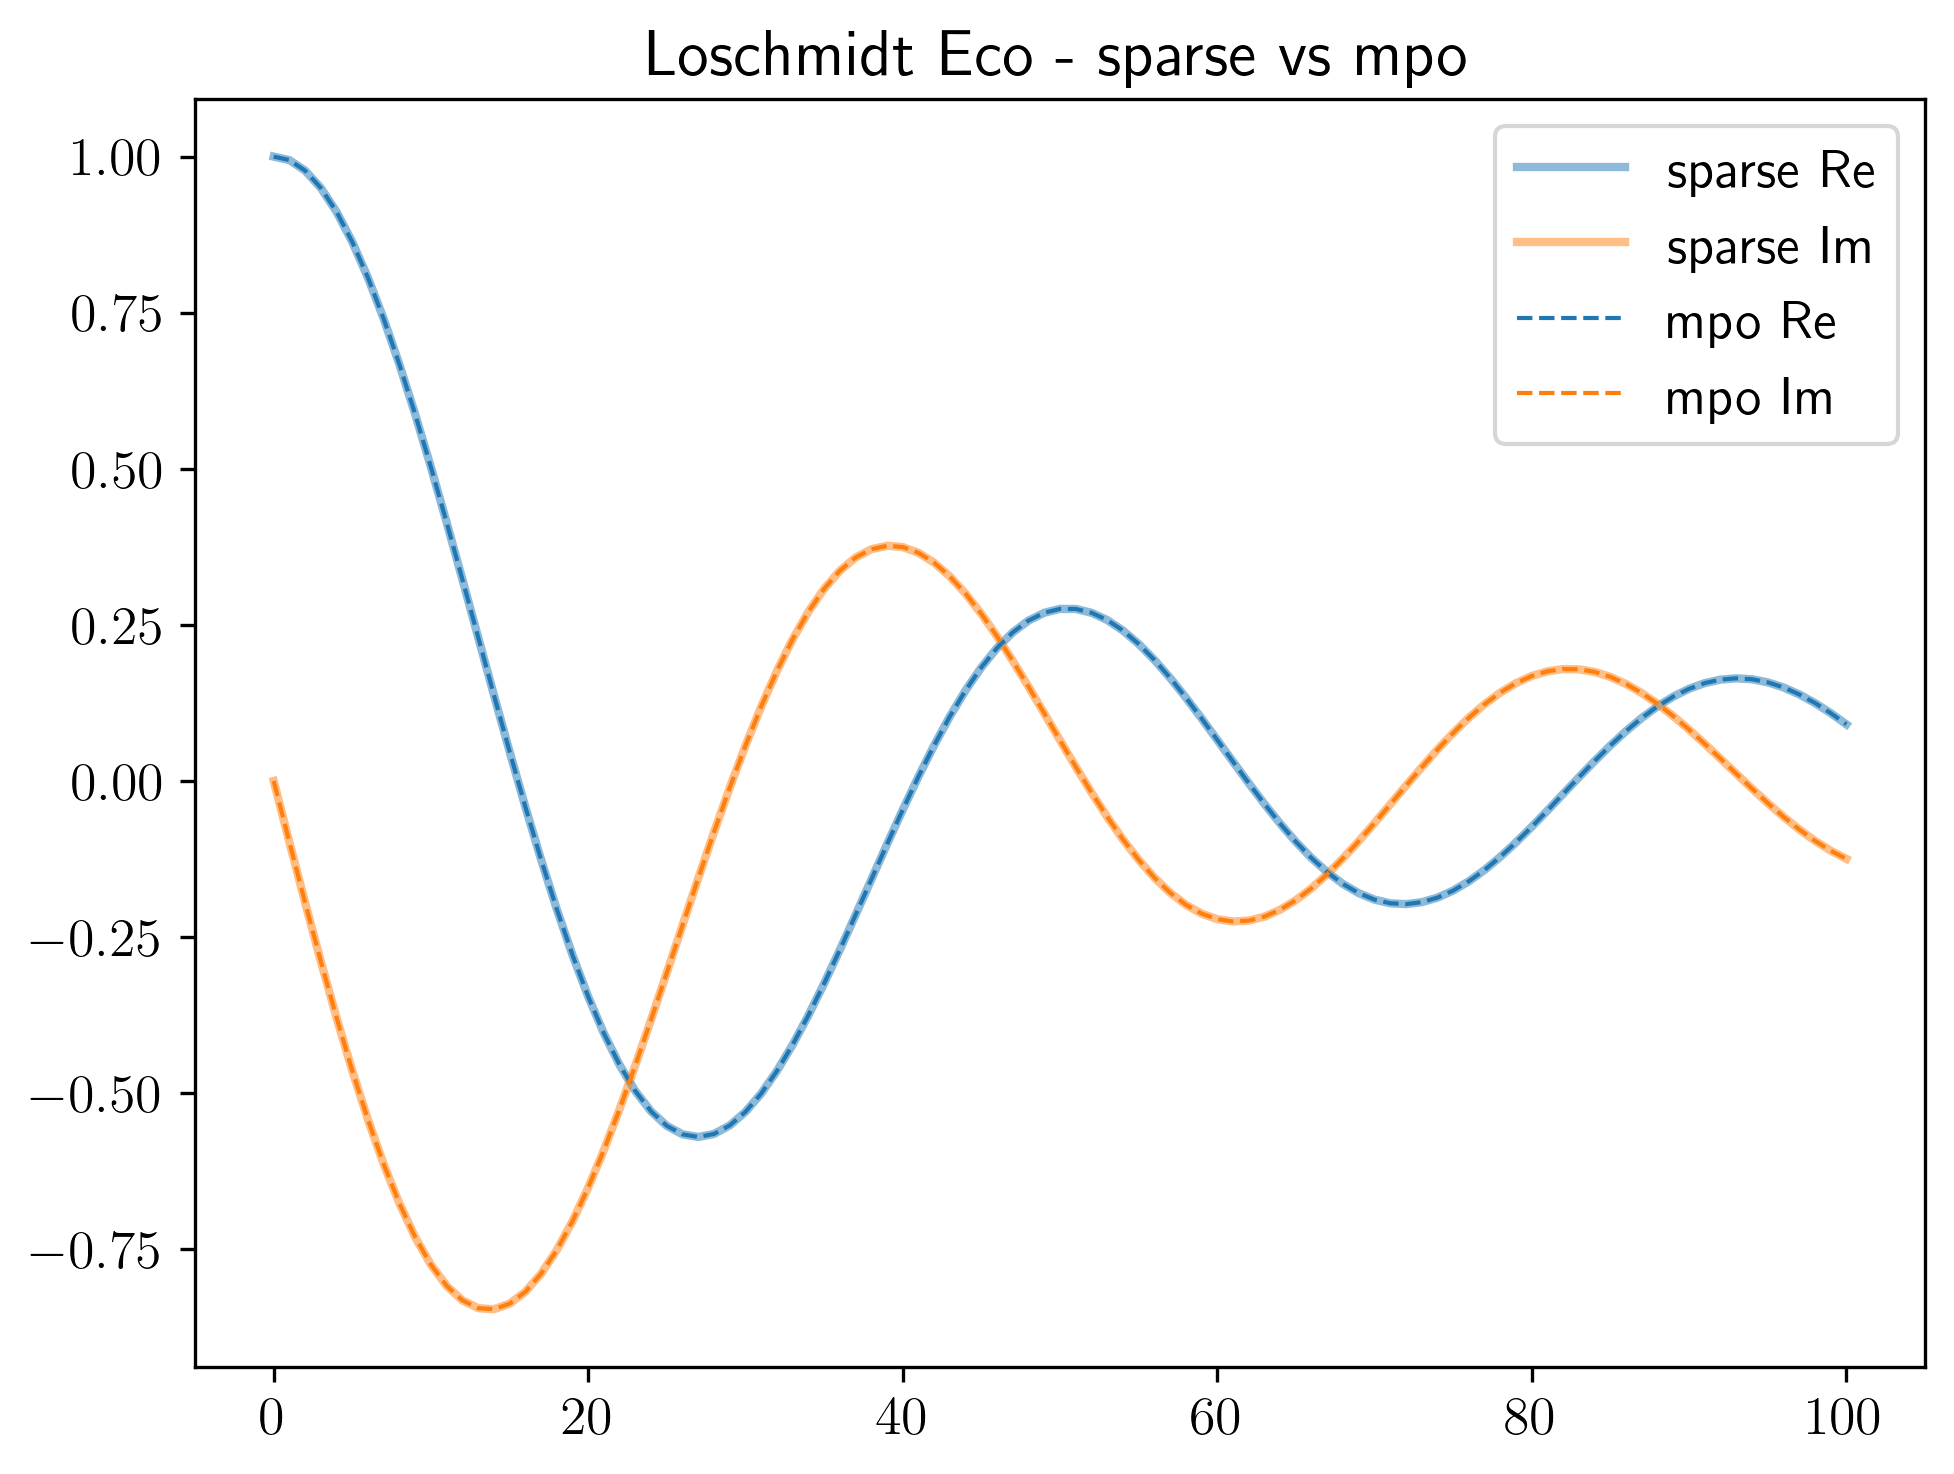

In [185]:
plt.title("Loschmidt Eco - sparse vs mpo")
plt.plot([ov.real for ov in overlap_sp], linestyle="-", linewidth=2, alpha=0.5, color="C0", label="sparse Re")
plt.plot([ov.imag for ov in overlap_sp], linestyle="-", linewidth=2, alpha=0.5, color="C1", label="sparse Im")
plt.plot([ov.real for ov in overlap_mpo], linestyle="--", linewidth=1, color="C0", label="mpo Re")
plt.plot([ov.imag for ov in overlap_mpo], linestyle="--", linewidth=1, color="C1", label="mpo Im")
plt.legend()

/Users/fradm98/opt/anaconda3/envs/mps/lib/python3.11/site-packages/IPython/core/events.py:93: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  func(*args, **kwargs)
/Users/fradm98/opt/anaconda3/envs/mps/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


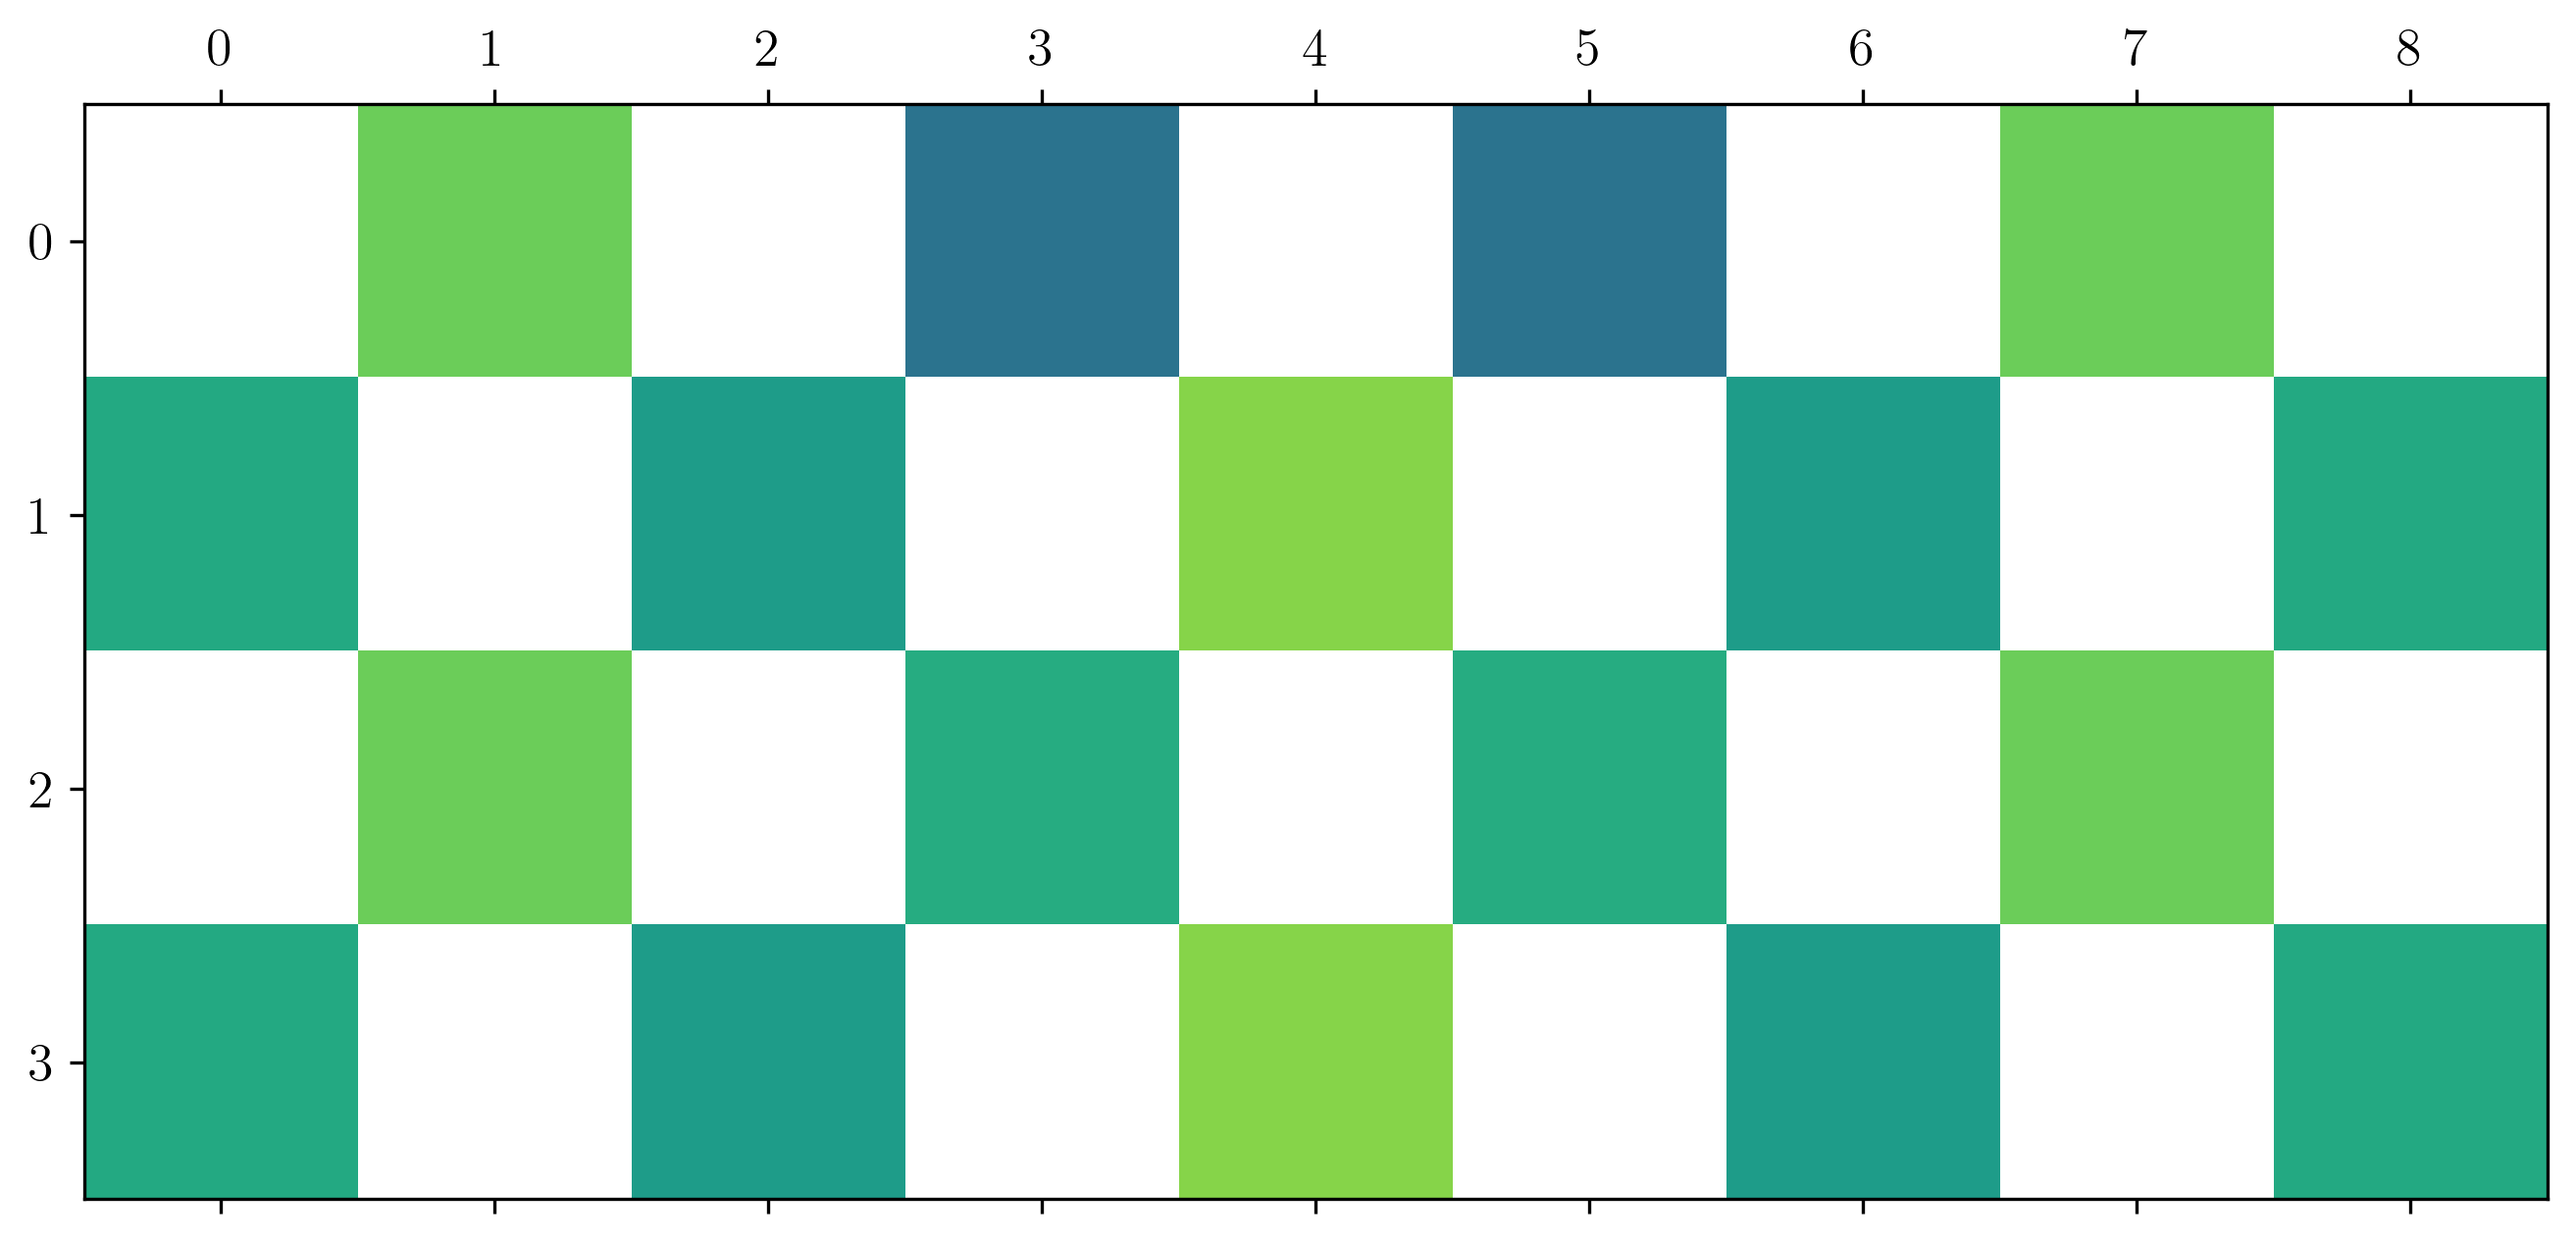

In [176]:
plt.matshow(e_field_sp[-1], vmin=-1, vmax=1)

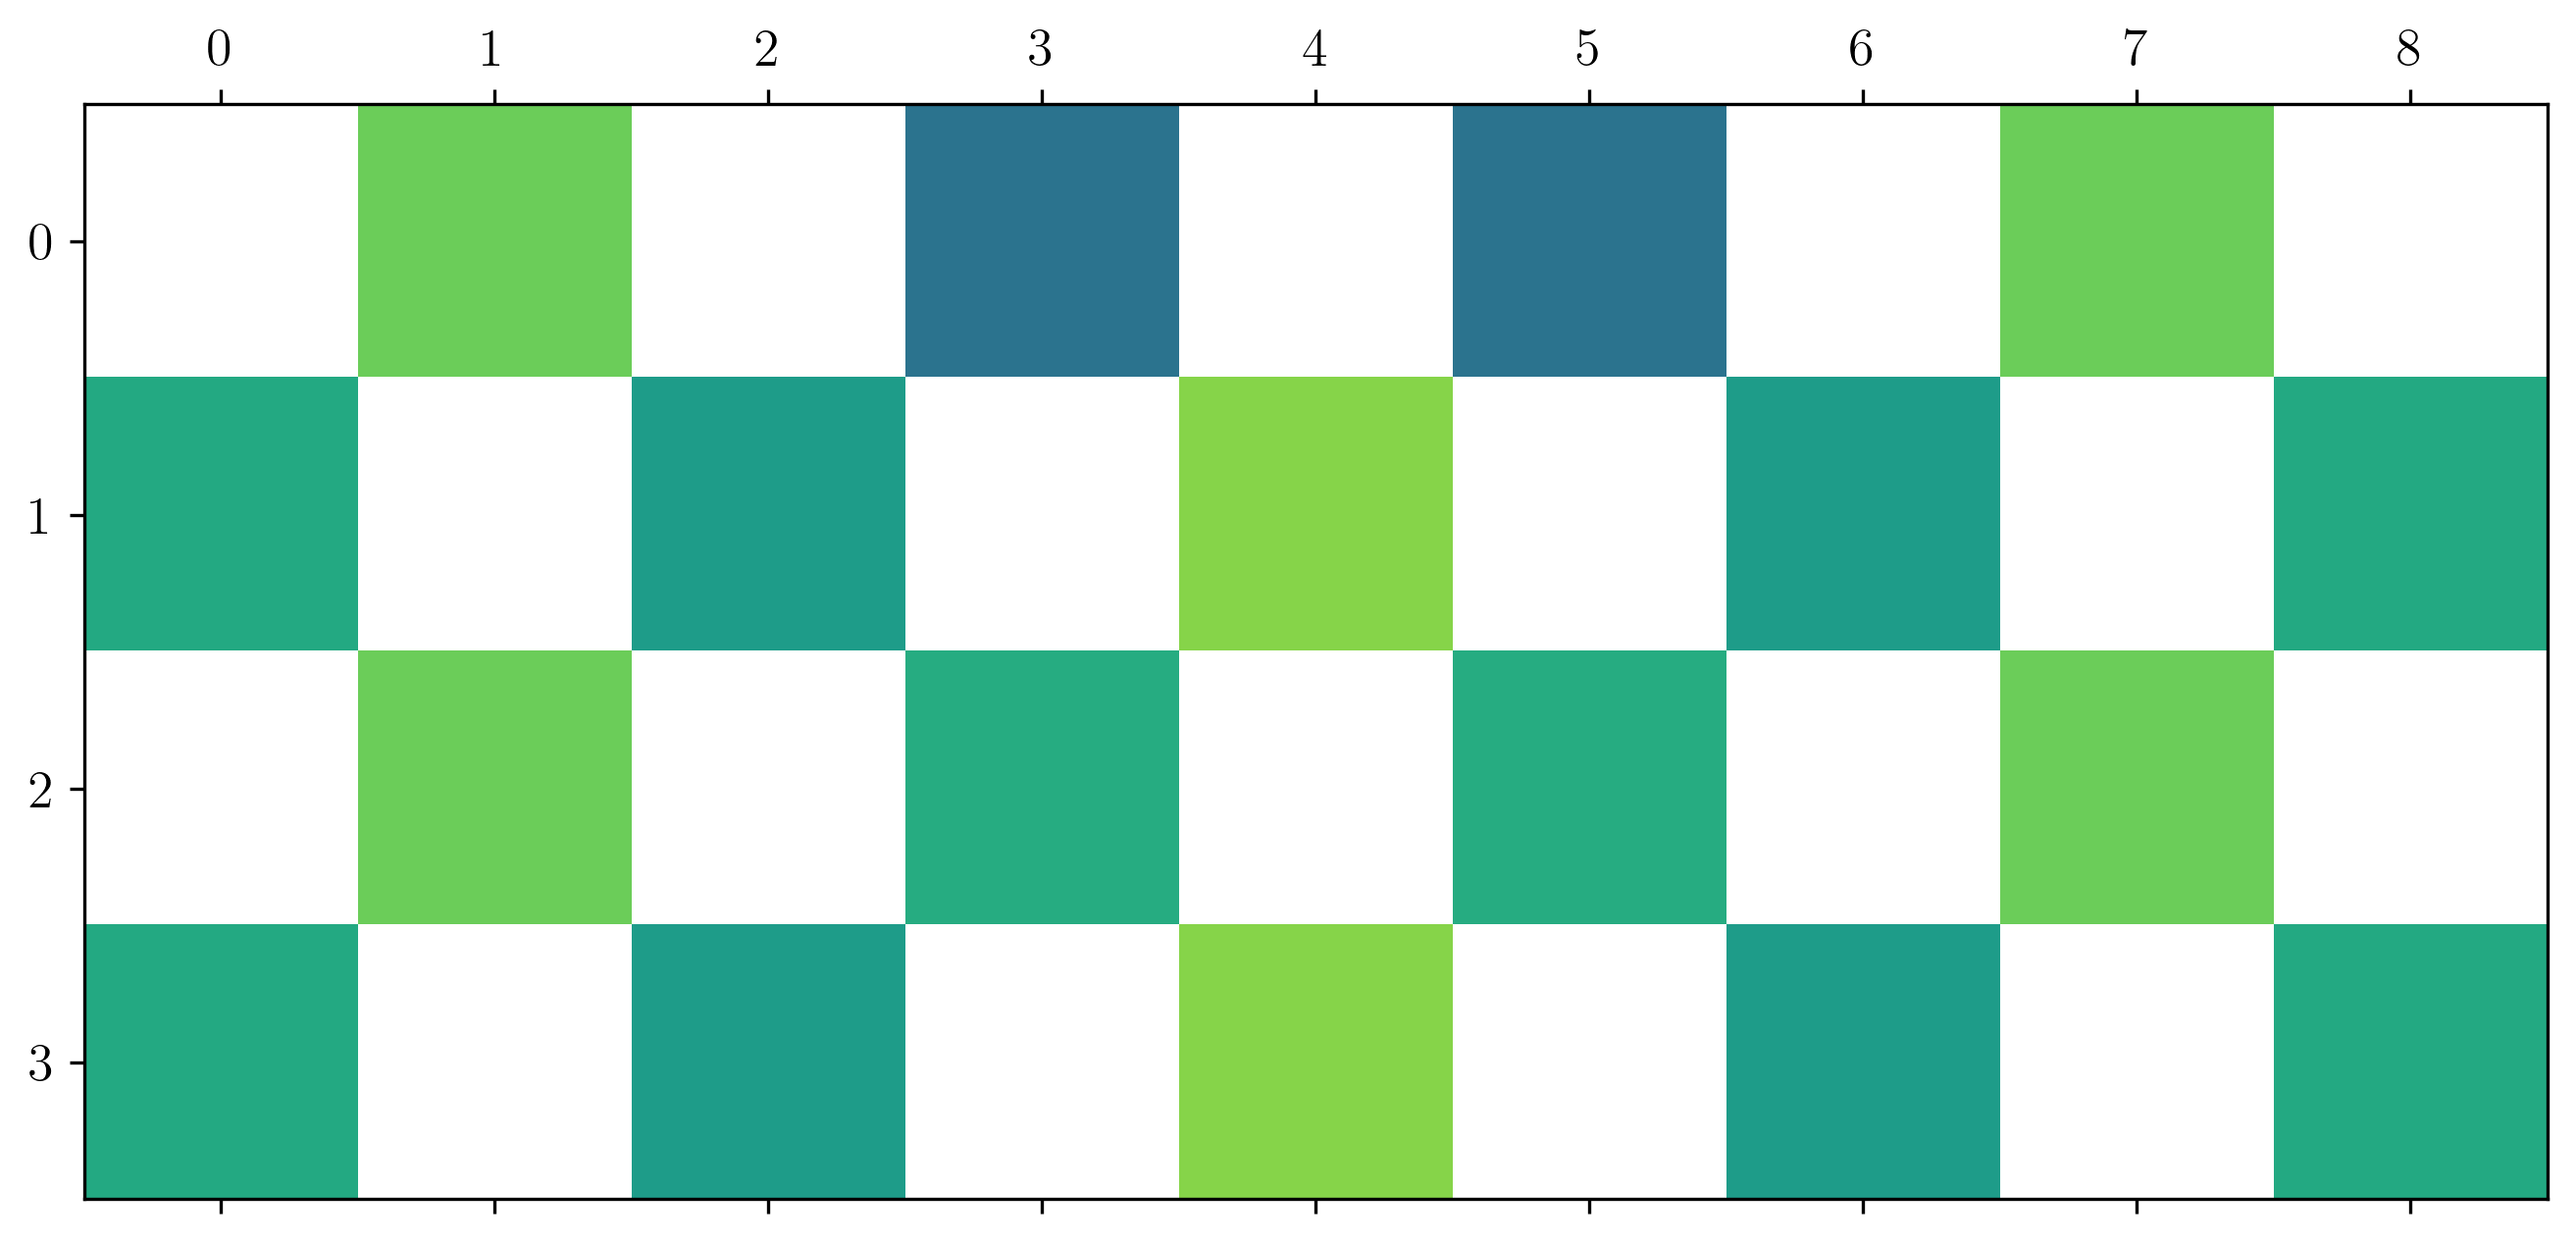

In [177]:
plt.matshow(e_field_mpo[-1], vmin=-1, vmax=1)


## TEBD Z2

In [ ]:
L = 4
l = 2
d = 2**l
model = "Z2_dual"
h = 0.1
g_ev = 0.1
chi = 100
R = 0
bc = "pbc"
cx = get_cx(L=L,R=R)
cy = get_cy(l=l,bc=bc)
cx, cy = None, None

z2_lattice = MPS(L=L, d=d, model=model, chi=chi, h=h, bc=bc)
z2_lattice._random_state(seed=3, type_shape="rectangular", chi=chi)
z2_lattice.canonical_form()
# z2_lattice.Z2.add_charges(cx,cy)
z2_lattice.Z2._define_sector()
z2_lattice.charges = z2_lattice.Z2.charges.copy()
z2_lattice.sites.append(np.random.rand(1,2,1))
z2_lattice.L = len(z2_lattice.sites)
z2_lattice.DMRG(trunc_chi=True, trunc_tol=False, where=L//2, long="Z", trans="X")
z2_lattice.check_canonical(site=1)
tensor_shapes(z2_lattice.sites)
aux_qub = z2_lattice.sites.pop()
z2_lattice.L -= 1

z2_lattice.order_param()
z2_lattice.mpo_first_moment()

Sweep n: 0

Sweep n: 1

the tensor at site 5 is in the correct RFC
the tensor at site 4 is in the correct RFC
the tensor at site 3 is in the correct RFC
the tensor at site 2 is in the correct RFC
(1, 4, 4)
(4, 4, 16)
(16, 4, 4)
(4, 4, 1)
(1, 2, 1)


array(9.99200722e-16+0.j)

In [ ]:
delta = 0.01
steps = 10
exact = True
save_gif = False
errs, entrs, svs, efields, losch, ex_sp, ex_mps, mps_sp = z2_lattice.TEBD_variational_Z2_exact(trotter_steps=steps, delta=delta, h_ev=g_ev, n_sweeps=4, conv_tol=1e-12, where=L//2, aux_qub=aux_qub, cx=cx, cy=cy, exact=exact, obs=["el","losch"])

------ Trotter steps: 0 -------
Bond dim ancilla: 16
Bond dim site: 16
Sweep n: 0

Sweep n: 1

##############################
The error between the two last updated states converged
to an order of 1e-12 after:
1 sweeps at site 4
total iterations 9
##############################
Bond dim ancilla: 16
Bond dim site: 16
Sweep n: 0

Sweep n: 1

##############################
The error between the two last updated states converged
to an order of 1e-12 after:
1 sweeps at site 4
total iterations 9
##############################
MPO matches the sparse matrix representation!
------ Trotter steps: 1 -------
Bond dim ancilla: 16
Bond dim site: 16
Sweep n: 0

Sweep n: 1

##############################
The error between the two last updated states converged
to an order of 1e-12 after:
1 sweeps at site 4
total iterations 9
##############################
Bond dim ancilla: 16
Bond dim site: 16
Sweep n: 0

Sweep n: 1

##############################
The error between the two last updated states converged

<>:2: SyntaxWarning: invalid escape sequence '\p'
<>:2: SyntaxWarning: invalid escape sequence '\p'
/var/folders/d1/c6hqhfn161x458f4d0m3_rm80000gp/T/ipykernel_57996/2472048915.py:2: SyntaxWarning: invalid escape sequence '\p'
  plt.plot(delta*np.asarray(range(steps+1)), errs, marker='o', linestyle="", markersize=5, alpha=0.5, label="${||\psi - O \phi||}^2$")


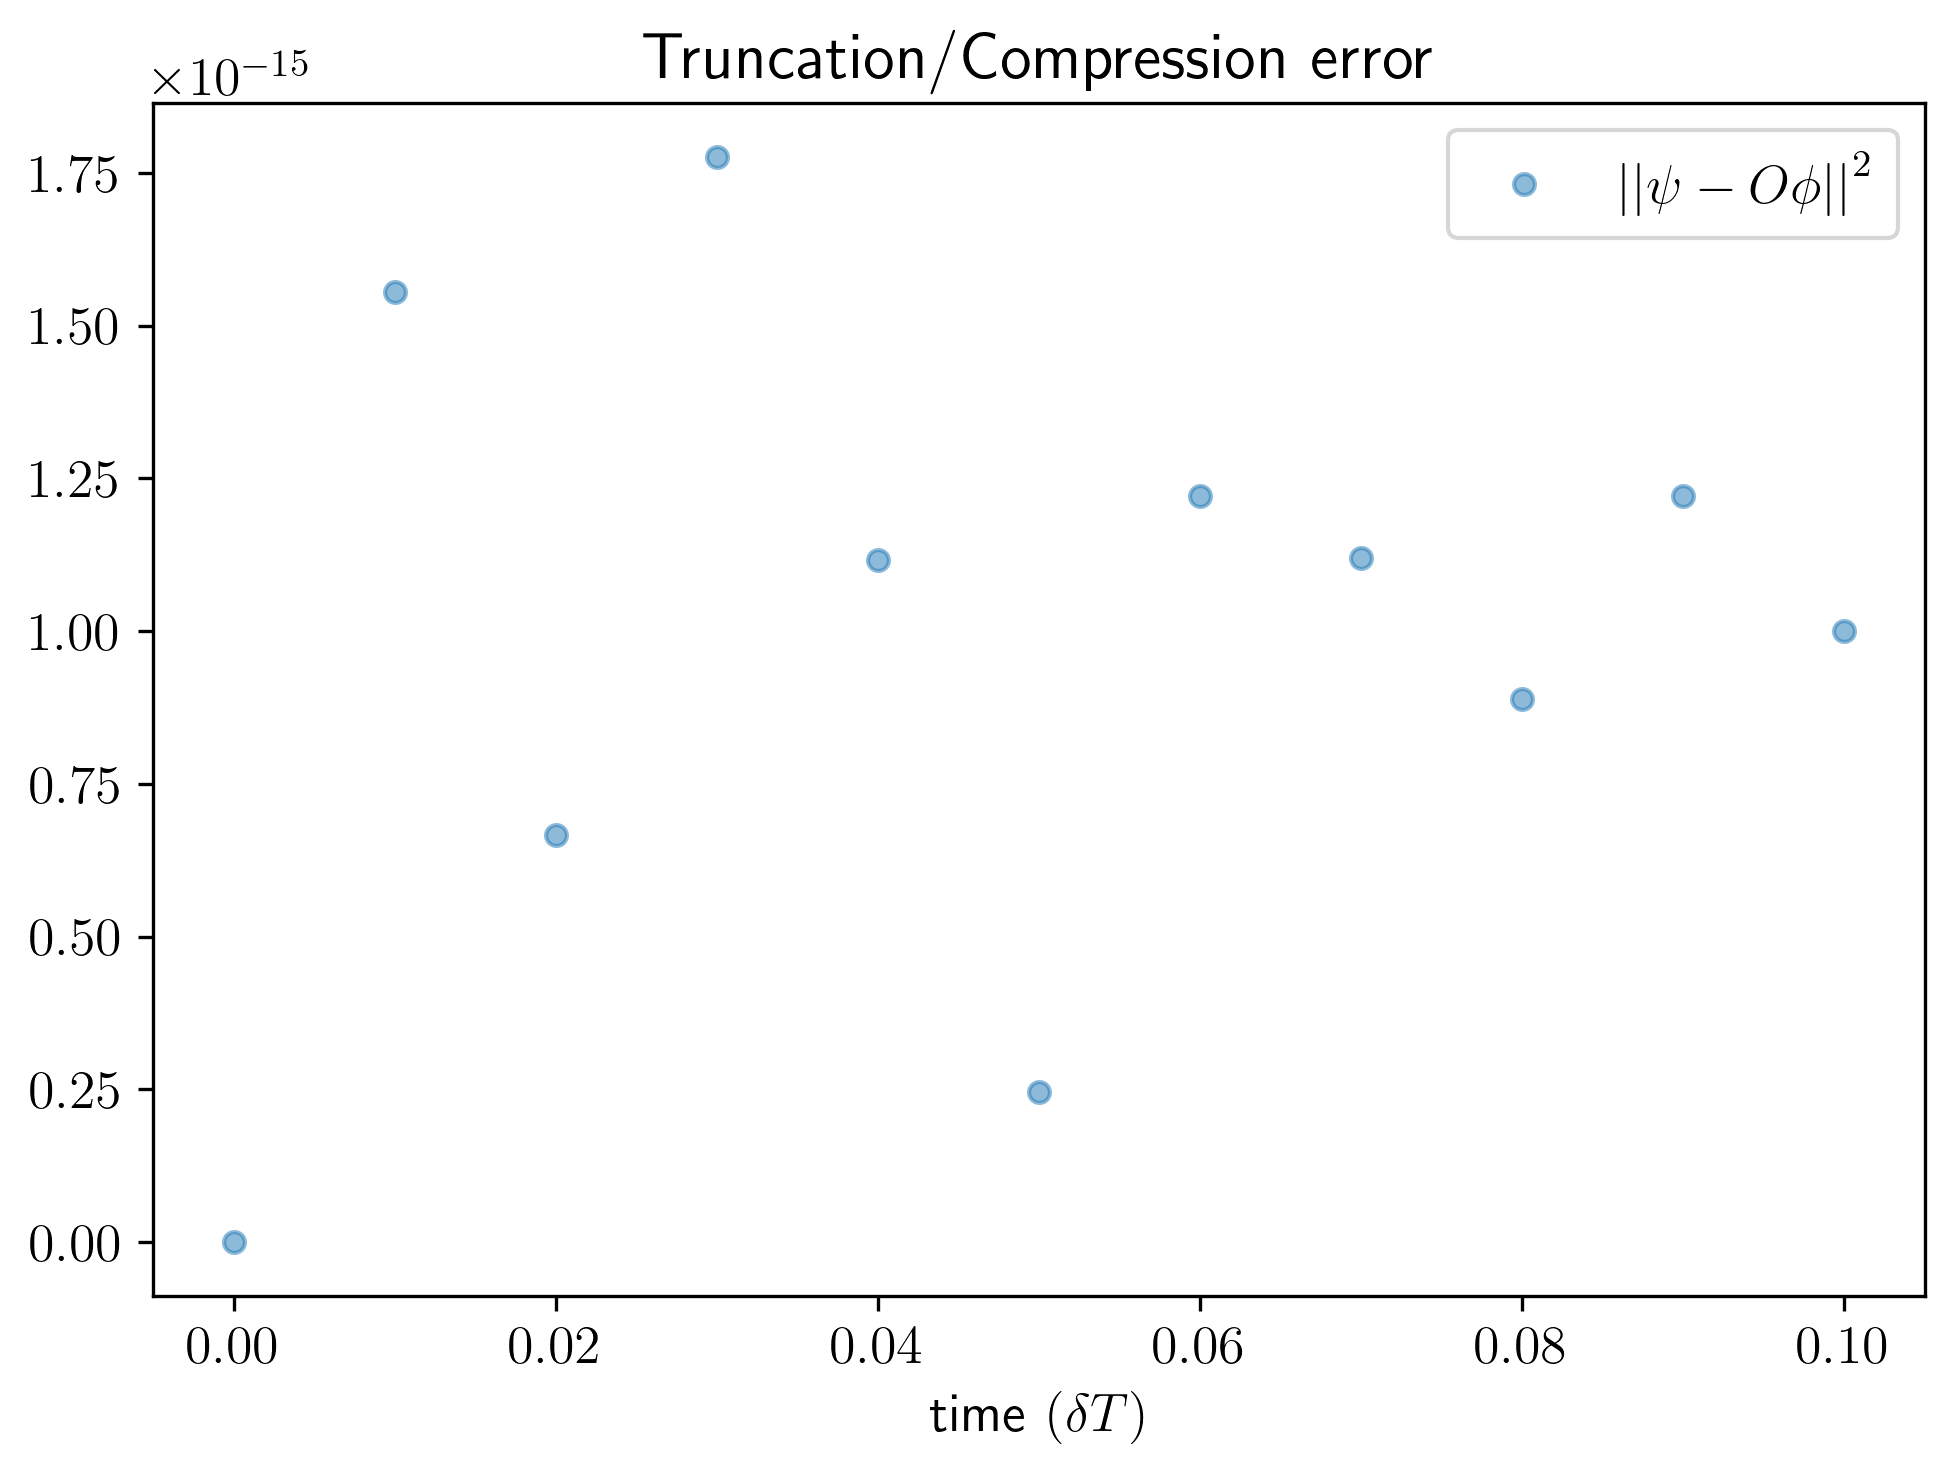

In [117]:
plt.title("Truncation/Compression error")
plt.plot(delta*np.asarray(range(steps+1)), errs, marker='o', linestyle="", markersize=5, alpha=0.5, label="${||\psi - O \phi||}^2$")
plt.xlabel("time $(\\delta T)$")
plt.legend()

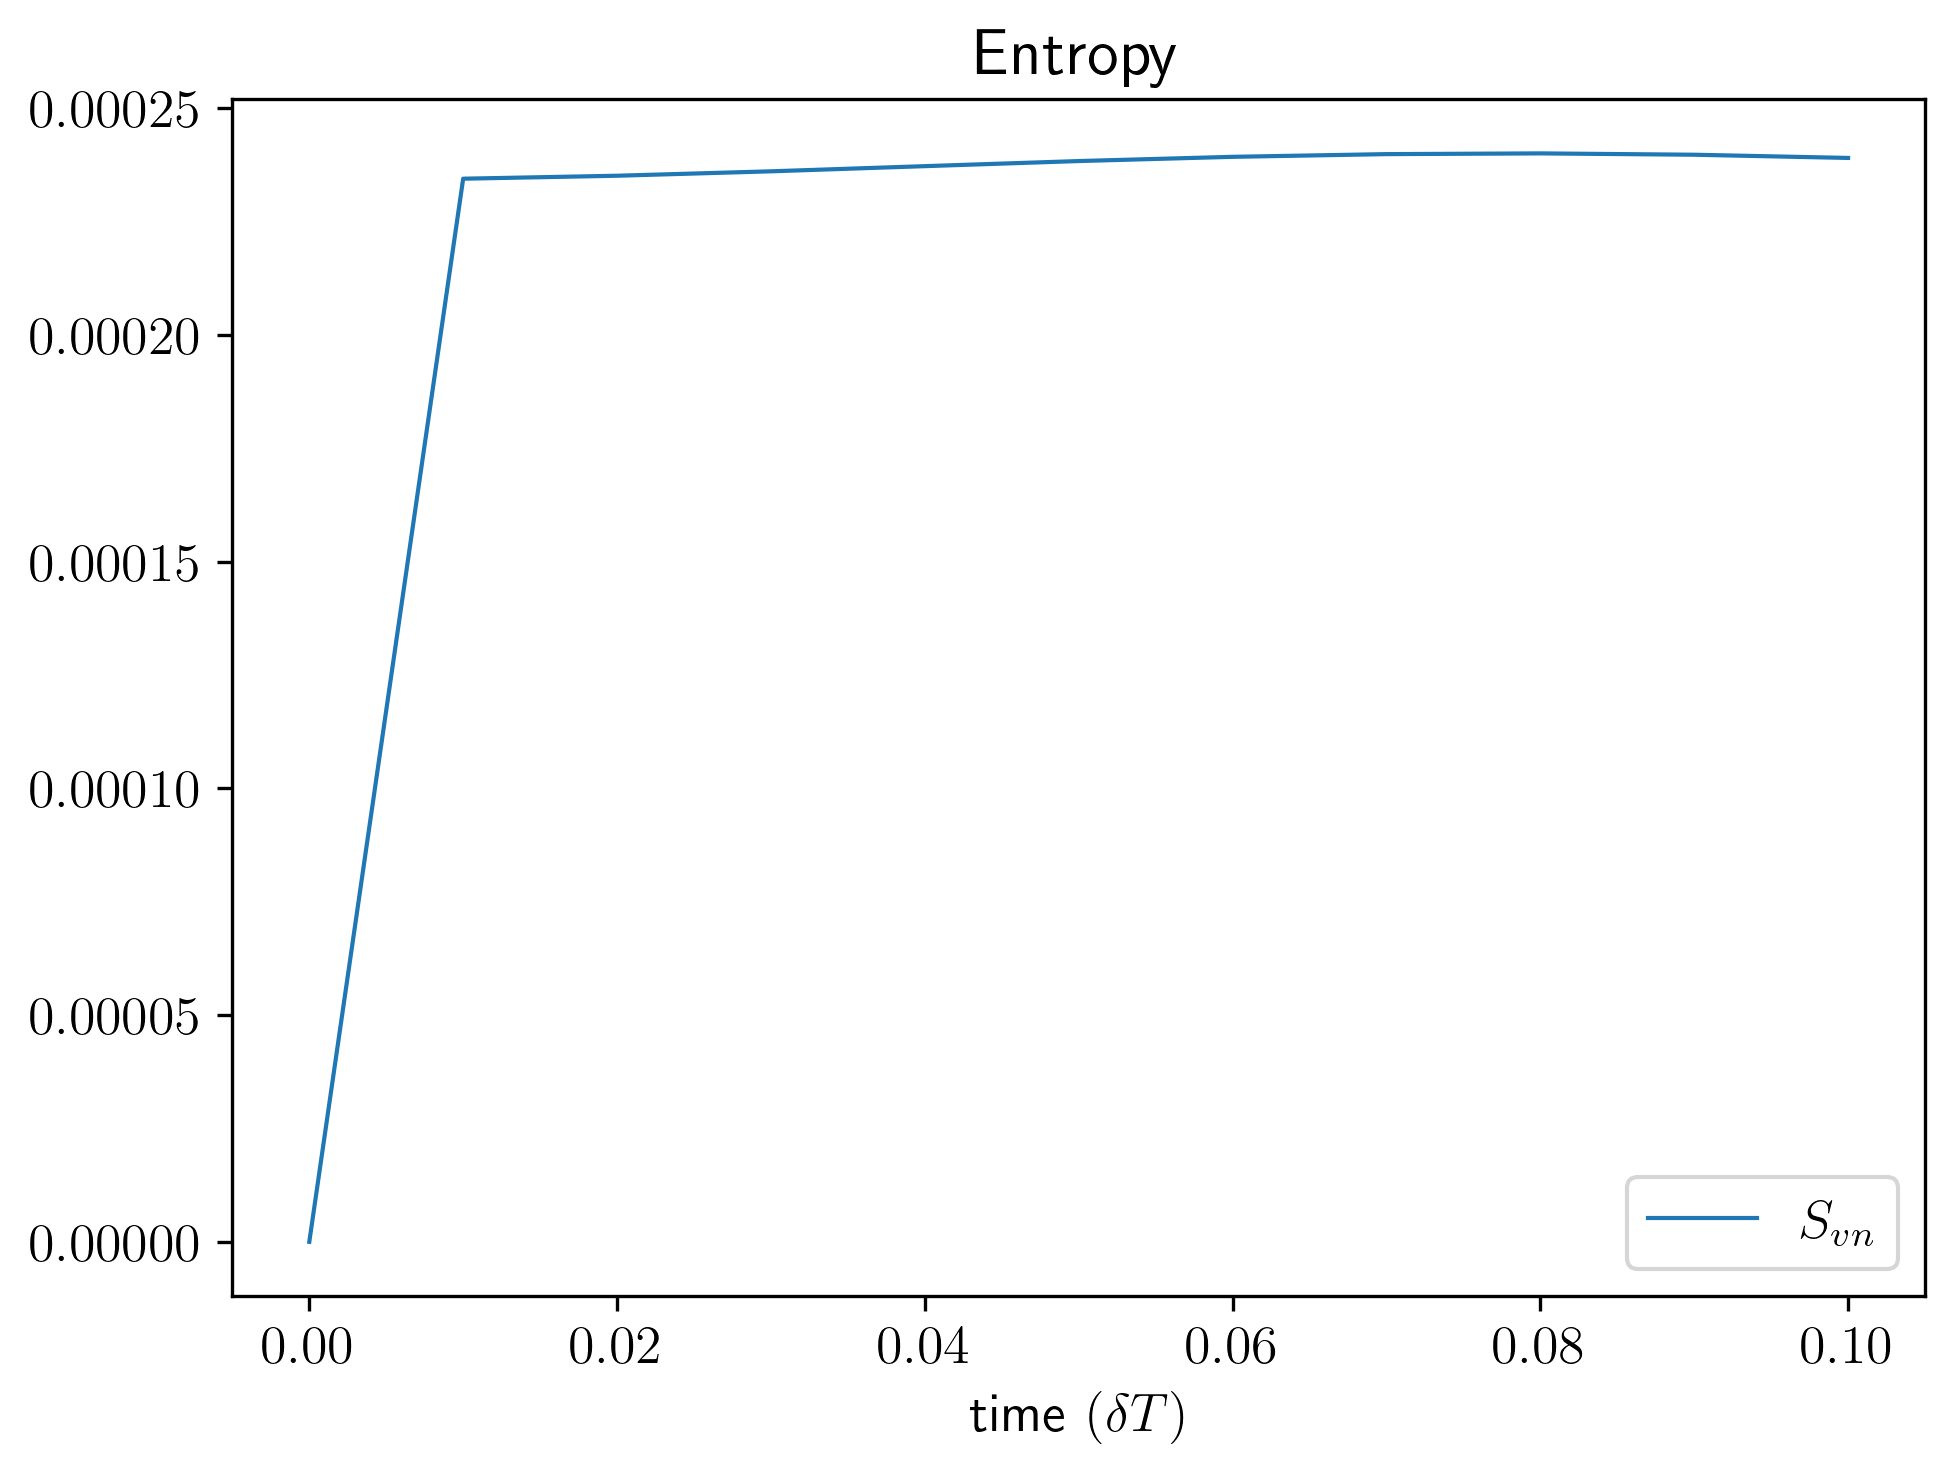

In [118]:
plt.title("Entropy")
plt.plot(delta*np.asarray(range(steps+1)), entrs, linewidth=1, label="$S_{vn}$")
plt.xlabel("time $(\\delta T)$")
plt.legend()

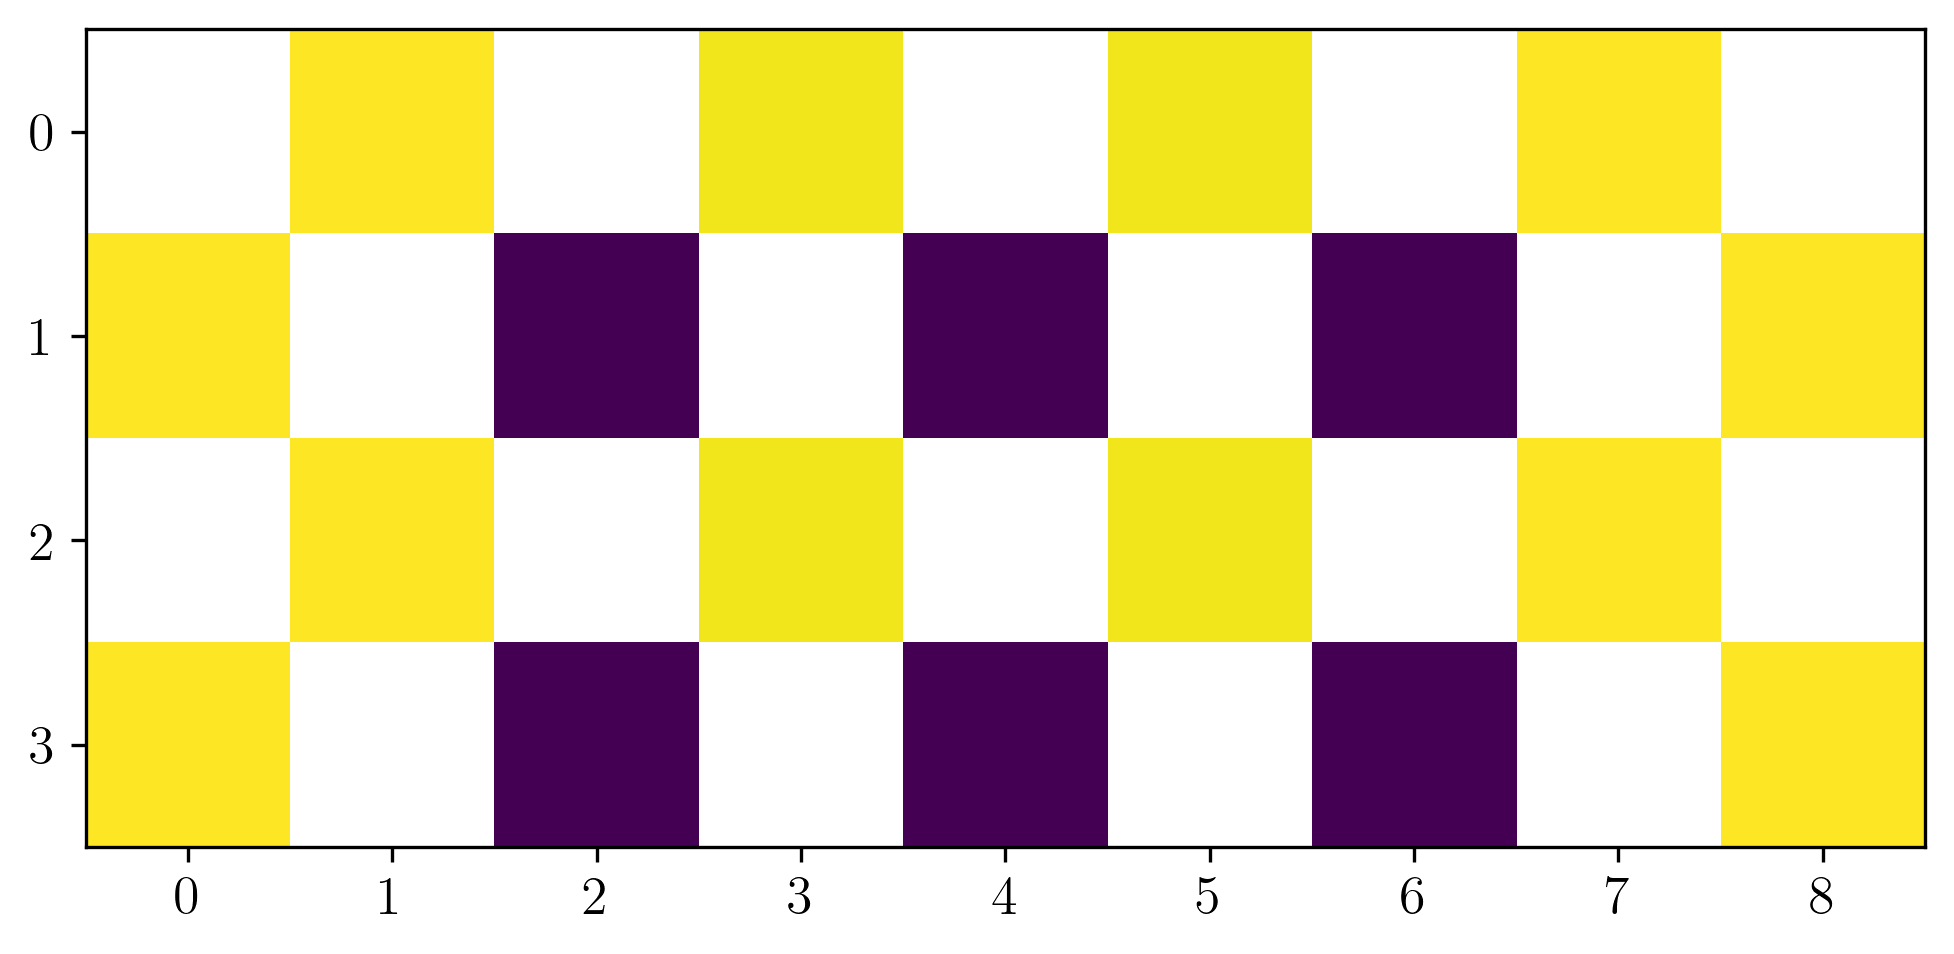

In [119]:
plt.imshow(efields[-1])

In [120]:
if save_gif:
    movie = anim(frames=steps+1, interval=200, data=efields, params=np.linspace(0,steps*delta,steps+1), show=True, charges_x=cx, charges_y=cy, precision=2, time=True)
    movie.save(filename=f"quench_mpo_1_{l}x{L}_g_start_{h}_g_ev_{g_ev}_trott_steps_{steps}_delta_{delta}_chi_{chi}.gif")

TypeError: 'NoneType' object is not subscriptable

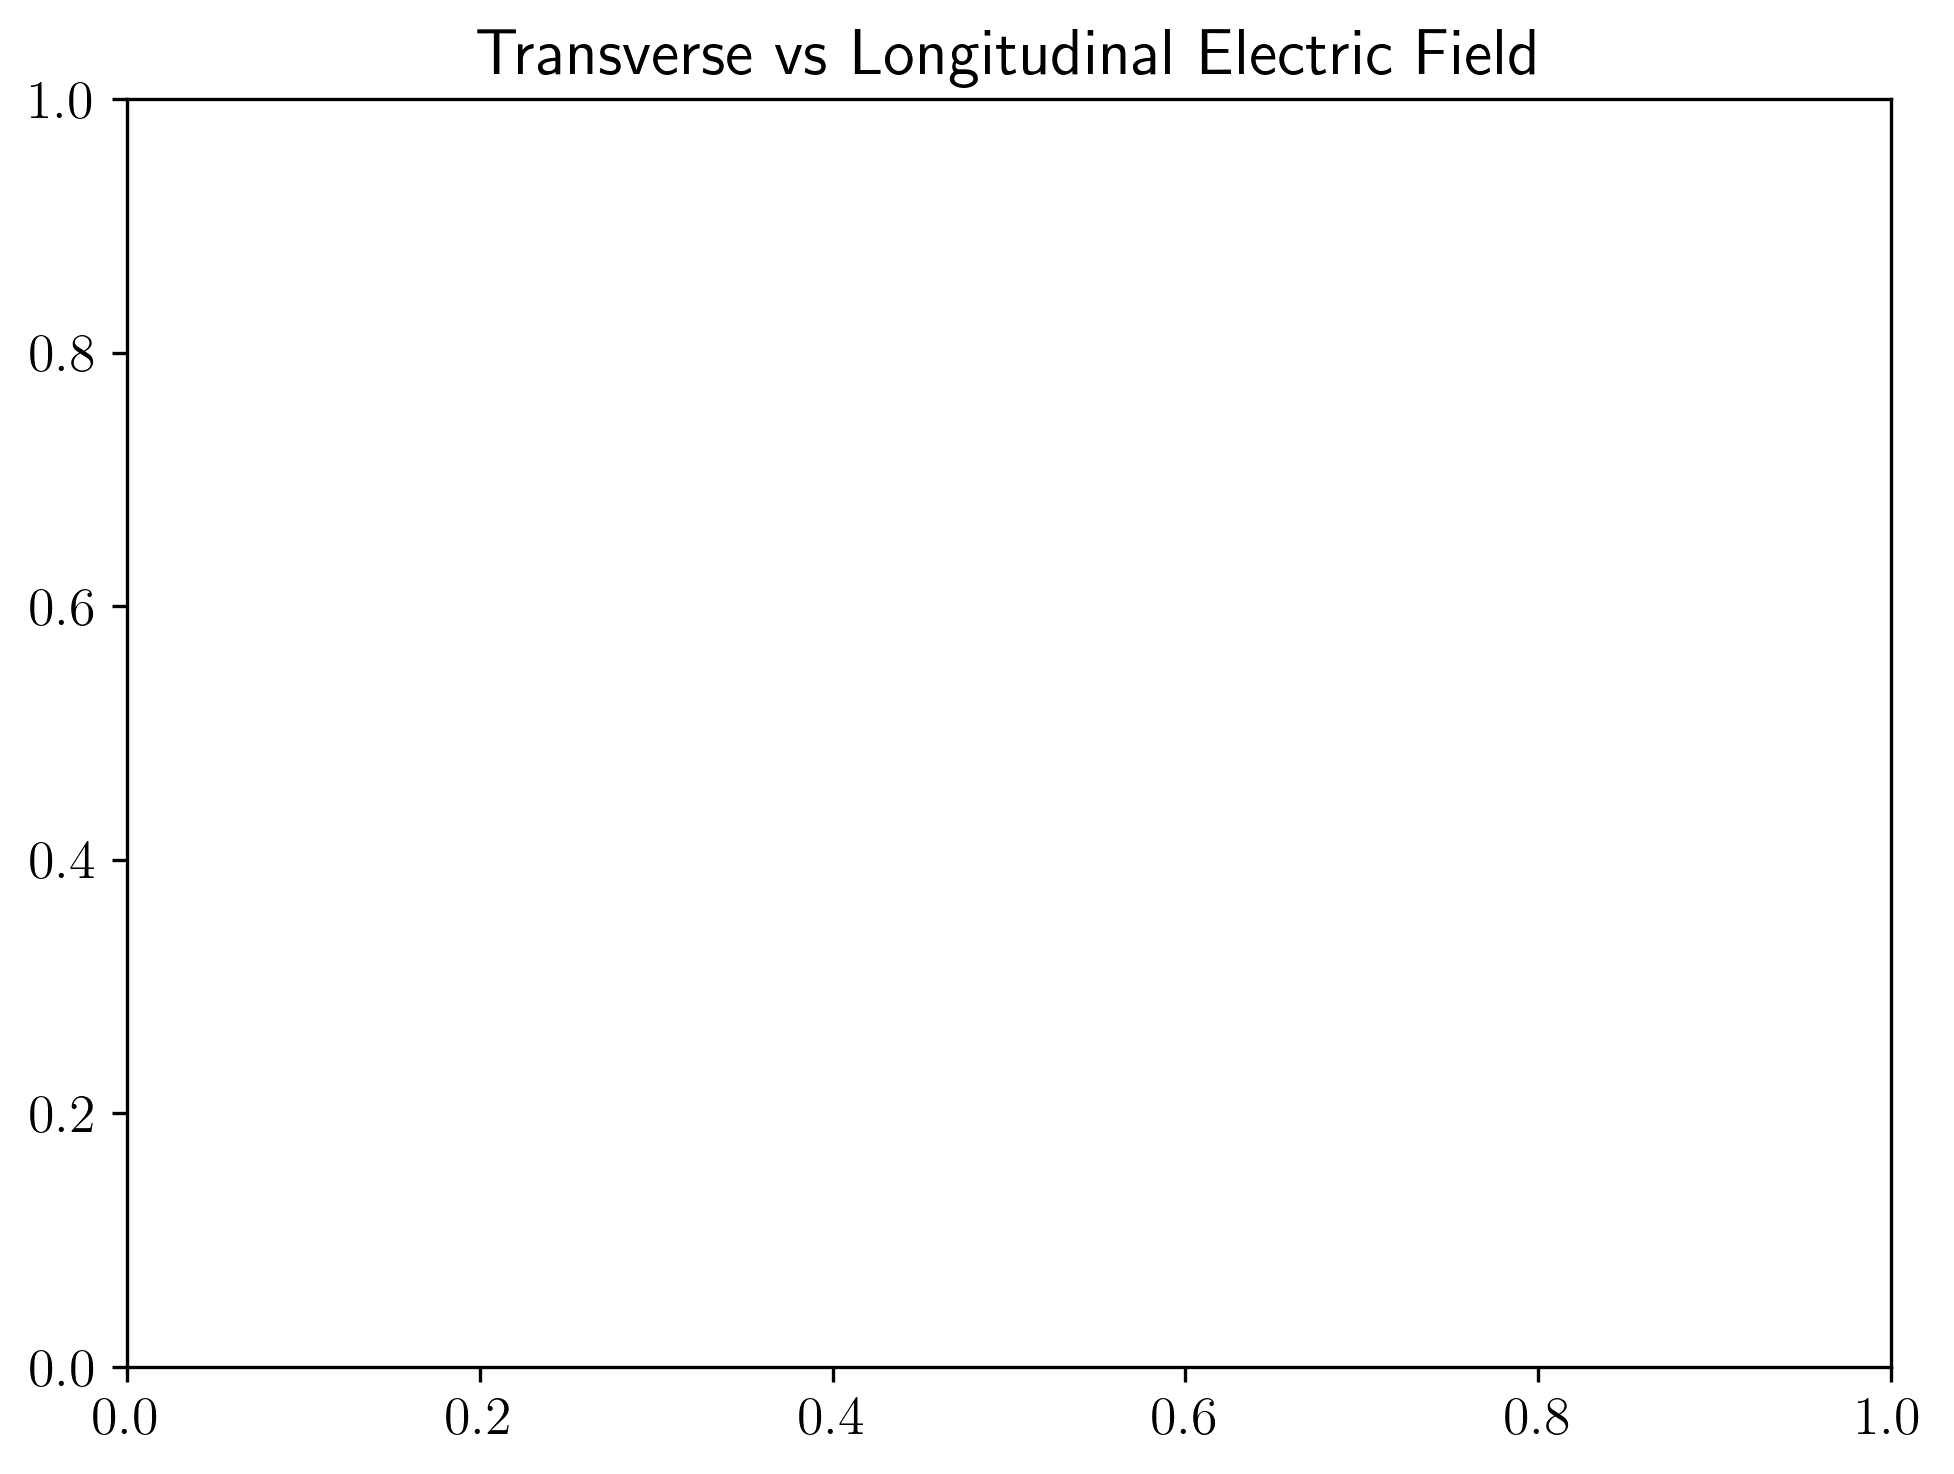

In [121]:
plt.title("Transverse vs Longitudinal Electric Field")
plt.plot(delta*np.asarray(range(steps+1)), [np.mean(efields[i][0][1::2][cx[0]:cx[1]]) for i in range(steps+1)], 'x', label="long")
plt.plot(delta*np.asarray(range(steps+1)), [np.mean(efields[i][1::2,0::2], axis=0)[(L+1)//2] for i in range(steps+1)], 'x', label="trans")
plt.grid(True)
# plt.hlines(y=0, xmin=0, xmax=delta*steps, linestyles="--", linewidth=1, alpha=0.5, color="red")
plt.xlabel("time $(\\delta T)$")
plt.legend()

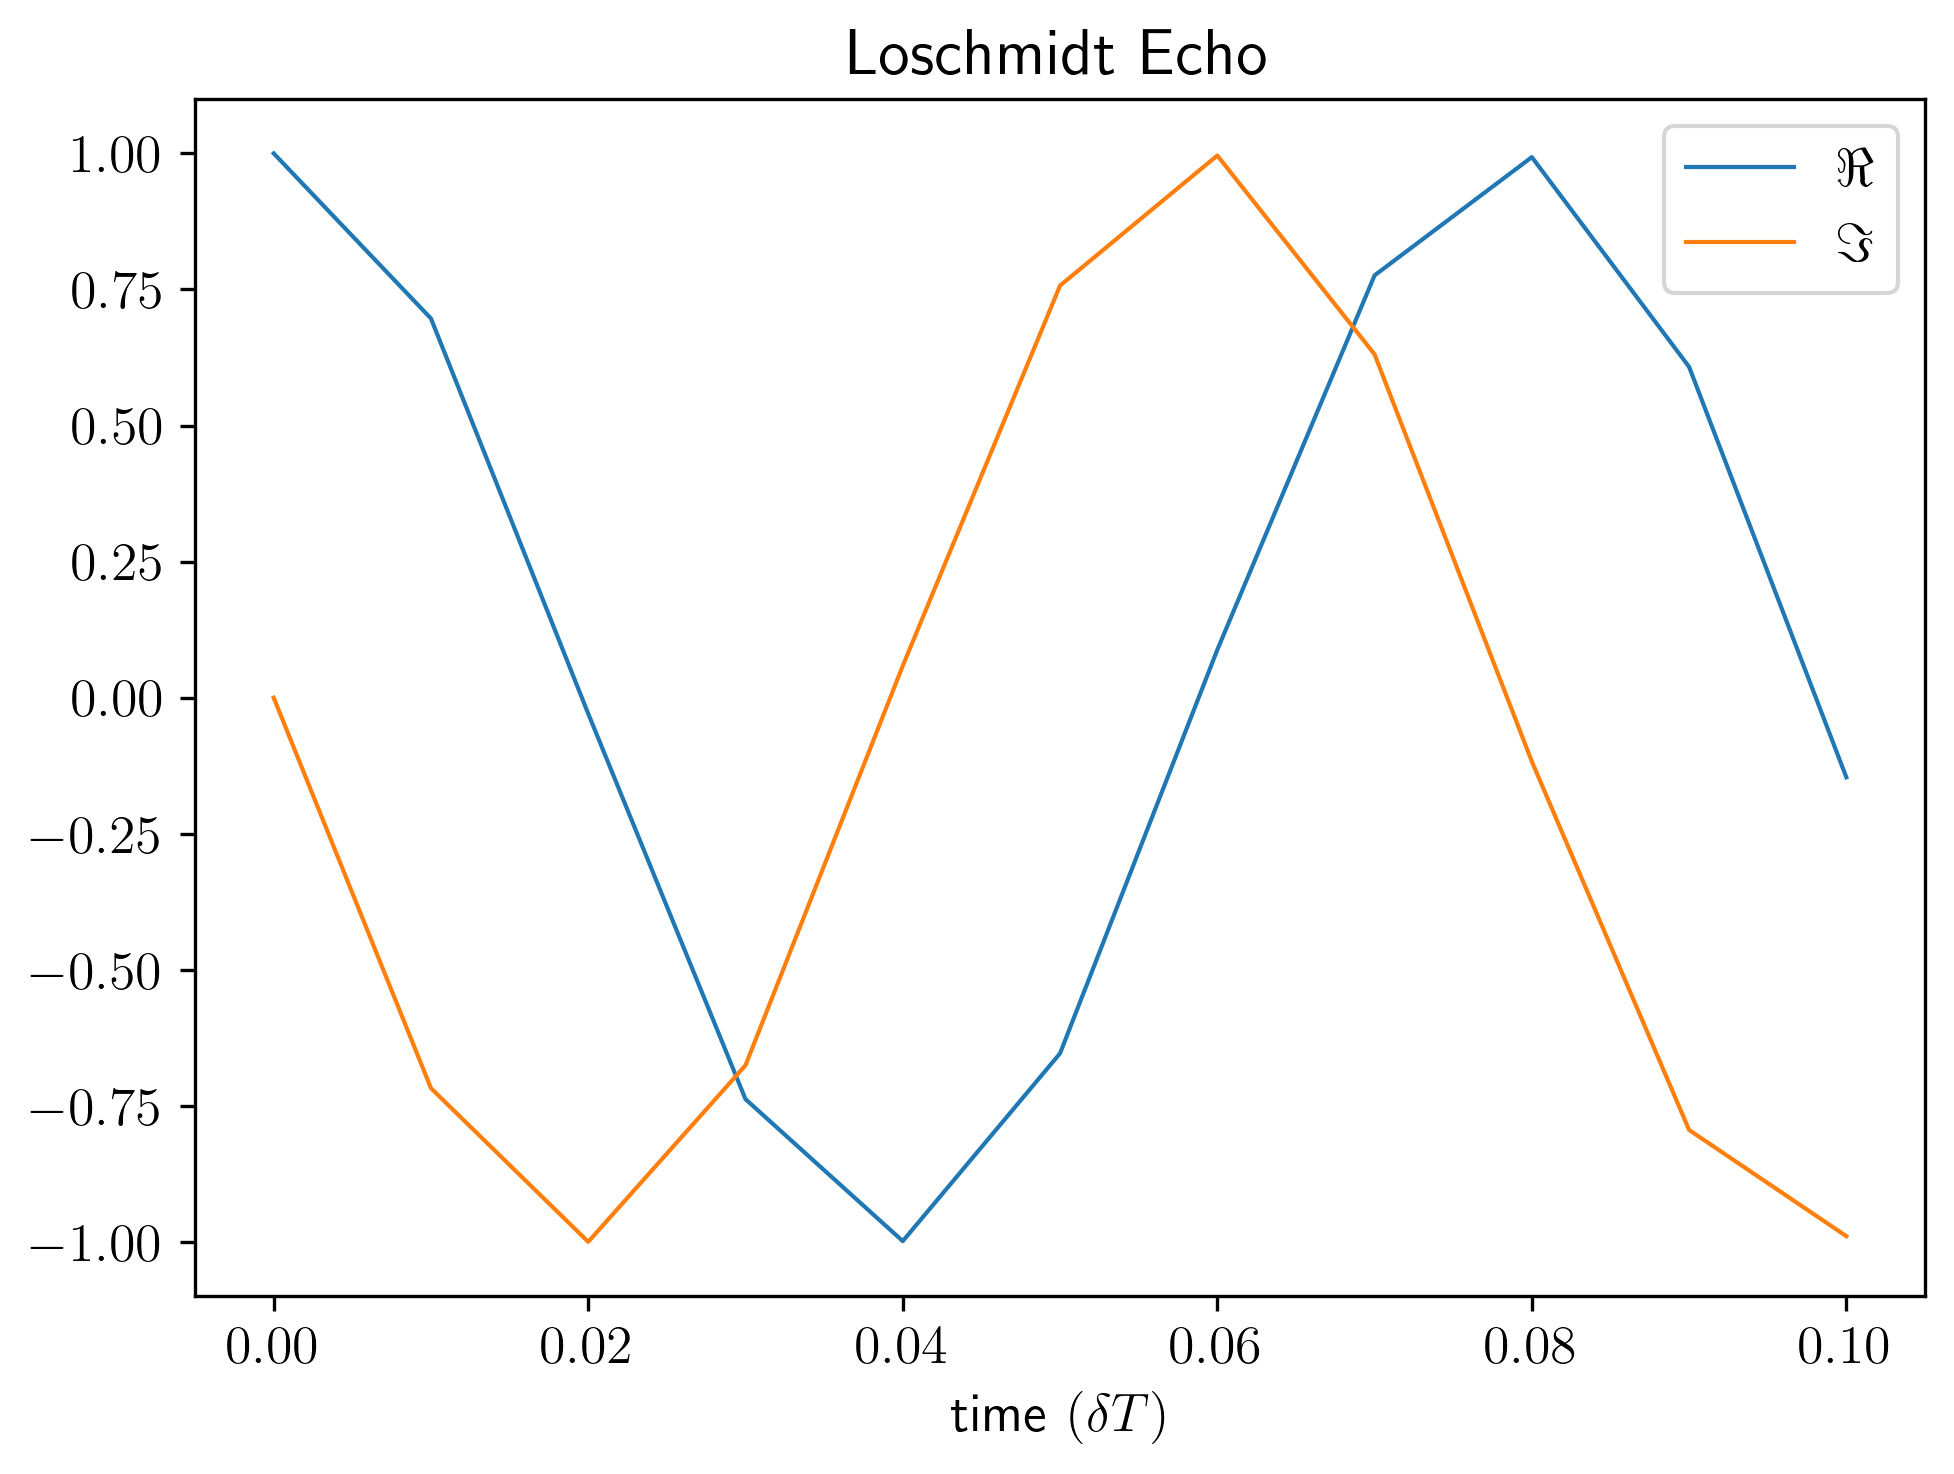

In [ ]:
plt.title("Loschmidt Echo")
plt.plot(delta*np.asarray(range(steps+1)), [ov.real for ov in losch], linewidth=1, label="$\\Re$")
plt.plot(delta*np.asarray(range(steps+1)), [ov.imag for ov in losch], linewidth=1, label="$\\Im$")
plt.xlabel("time $(\\delta T)$")
plt.legend()

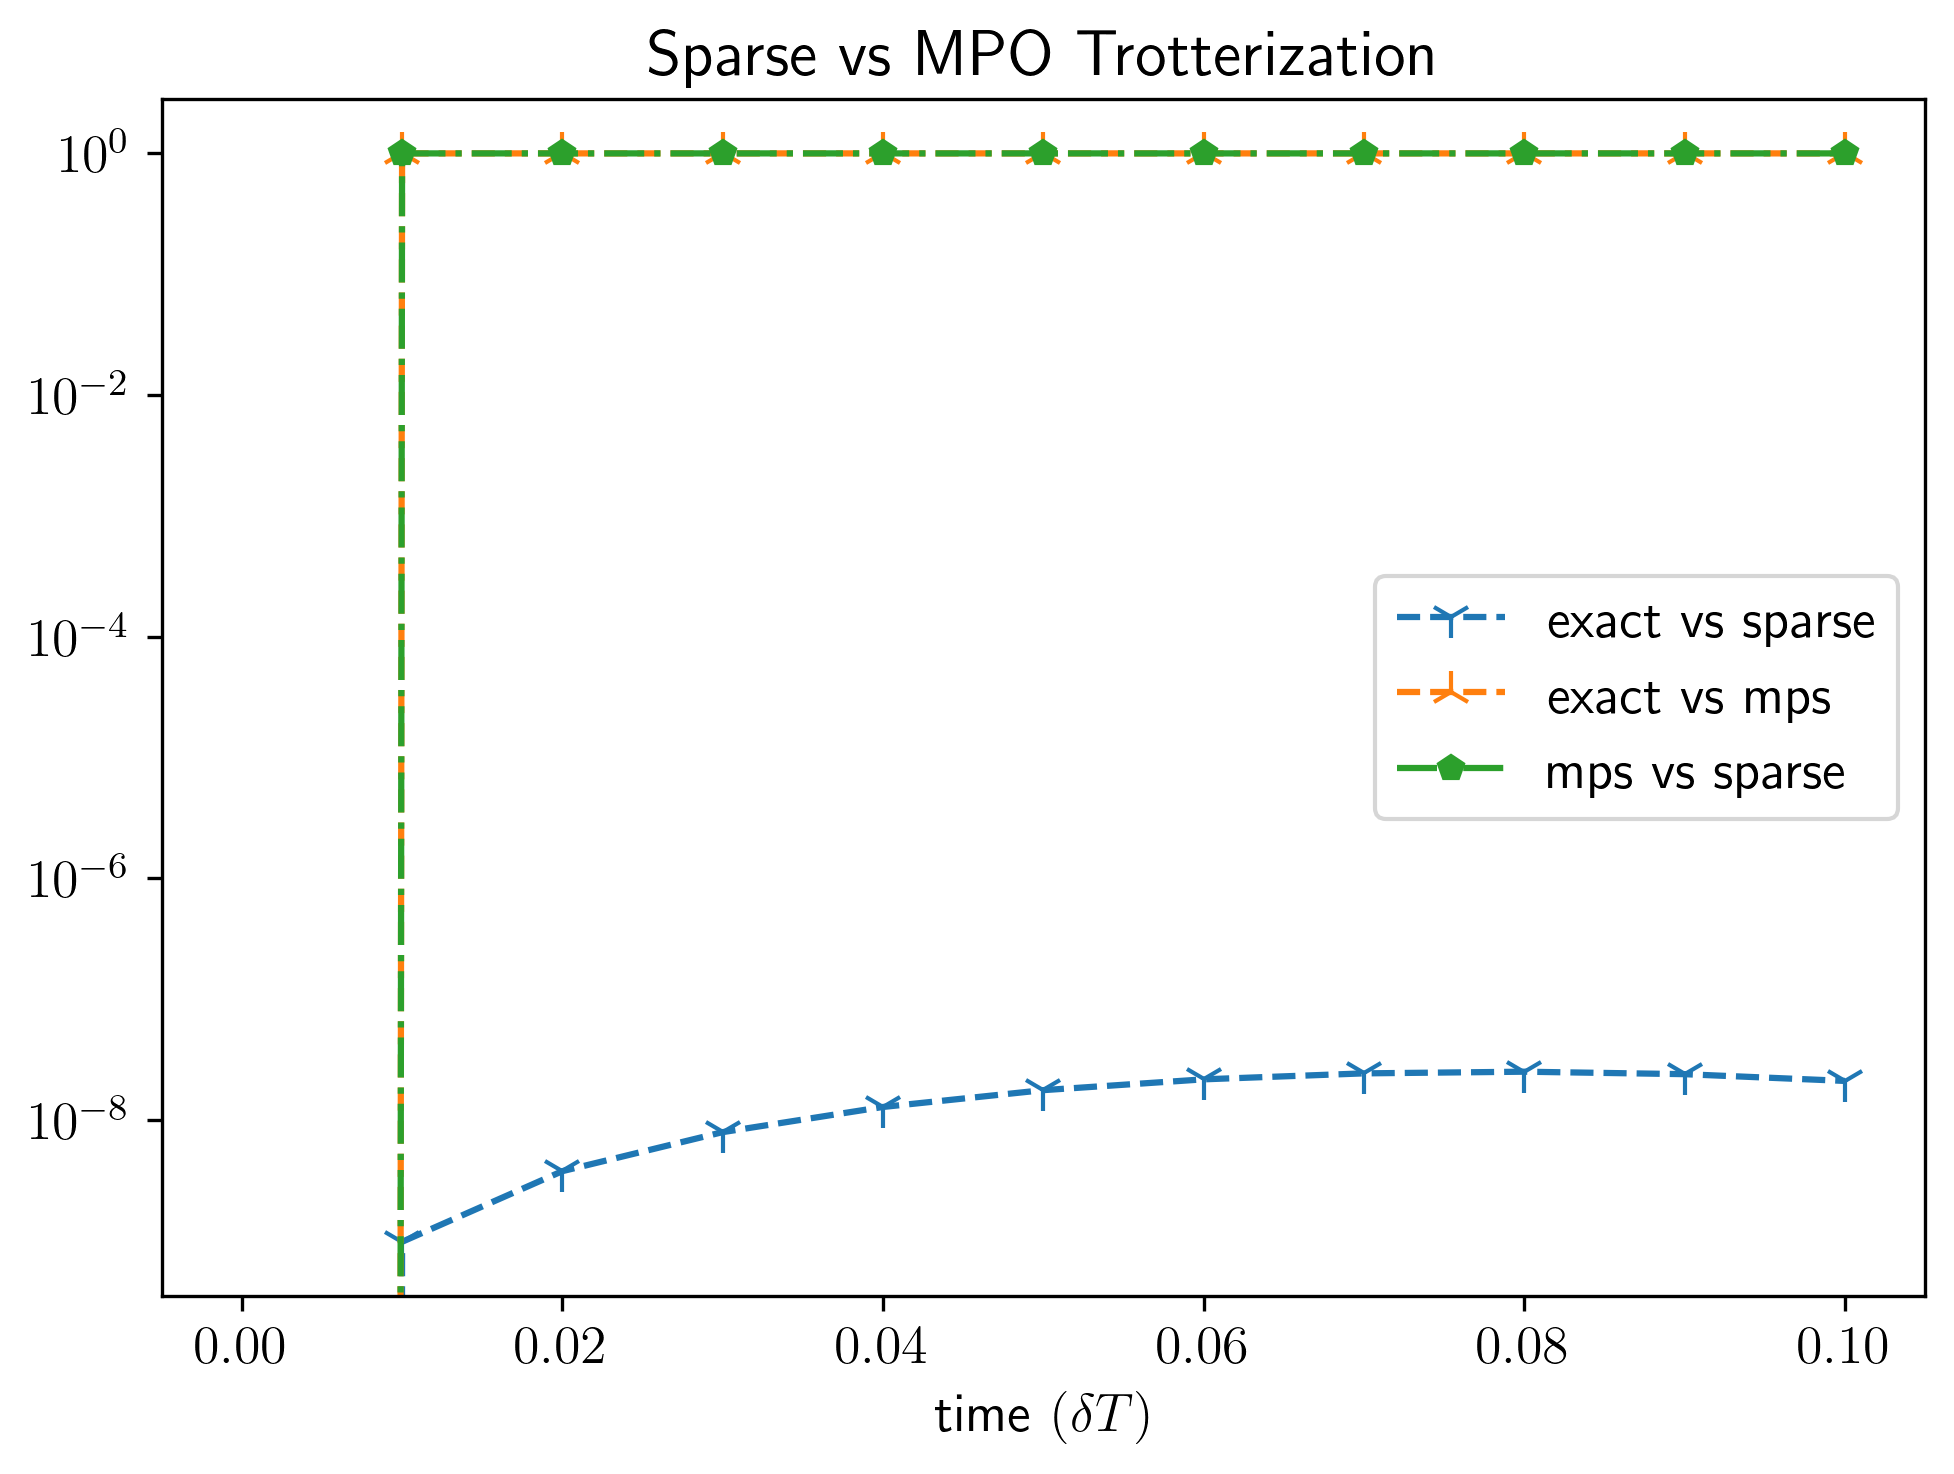

In [123]:
plt.title("Sparse vs MPO Trotterization")
plt.plot(delta*np.asarray(range(steps+1)),[1-(ex_sp[i].real**2+ex_sp[i].imag**2) for i in range(steps+1)], linestyle='--', marker='1', markersize=10, label="exact vs sparse")
plt.plot(delta*np.asarray(range(steps+1)),[1-(ex_mps[i].real**2+ex_mps[i].imag**2) for i in range(steps+1)], linestyle='--', marker='2', markersize=10, label="exact vs mps")
plt.plot(delta*np.asarray(range(steps+1)),[1-(mps_sp[i].real**2+mps_sp[i].imag**2) for i in range(steps+1)], linestyle='-.', marker='p', label="mps vs sparse")
plt.xlabel("time $(\\delta T)$")
plt.yscale("log")
plt.legend()